# Assignment 2: Classification
# Using Machine Learning Tools

## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of classifying data from histological cell images for the diagnosis of malignant breast cancer. This will be presented as a practical scenario where you are approached by a client to solve a problem.  

The main aims of this assignment are:

- to use the best practice machine learning workflow for producing a solution to a client's problem;
- to visualise and clean data;
- to train and optimise a selection of models, then choose the best;
- to obtain an unbiased measurement of the final model's performance;
- to interpret results clearly and concisely.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task, but feel free to add additional cells to structure your notebook. Note that some questions require writing code, some require graphical results, and some require comments or analysis as text. It is your responsibility to make sure your responses are clearly labelled and your code has been fully executed (**with the correct results displayed**) before submission!

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code can run correctly on the original data file.

This assignment uses the standard best practice machine learning workflow, building on the first assignment and course workshops, and so less detailed instructions are provided for this assignment. You should be able to implement this workflow now without low-level guidance and a substantial portion of the marks for this assignment are associated with the appropriate choices and executing this workflow correctly and efficiently. Make sure you have clean, readable code as well as producing outputs, since your coding will also count towards the marks (however, excessive commenting is discouraged and will lose marks, so aim for a modest, well-chosen amount of comments and text in outputs).

This assignment can be solved using methods from [sklearn](https://scikit-learn.org/stable/index.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), and [matplotlib](https://matplotlib.org/stable/index.html) as presented in the workshops. Other libraries should not be used (even though they might have nice functionality) and occasionally certain specific functions need to be used, which will be made clear in the instruction text. You are expected to make sure that you are using functions correctly, and you should search and carefully read the documentation if unsure.

# Scenario

A client approaches you to solve a machine learning problem for them.  They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures most of the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. Their method employs efficient stochastic sampling, making it much faster than existing methods, although slightly noisier. This method does not measure any of the 'worst' features that appear in the *Wisconsin Breast Cancer Data Set*. They want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked you to implement this for them.

Their requirements are:
 - 1) Have at least a 90% probability of detecting malignant cancer when it is present;
 - 2) Ensure that no more than 1 in 5 healthy cases (those with benign growths) result in a false positive (labeled as malignant).

They have hand-labelled 220 samples for you, with 20 features per sample, which is all they have at the moment.

Please follow the instructions below, which will vary in level of detail.

## 1. Load data, visualise it and identify erroneous values [30%]

 - Load the data from the csv file `assignment2_data_2024.csv` (found on MyUni).
 - Extract the feature names and label names for use later on.
 - Provide at least one text summary of the dataset. This should include key information and characteristics of the data.
 - Create one graphical plot per feature. Each plot must display the feature values for the two classes (malignant and benign) separately on a single axis/panel.
 - Make sure you clearly label the graphical plots with respect to feature names, axes, classes, etc.
 - Identify any erroneous values in the dataset during the data visualisation or summary steps. Determine and implement, here or later, the appropriate action to handle these values (e.g., removal, correction, or none).
 - Throughout this assignment, treat the _malignant_ cases as the _true positive_ class, following the standard convention in medicine.
.

In [461]:
# This code imports some libraries that you will need.
# You should not need to modify it, though you are expected to make other imports later in your code.

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import time

# Pandas for overview
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')

import seaborn as sns

The read_csv function used below reads  CSV file named 'assignment2_data_2024.csv' into a pandas DataFrame called 'Data'.

In [462]:
# Your code here
data = pd.read_csv('assignment2_data_2024.csv')

This code below extracts the feature names from all columns except the label and the unique labels from the label column of the DataFrame, then prints them.

In [463]:
features = data.columns[1:]  # All columns except 'label'
feature_names = features.tolist()
print("Feature Names:",feature_names)

# Extract unique labels from the first column
unique_labels = data.iloc[:, 0].unique().tolist() 
print("Labels:", unique_labels)

Feature Names: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error']
Labels: ['malignant', 'maligant', 'benign']


The data.head() function displays the first few rows of the DataFrame data, providing a quick preview of its structure and content.

In [464]:
data.head()

label         mean radius  mean texture  mean perimeter   mean area  \
0  malignant  15.494653829645529     15.902542      103.008265  776.437239   
1  malignant  16.229870799611437     18.785613      105.176755  874.712003   
2  malignant   16.34567074196476     20.114076      107.083804  872.563251   
3   maligant  13.001009157806651     19.876997       85.889775  541.281012   
4  malignant  16.416060073302194     17.397533      107.857386  891.516818   

   mean smoothness  mean compactness  mean concavity  mean concave points  \
0         0.104239          0.168660        0.170572             0.085668   
1         0.091843          0.092548        0.081681             0.053670   
2         0.099924          0.123799        0.128788             0.078310   
3         0.113423          0.173069        0.146214             0.069574   
4         0.097321          0.111530        0.125971             0.068575   

   mean symmetry  ...  radius error  texture error  perimeter error  \
0       0.205053  ...      0.653654       1.096678         4.962255   
1       0.180435  ...      0.445451       1.043931         3.005373   
2       0.189756  ...      0.549625       1.057447         3.643671   
3       0.212078  ...      0.430693       1.202955         3.051434   
4       0.179562  ...      0.525532       1.045900         3.747194   

   area error  smoothness error  compactness error  concavity error  \
0   80.619370          0.006669           0.034950         0.043568   
1   50.407958          0.006352           0.019998         0.025324   
2   62.732851          0.006757           0.031325         0.034350   
3   33.614356          0.007930           0.044881         0.042972   
4   59.164555          0.008718           0.024231         0.039763   

   concave points error  symmetry error  fractal dimension error  
0              0.013765        0.024093                 0.004928  
1              0.012172        0.018084                 0.003582  
2              0.015150        0.021459                 0.004066  
3              0.014556        0.035670                 0.005981  
4              0.014202        0.019236                 0.004115  

[5 rows x 21 columns]

This code below displays basic information about the dataset, including the number of entries, column names, non-null counts, and data types, by using the info() method of the DataFrame.

In [465]:
# Display basic information about the dataset
print("Dataset Information:")
print(data.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    220 non-null    object 
 1   mean radius              220 non-null    object 
 2   mean texture             220 non-null    float64
 3   mean perimeter           220 non-null    float64
 4   mean area                220 non-null    float64
 5   mean smoothness          220 non-null    float64
 6   mean compactness         220 non-null    float64
 7   mean concavity           220 non-null    float64
 8   mean concave points      220 non-null    float64
 9   mean symmetry            220 non-null    float64
 10  mean fractal dimension   220 non-null    float64
 11  radius error             220 non-null    float64
 12  texture error            220 non-null    float64
 13  perimeter error          220 non-null    float64
 14  area 

We need to convert the 'mean radius' column, currently of type object, to float. To achieve this, we use the to_numeric function, which converts the 'mean radius' column in the DataFrame to float, coercing any non-numeric values to NaN. 

Here's the code:

In [466]:
# Convert 'mean radius' to float
data['mean radius'] = pd.to_numeric(data['mean radius'], errors='coerce')

This code snippet below prints summary statistics for the numerical columns in the DataFrame data, including count, mean, standard deviation, minimum, 25th percentile (Q1), median (50th percentile), 75th percentile (Q3), and maximum values.

In [467]:
# Display summary statistics
print("\nSummary Statistics:")
print(data.describe())


Summary Statistics:
       mean radius  mean texture  mean perimeter    mean area  \
count   219.000000    220.000000      220.000000   220.000000   
mean     13.693313     18.991963       89.866240   620.956227   
std       2.176062      1.427635        7.366180   106.419871   
min     -14.292182     15.349270       74.690886    -2.645499   
25%      13.092060     17.914319       84.911981   558.731832   
50%      13.647143     18.928256       88.587737   603.806128   
75%      14.272883     19.995859       93.066393   655.690435   
max      18.200299     24.430831      121.247839  1103.740620   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       220.000000        220.000000      220.000000           220.000000   
mean          0.096480          0.102879        0.085281             0.046867   
std           0.004961          0.019819        0.026911             0.012548   
min           0.084651          0.075184        0.050771             

The code snippet below counts the occurrences of each unique value in the 'label' column of the DataFrame data, showing the distribution of classes. To check the imbalance between different classes in the dataset.

In [468]:
# Display class distribution
print("\nClass Distribution:")
print(data['label'].value_counts())


Class Distribution:
label
benign       154
malignant     65
maligant       1
Name: count, dtype: int64


In the code below, I am correcting a mislabeled class ('maligant' to 'malignant') in the 'label' column of the DataFrame data using the replace method. And then printing the updated distribution of classes ('label') to confirm the correction.

In [469]:
# Correct the mislabeled class
data['label'] = data['label'].replace('maligant', 'malignant')

# Checking class distribution
label_counts = data.iloc[:, 0].value_counts()
print(label_counts)

label
benign       154
malignant     66
Name: count, dtype: int64


The code below calculates the total number of missing values in the DataFrame data across all columns and prints it.

In [470]:
# Additional characteristics
print("\nAdditional Characteristics:")
missing_values = data.isnull().sum().sum
print(f"Total Missing Values: {missing_values}")


Additional Characteristics:
Total Missing Values: <bound method Series.sum of label                      0
mean radius                1
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             1
fractal dimension error    0
dtype: int64>


This code below calculates the total number of duplicate rows in the DataFrame data and prints the count.

In [471]:
duplicate_rows = data.duplicated().sum()
print(f"Total Duplicate Rows: {duplicate_rows}")

Total Duplicate Rows: 0


This code checks negative values in the numerical columns.

In [472]:
# Check for negative values in numerical columns
negative_values = (data[features] < 0).sum()

# Print the columns that have negative values and their counts
print("Columns with negative values and their counts:")
print(negative_values[negative_values > 0])

Columns with negative values and their counts:
mean radius    1
mean area      1
dtype: int64


This code categorizes the data into 'malignant' and 'benign' groups based on the 'label' column. It then creates histograms for each feature, illustrating the distributions for both classes ('malignant' in red and 'benign' in blue) with kernel density estimates. Histograms are selected for their effectiveness in analyzing variations between malignant and benign cases, offering initial insights into potential distinctions and similarities in their distributions. Upon observation, some plots typically show a slight right-skew in the malignant distribution, while the benign distribution tends to appear more symmetrical.

In [473]:
# Separate data by label
malignant_data = data[data['label'] == 'malignant']
benign_data = data[data['label'] == 'benign']

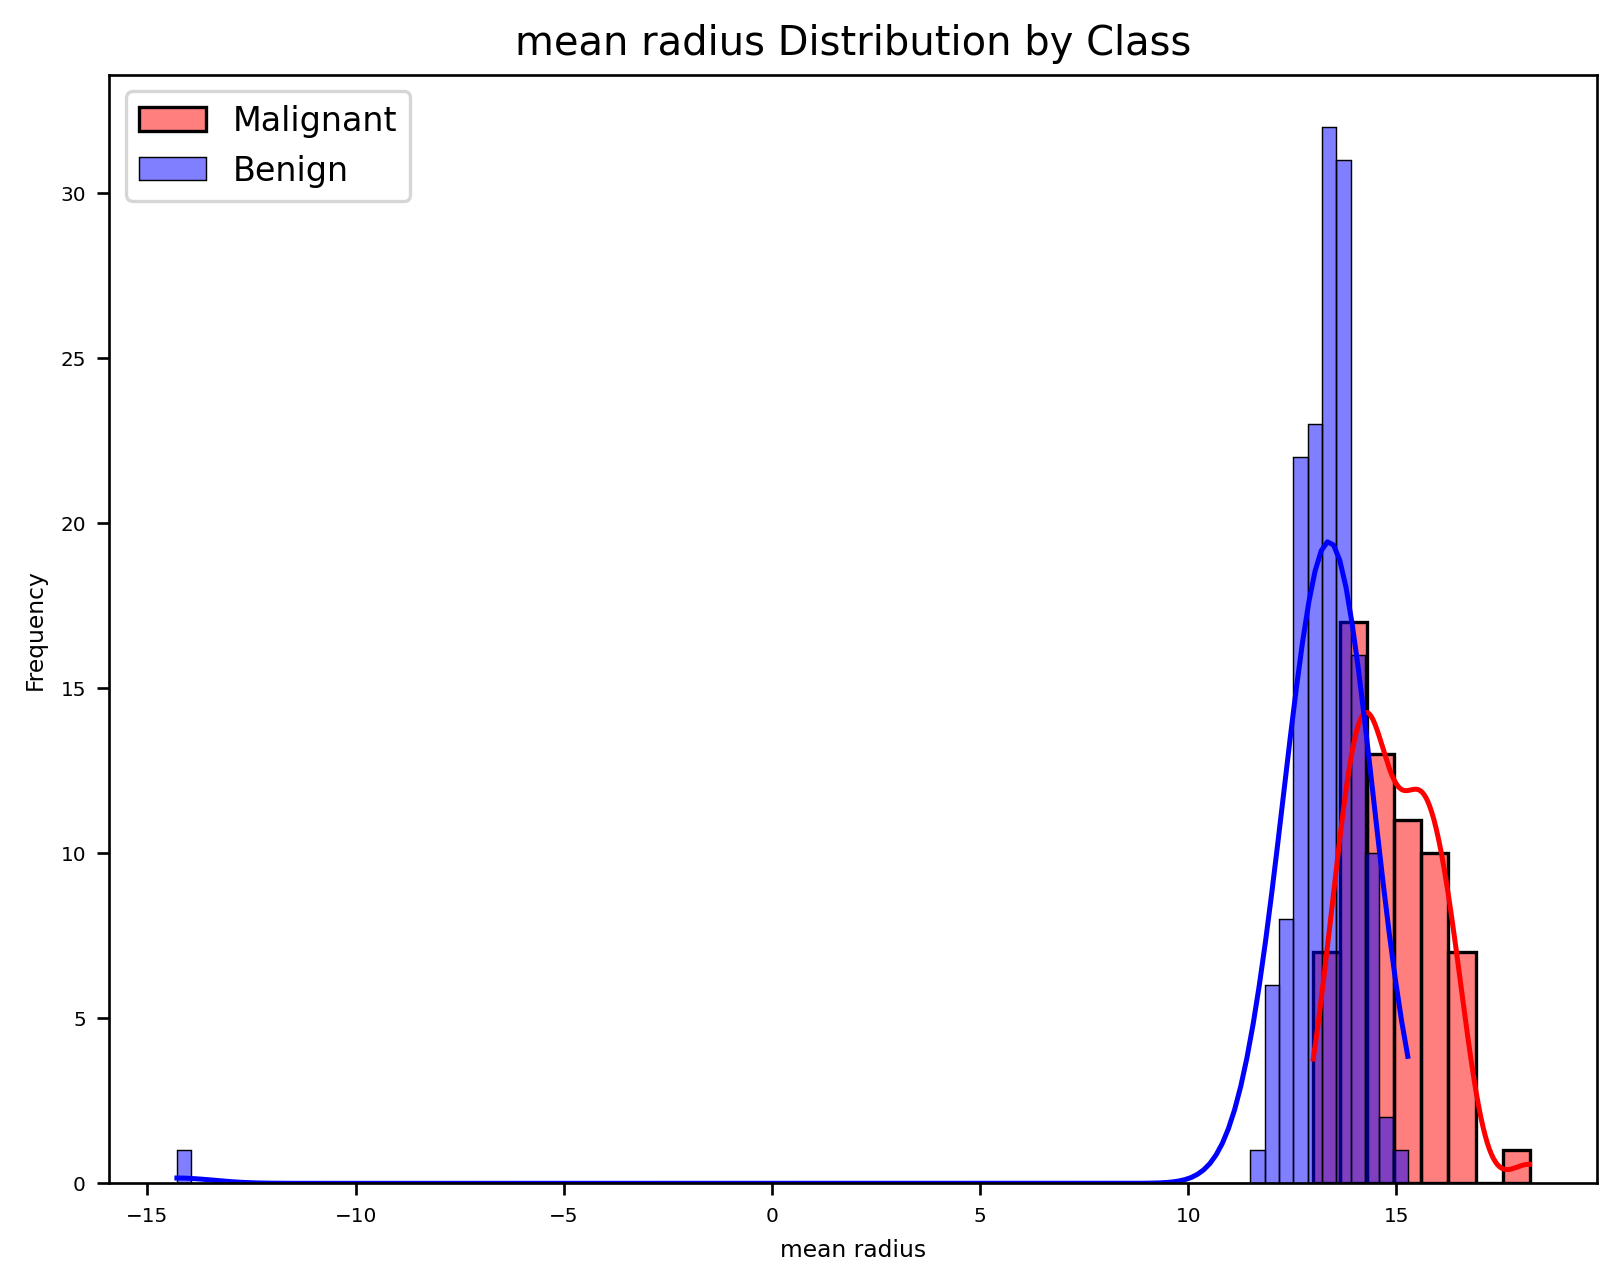

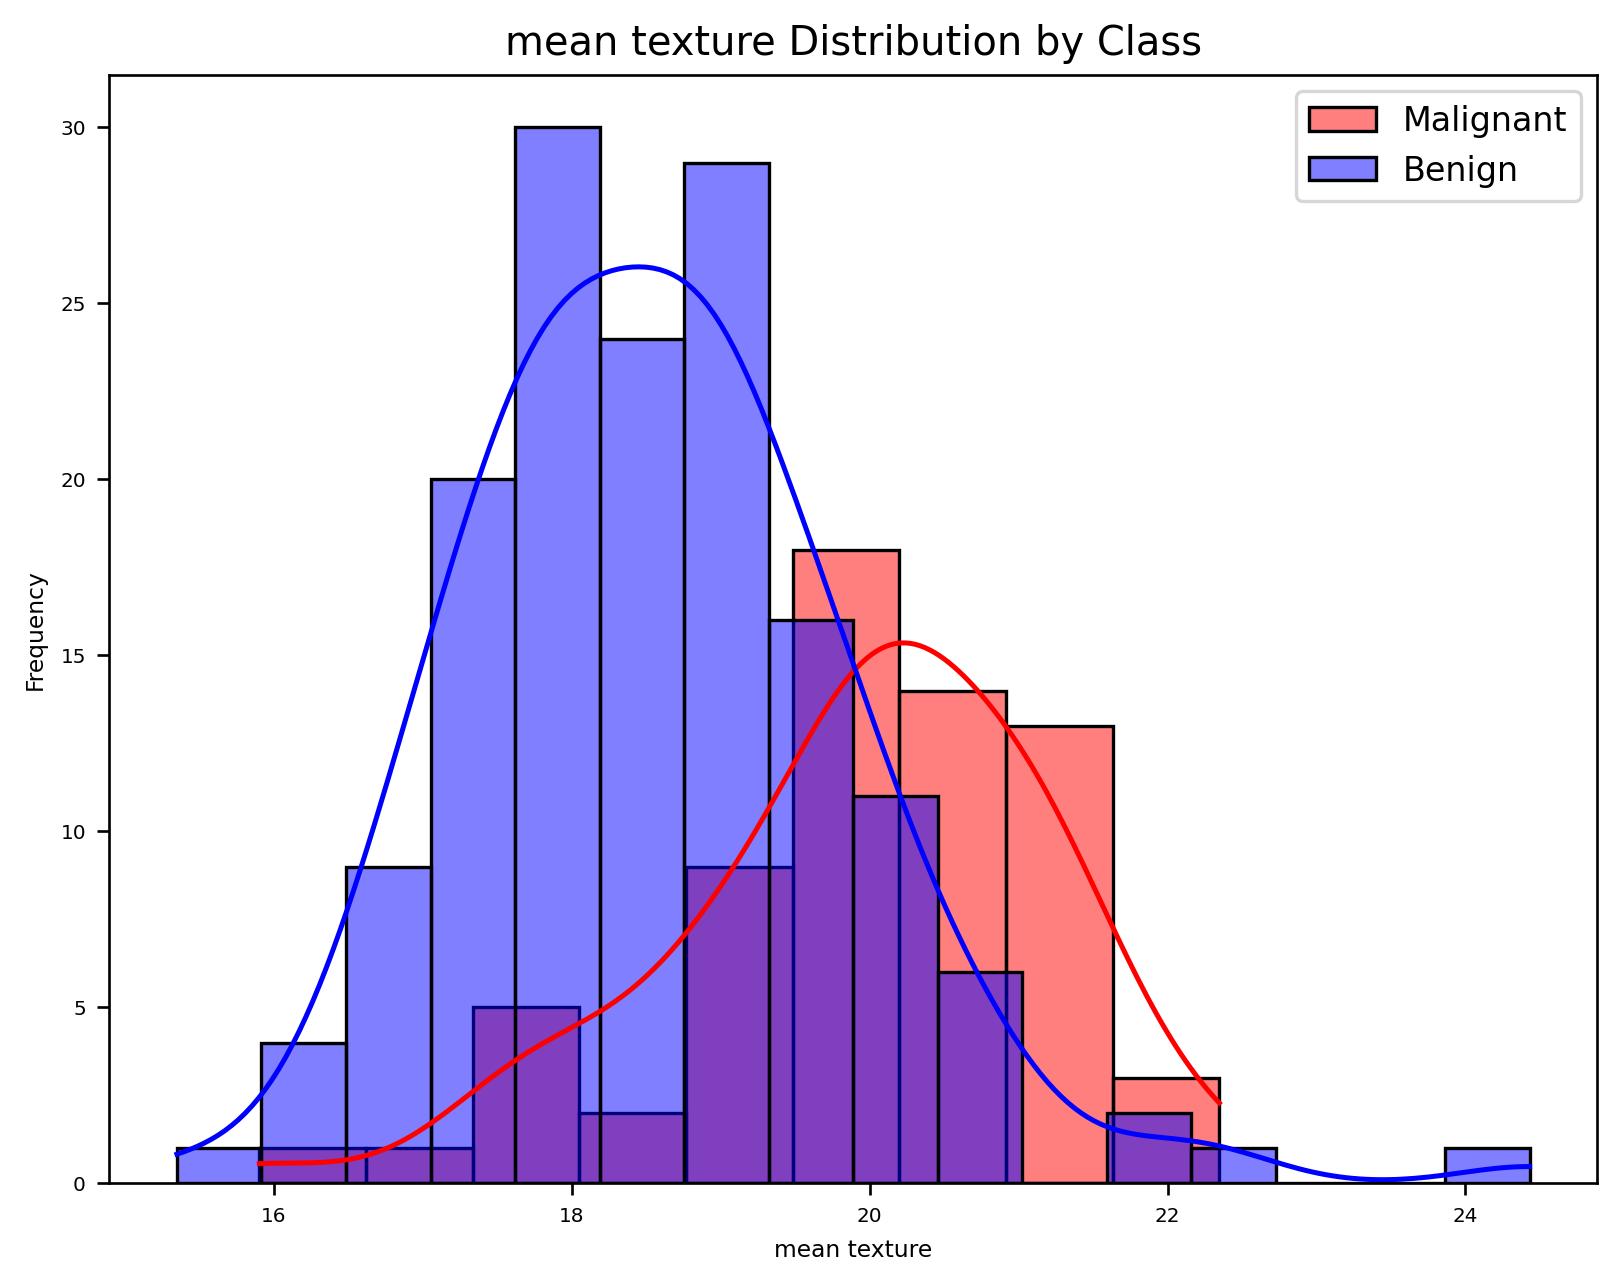

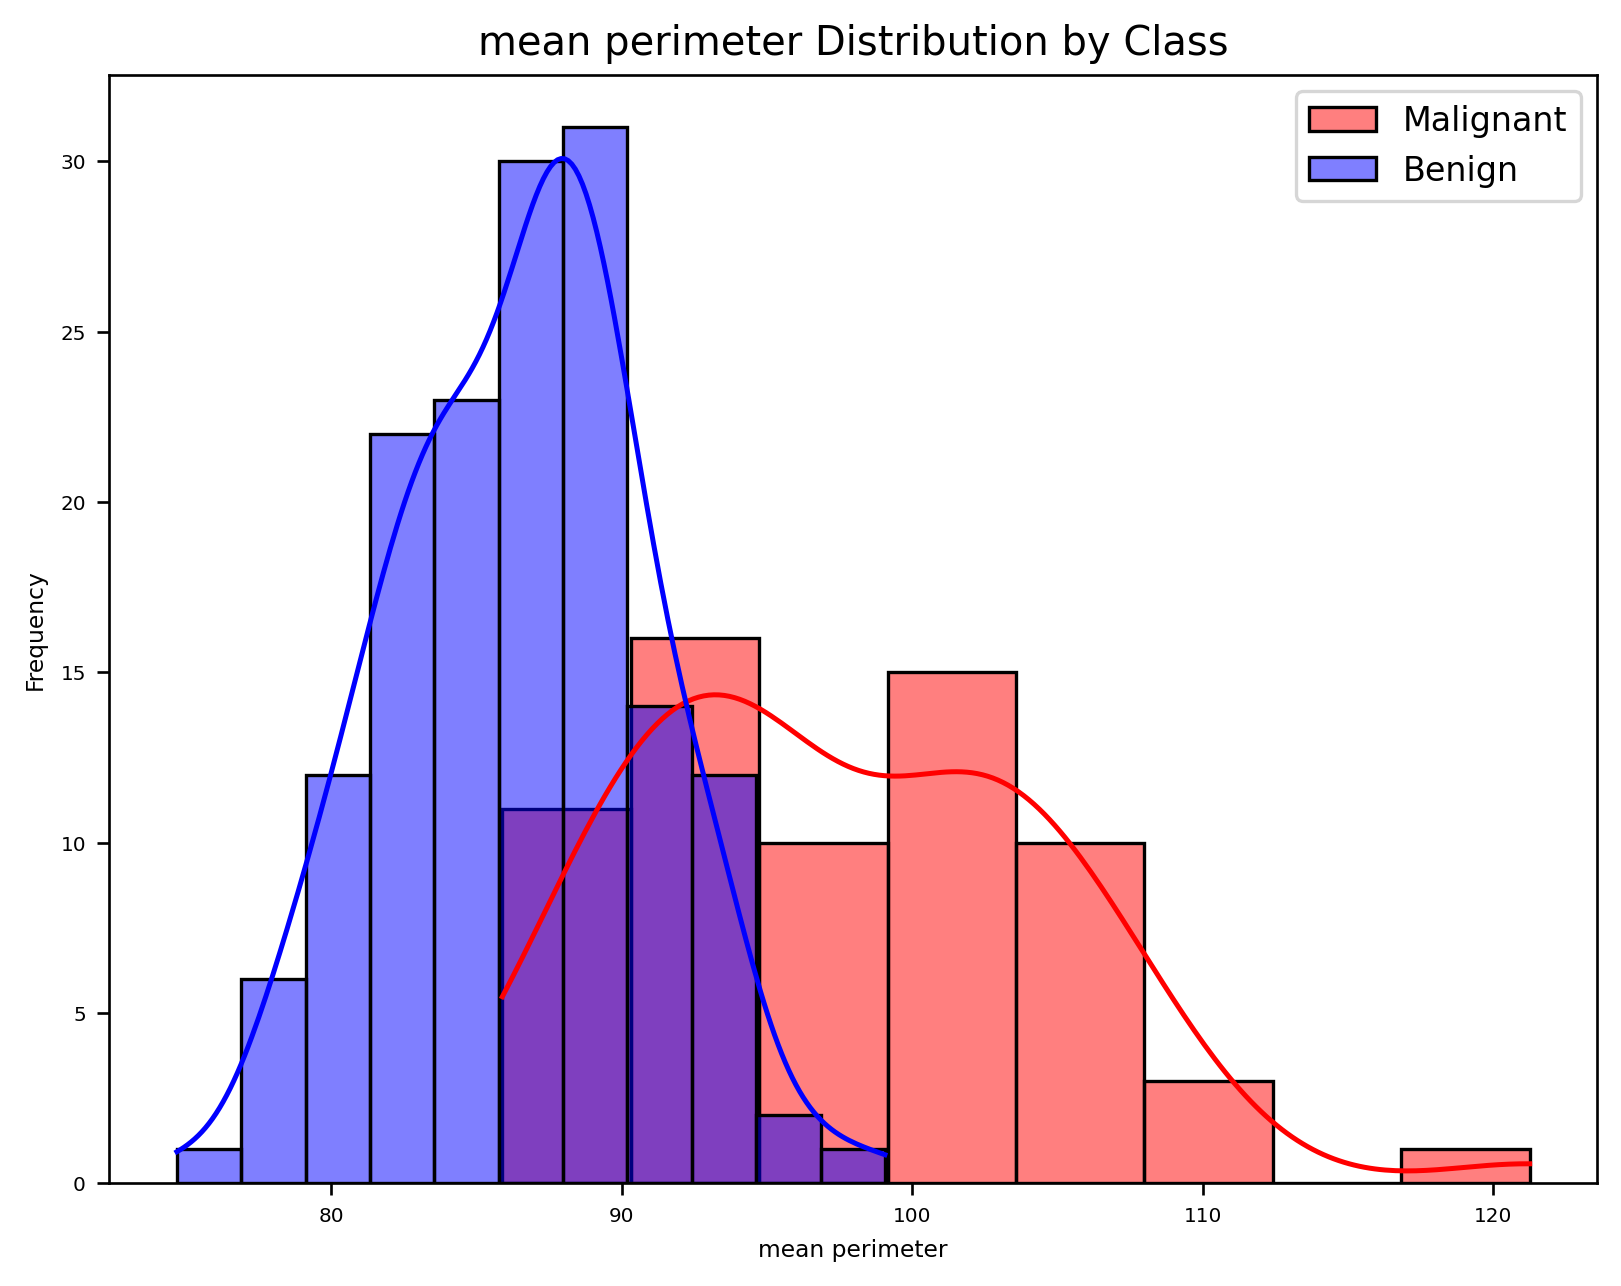

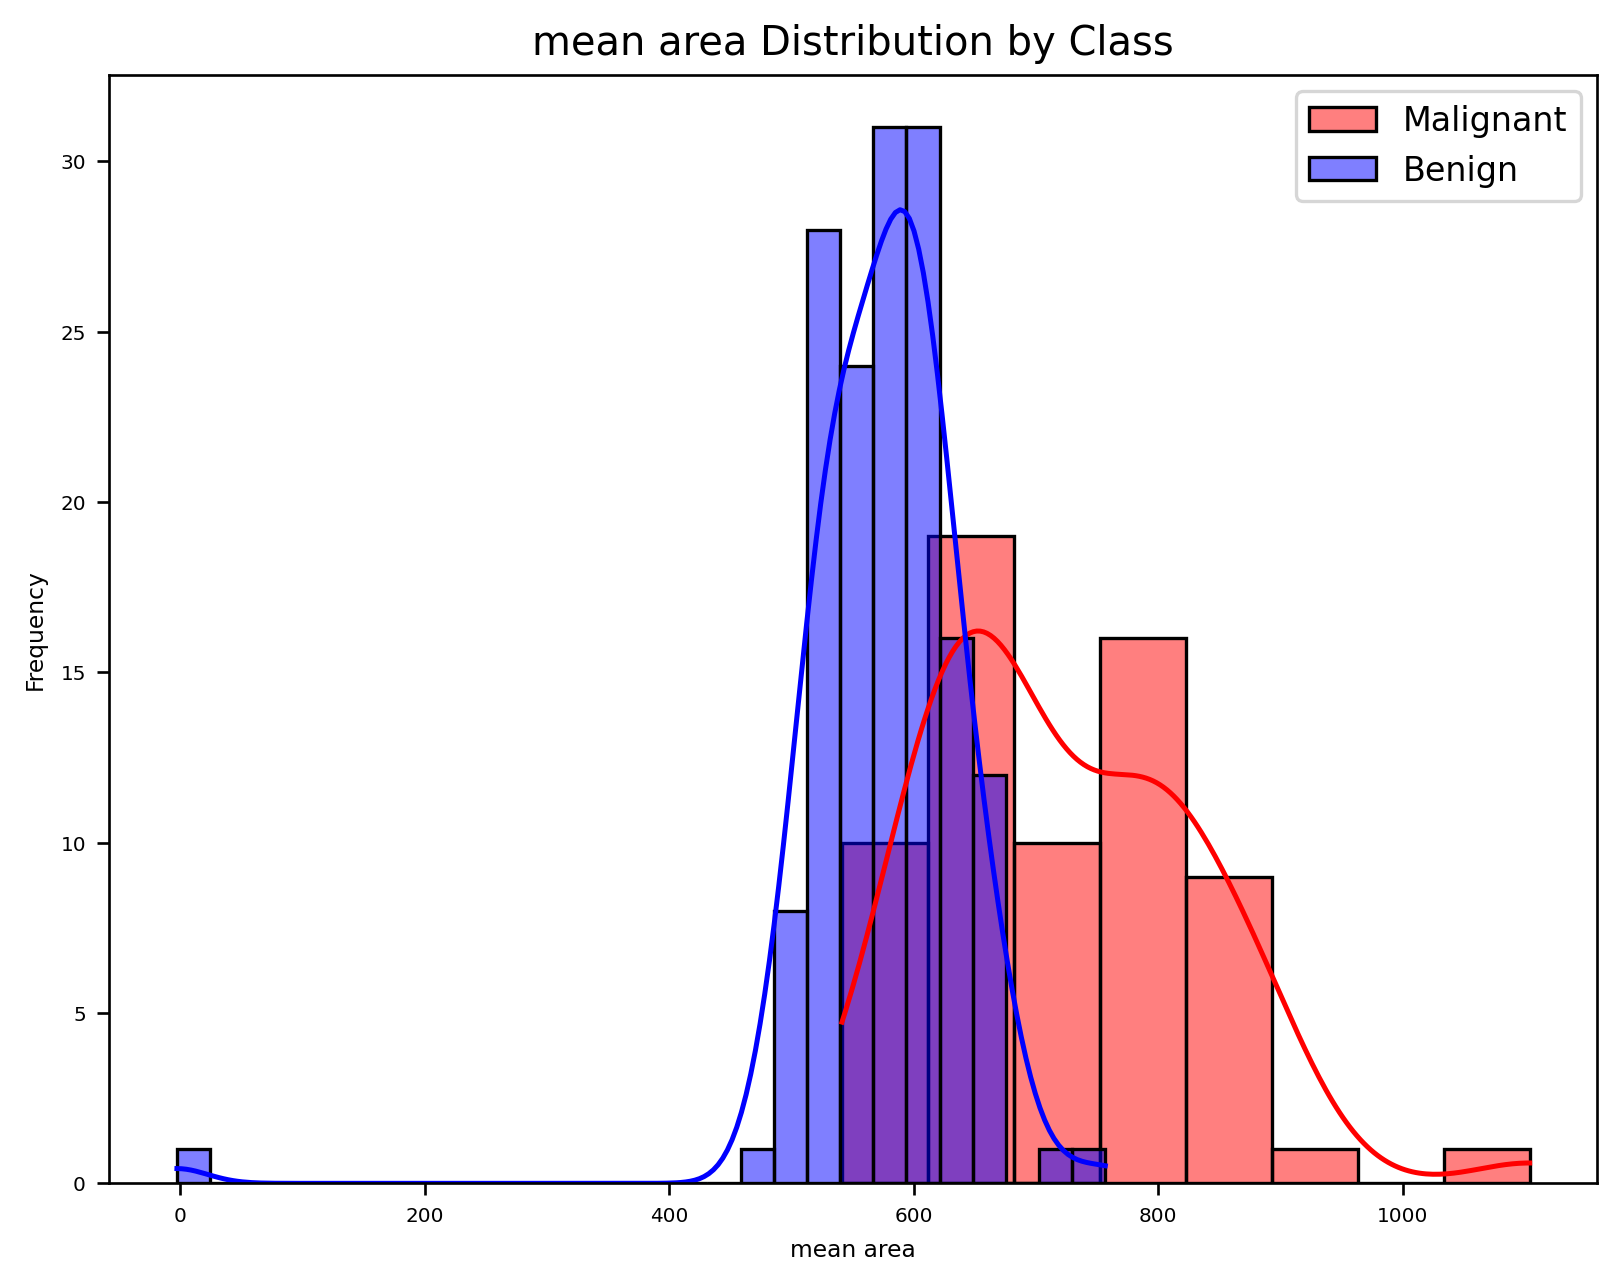

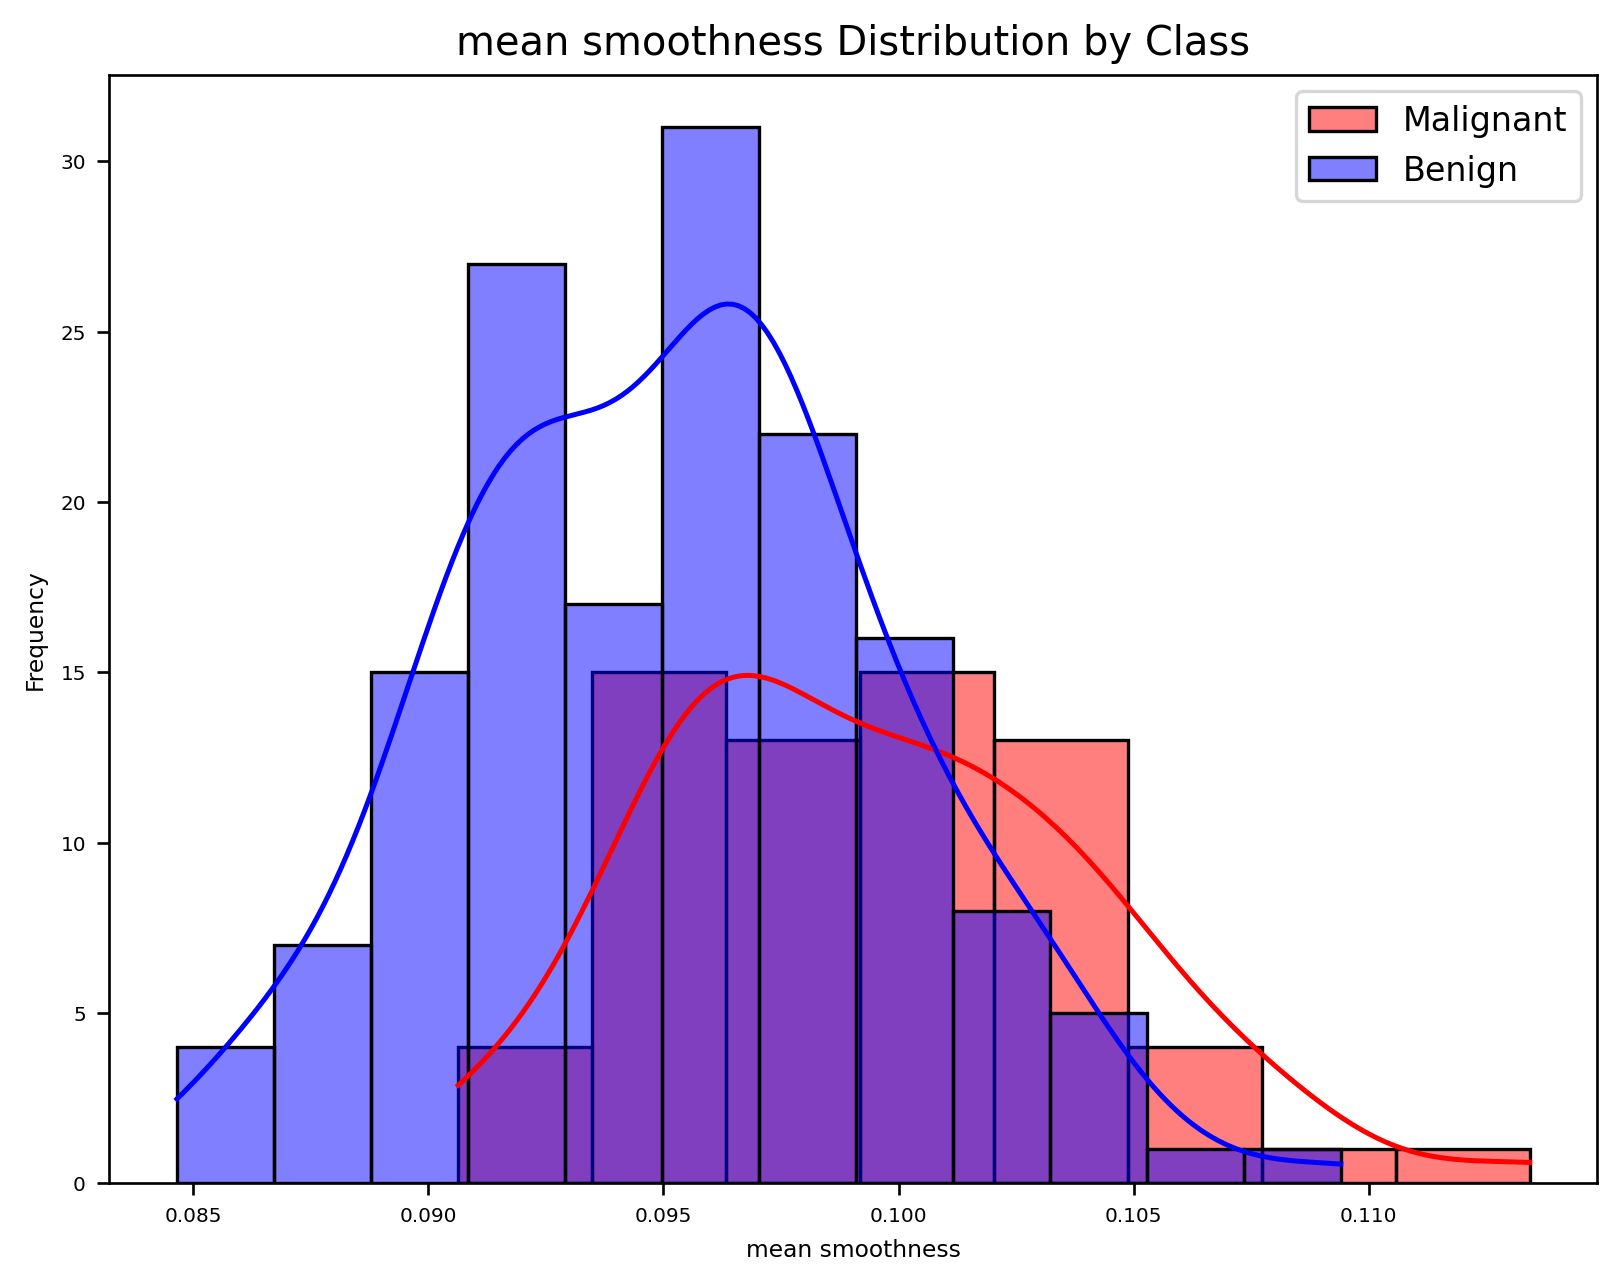

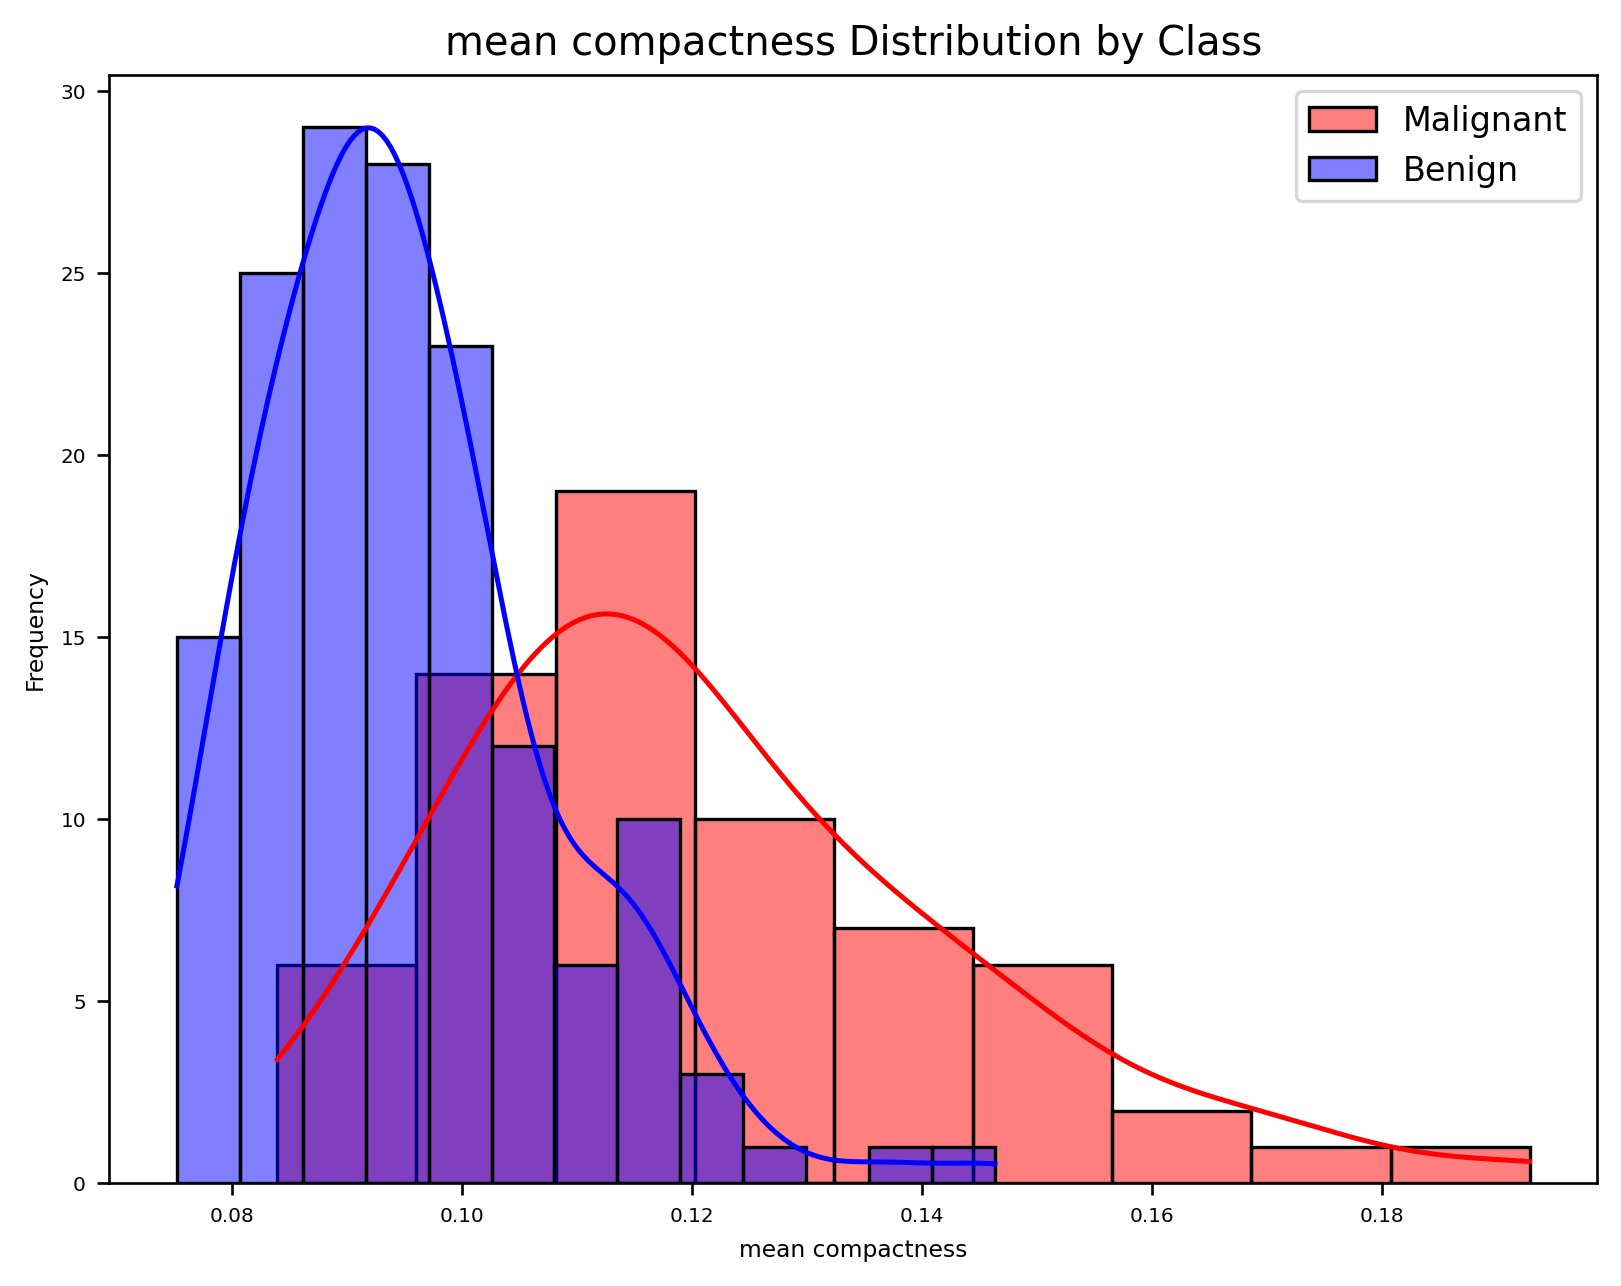

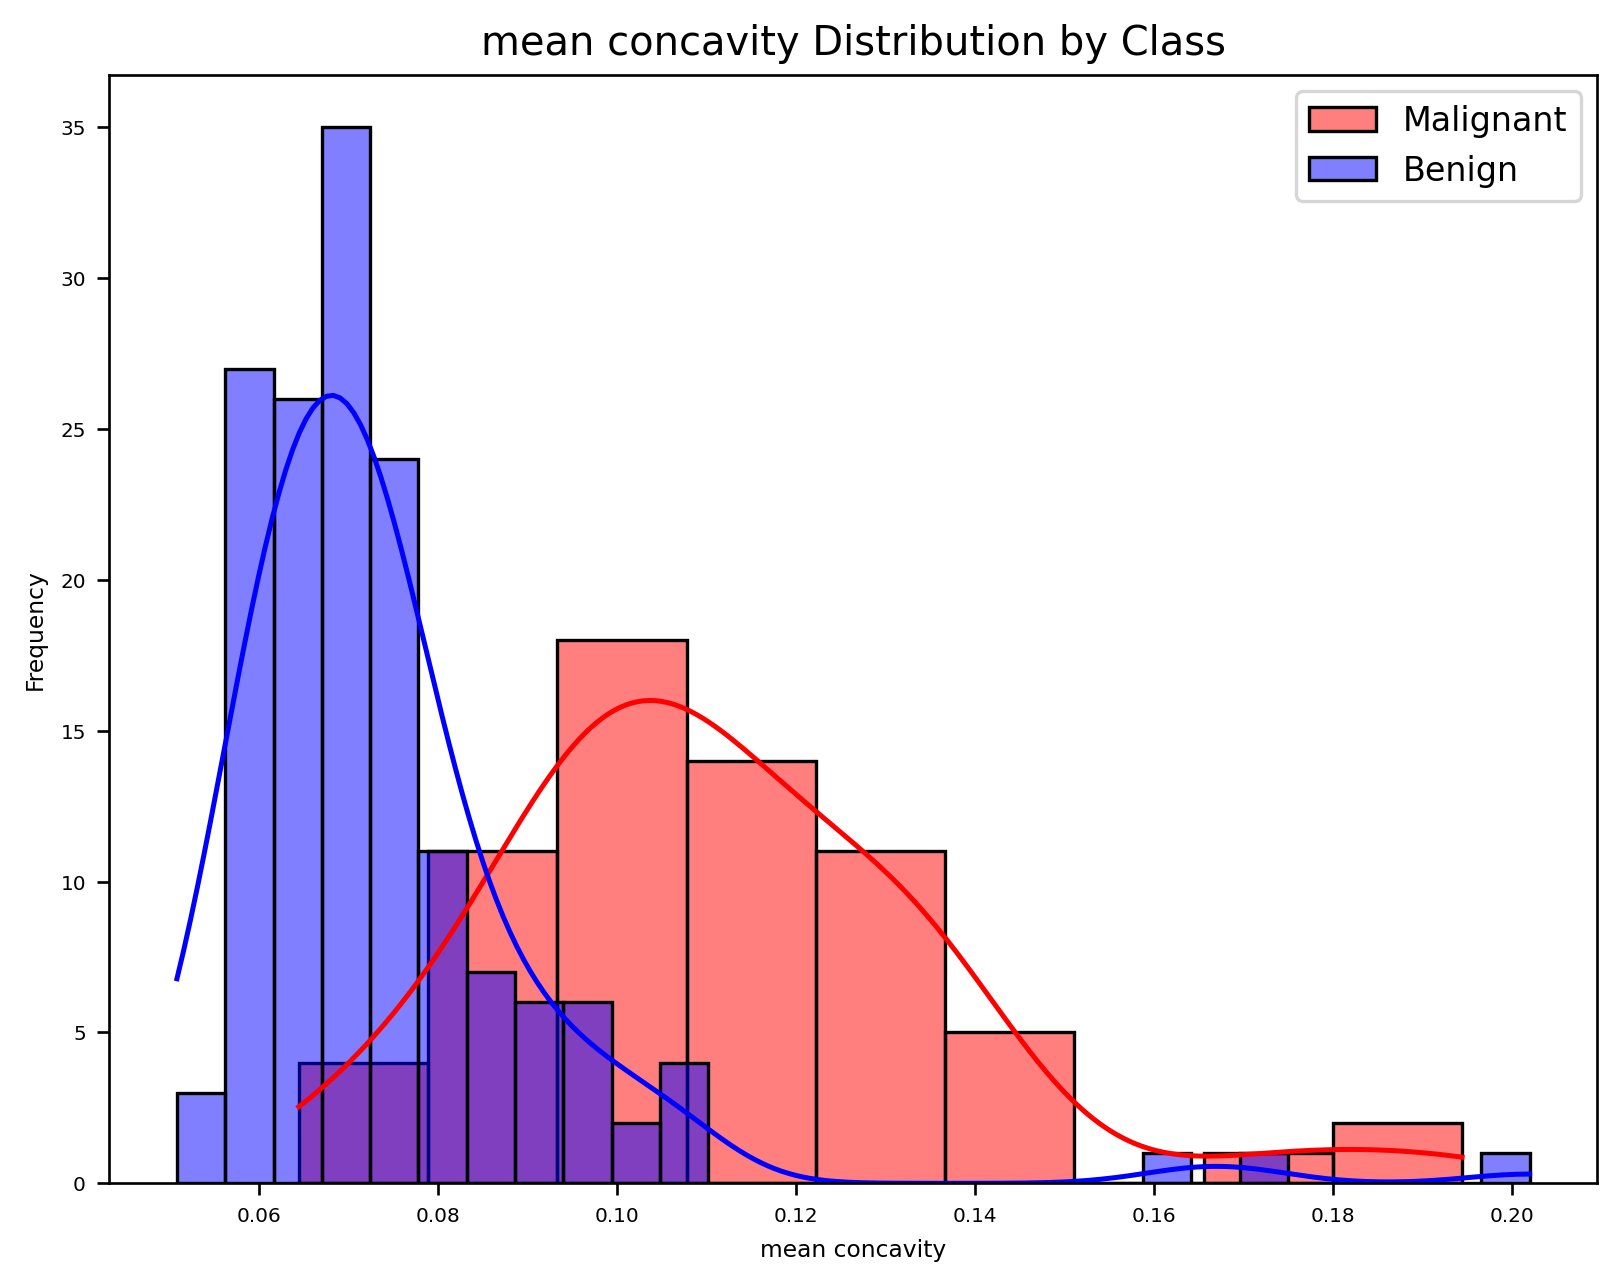

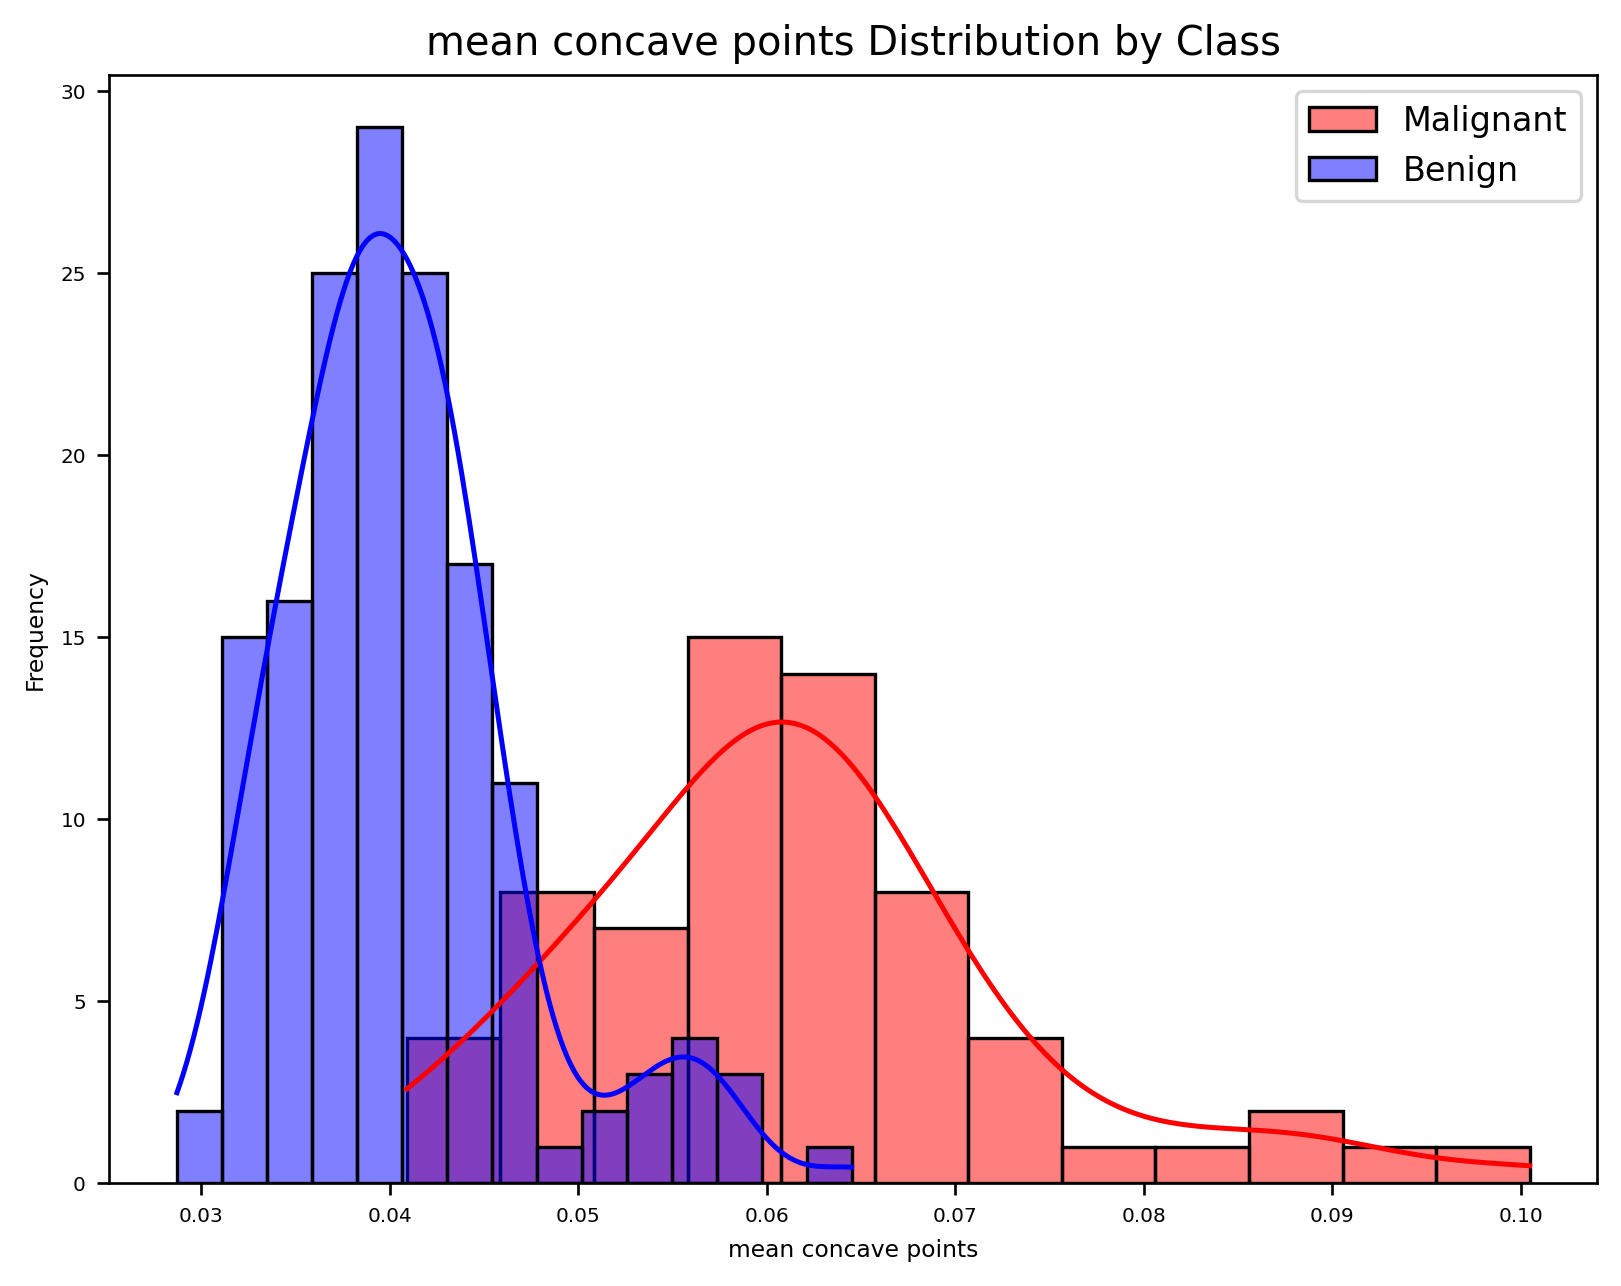

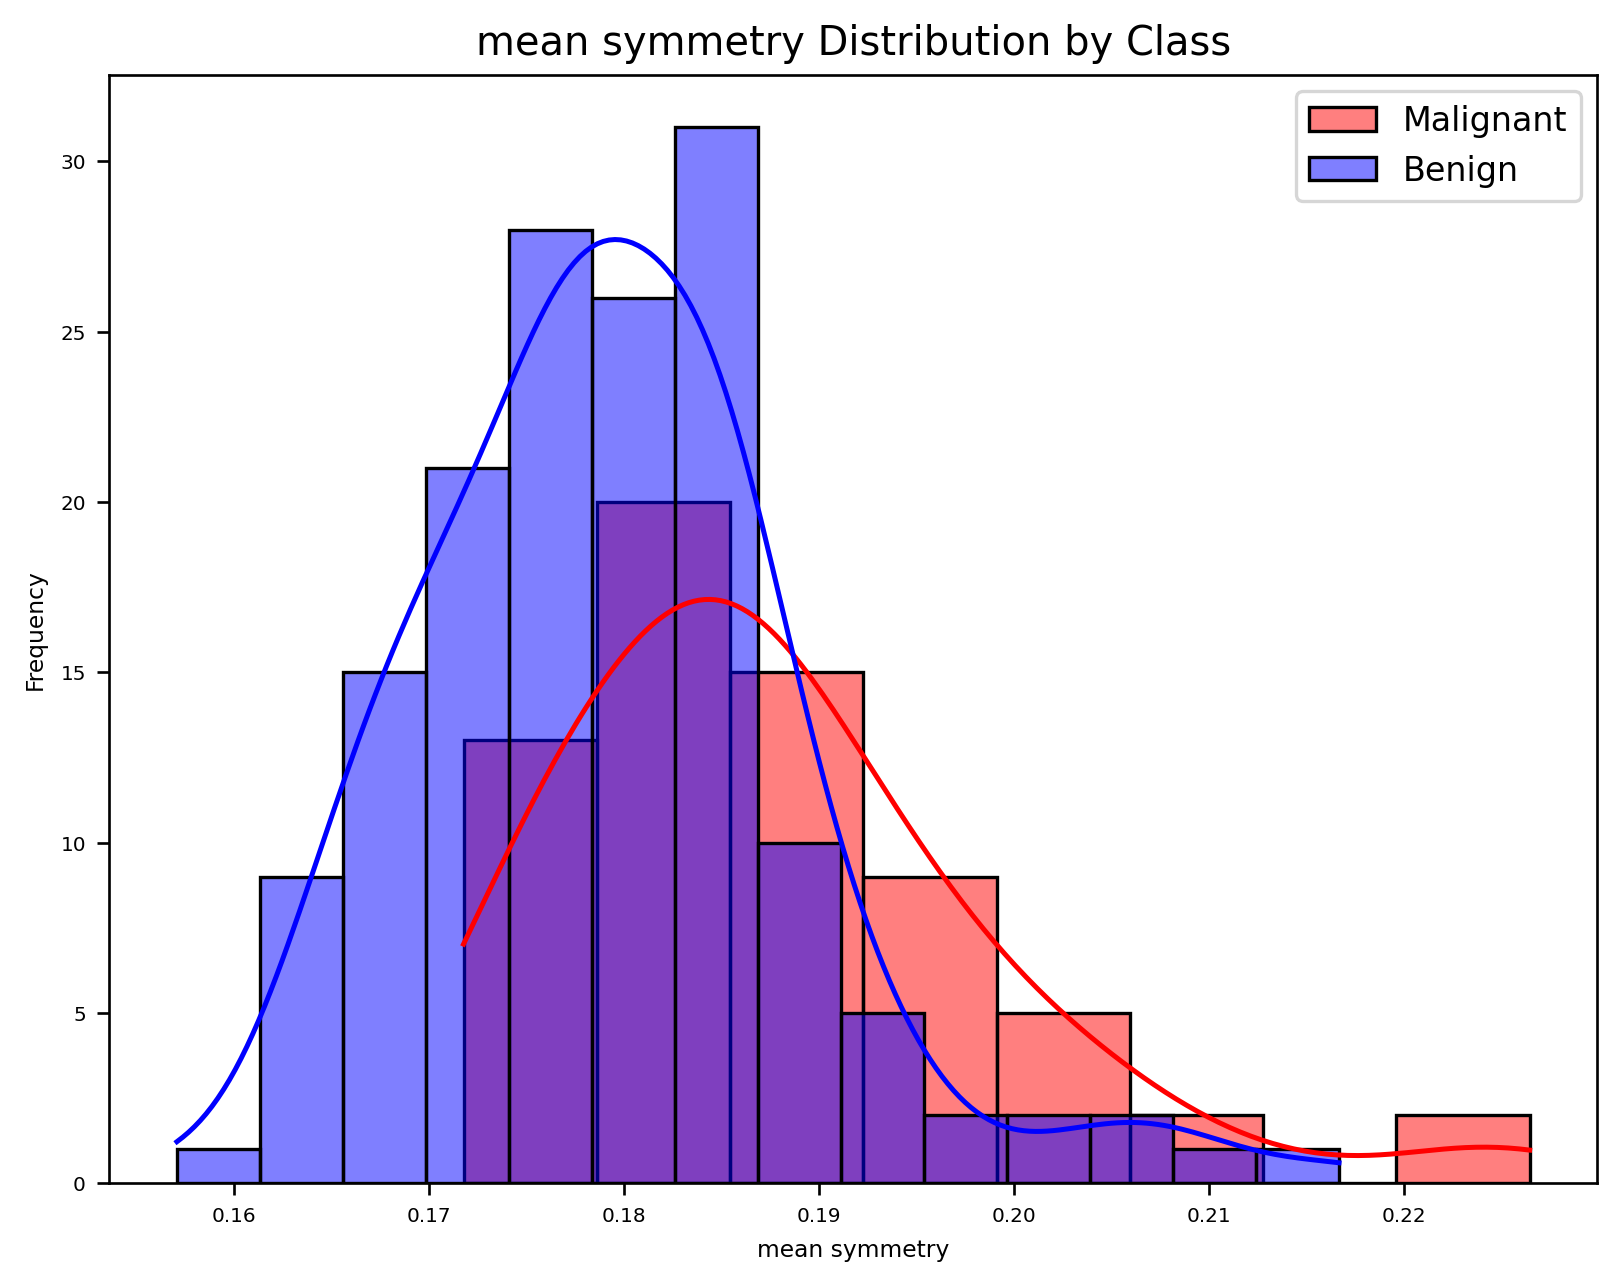

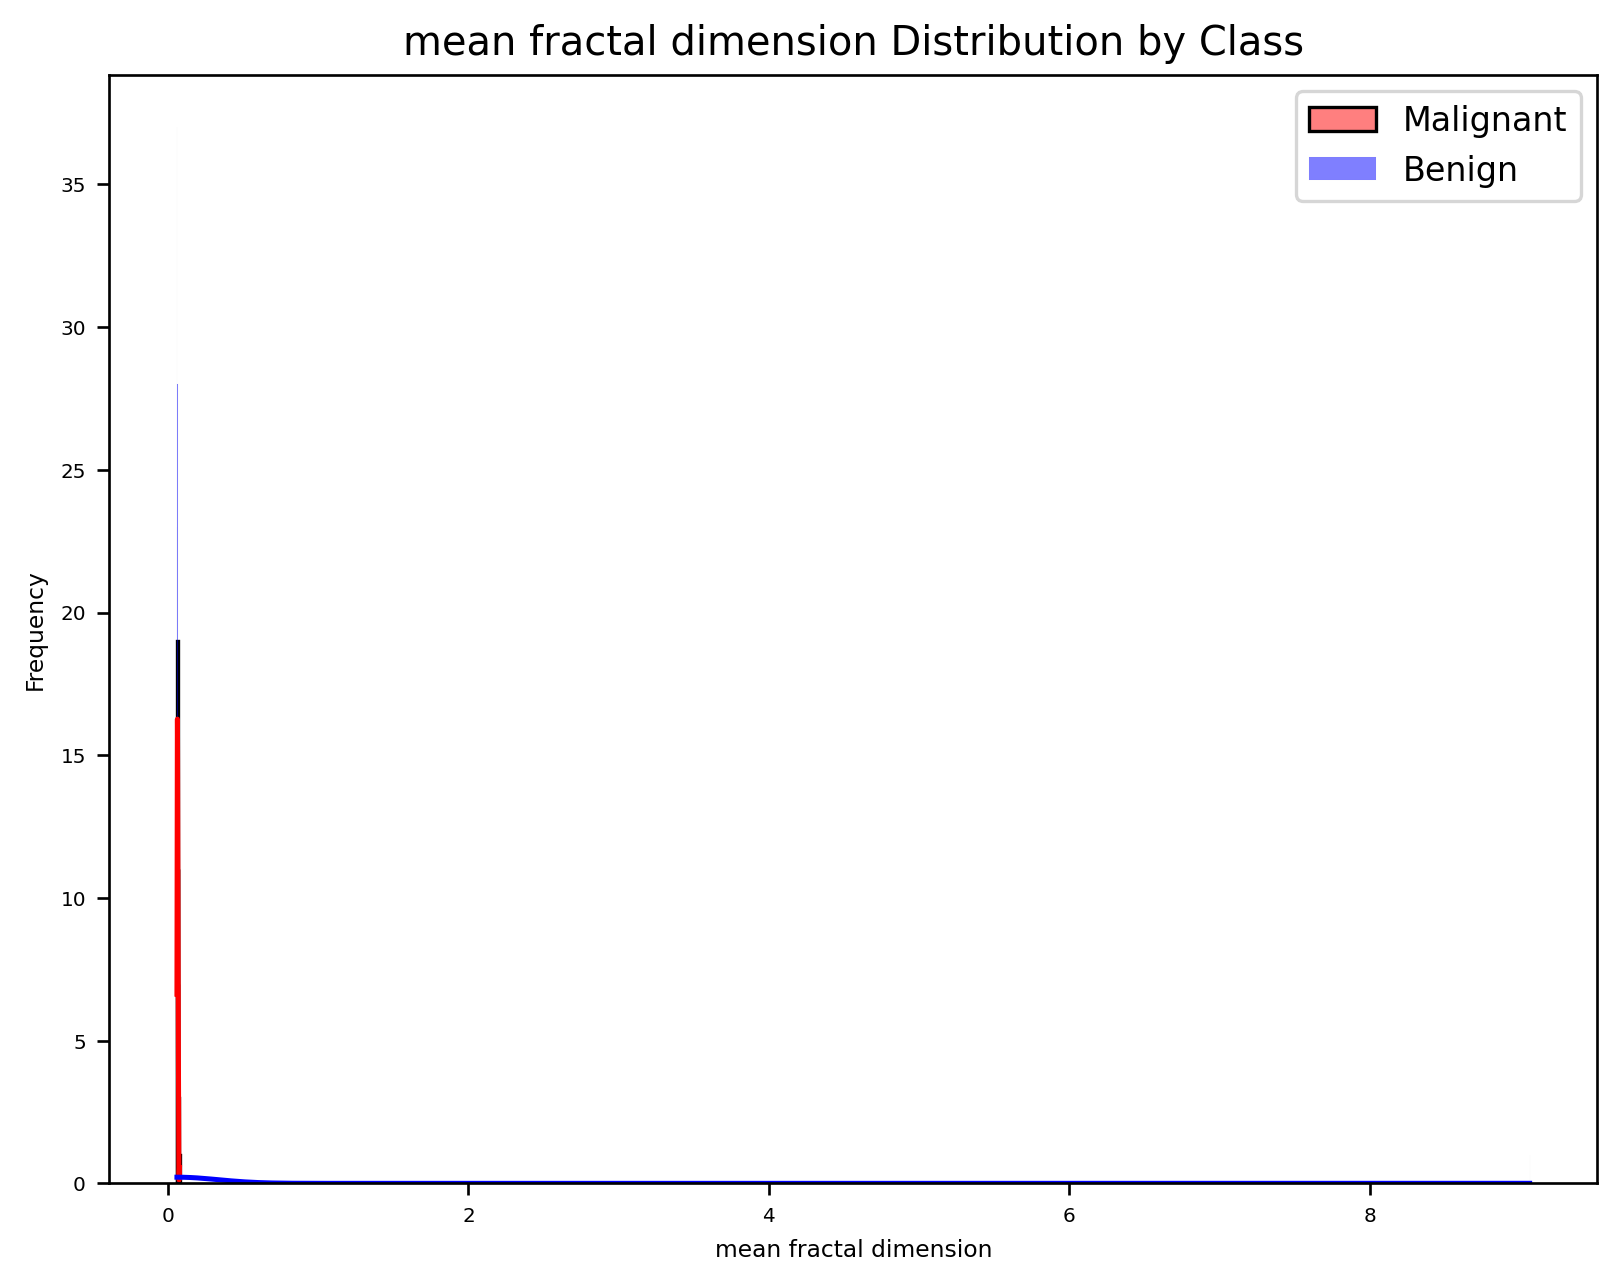

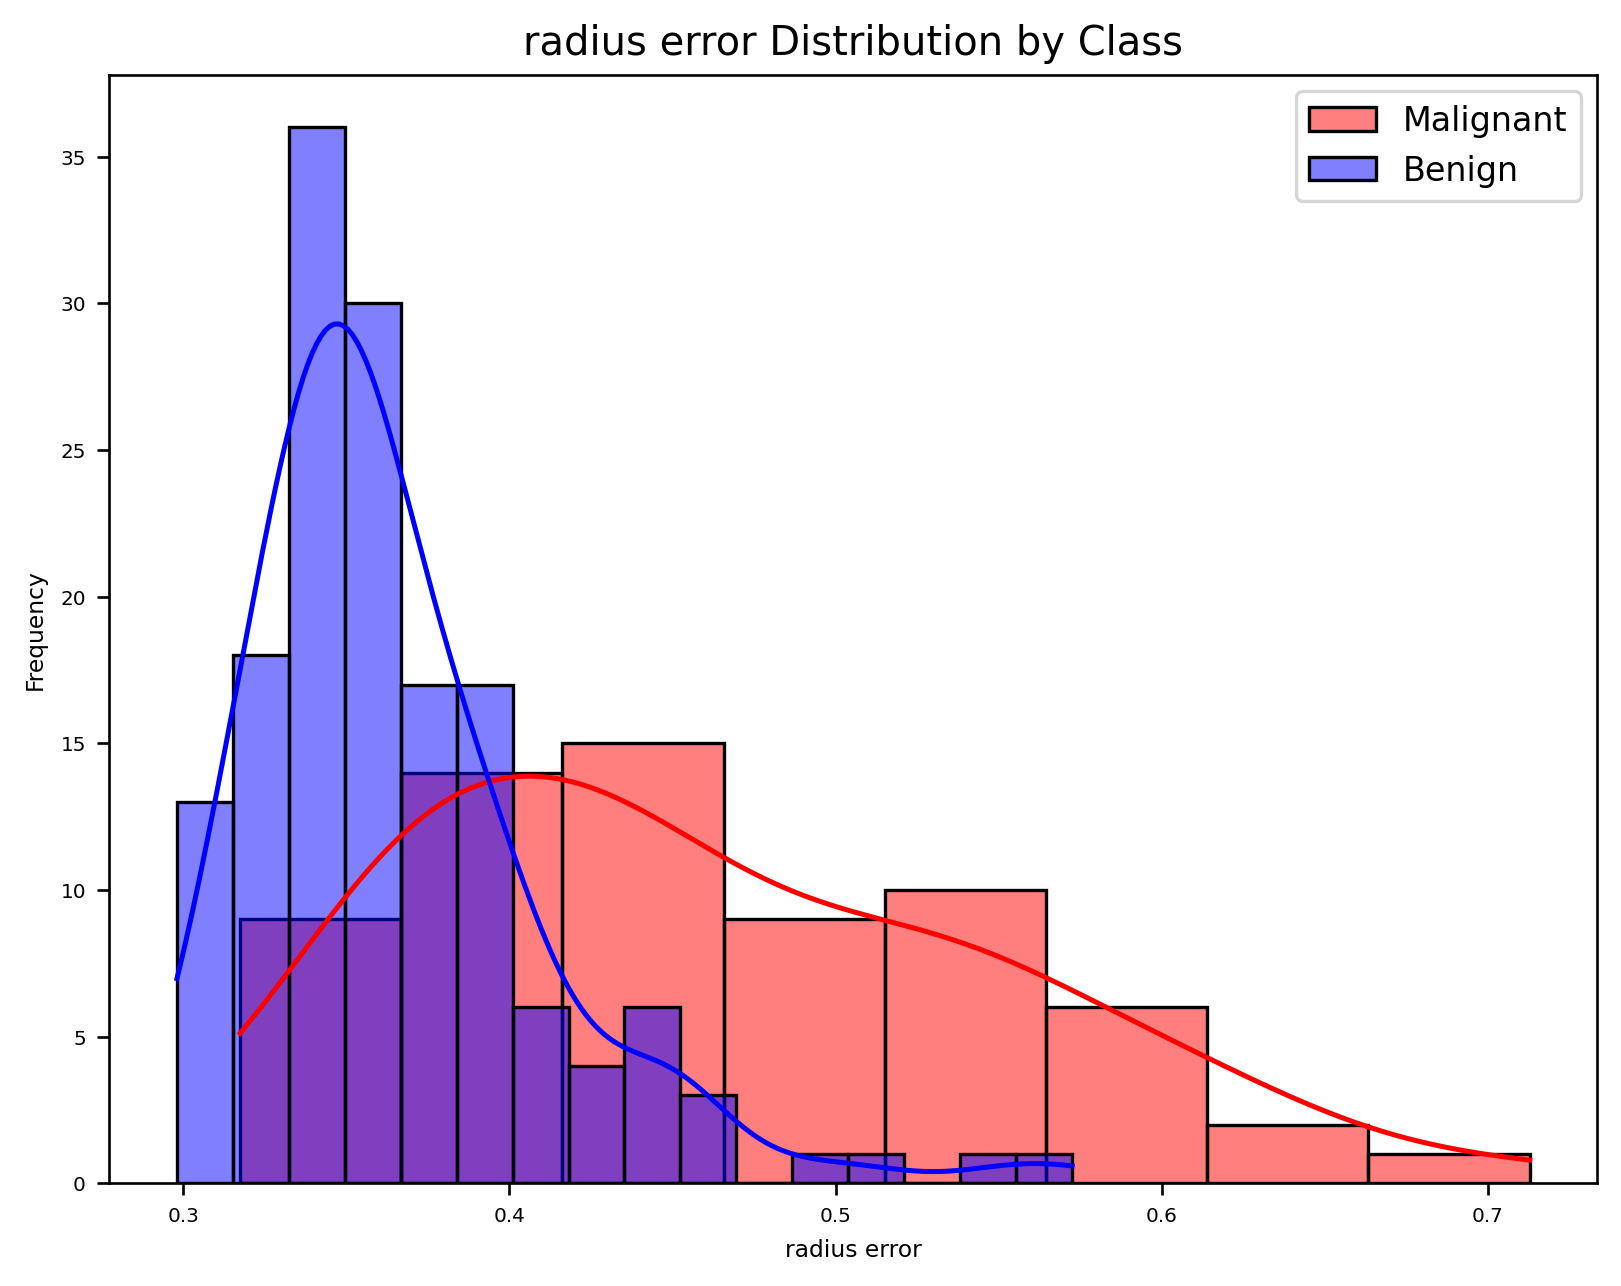

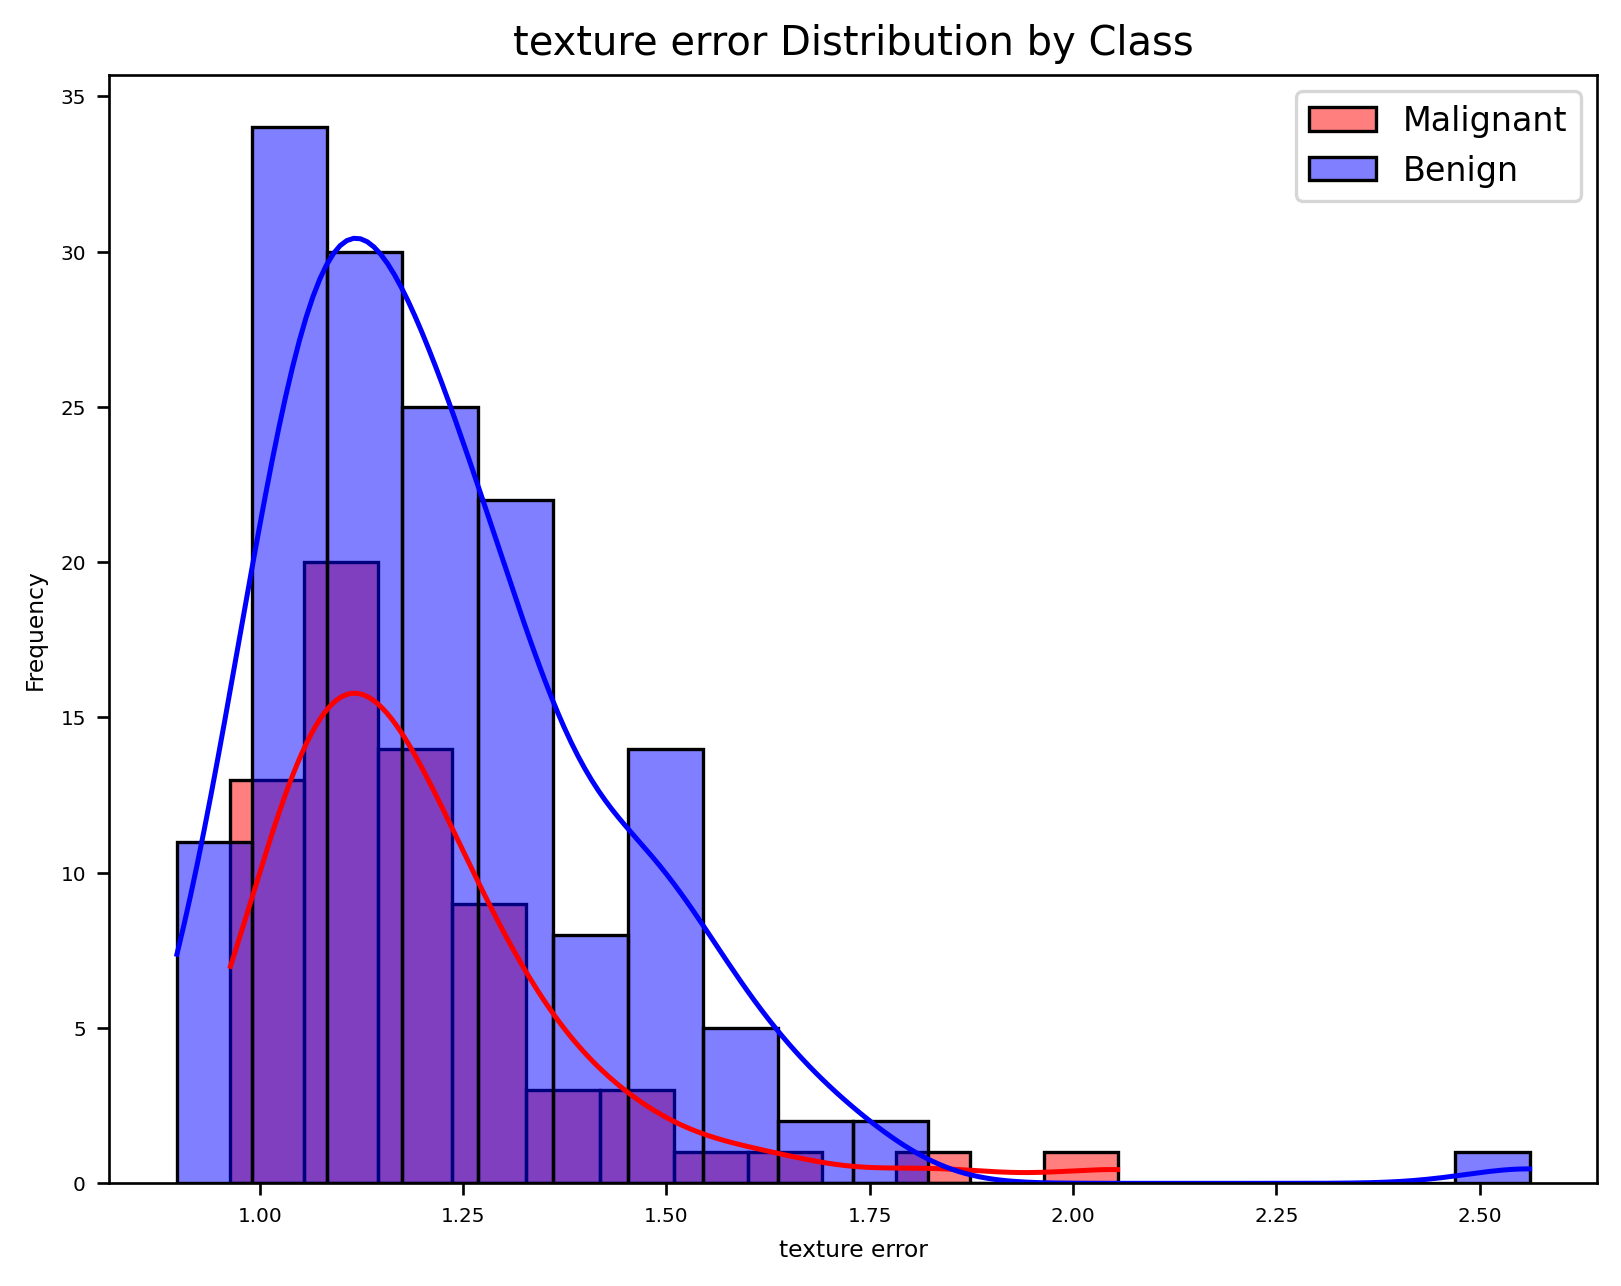

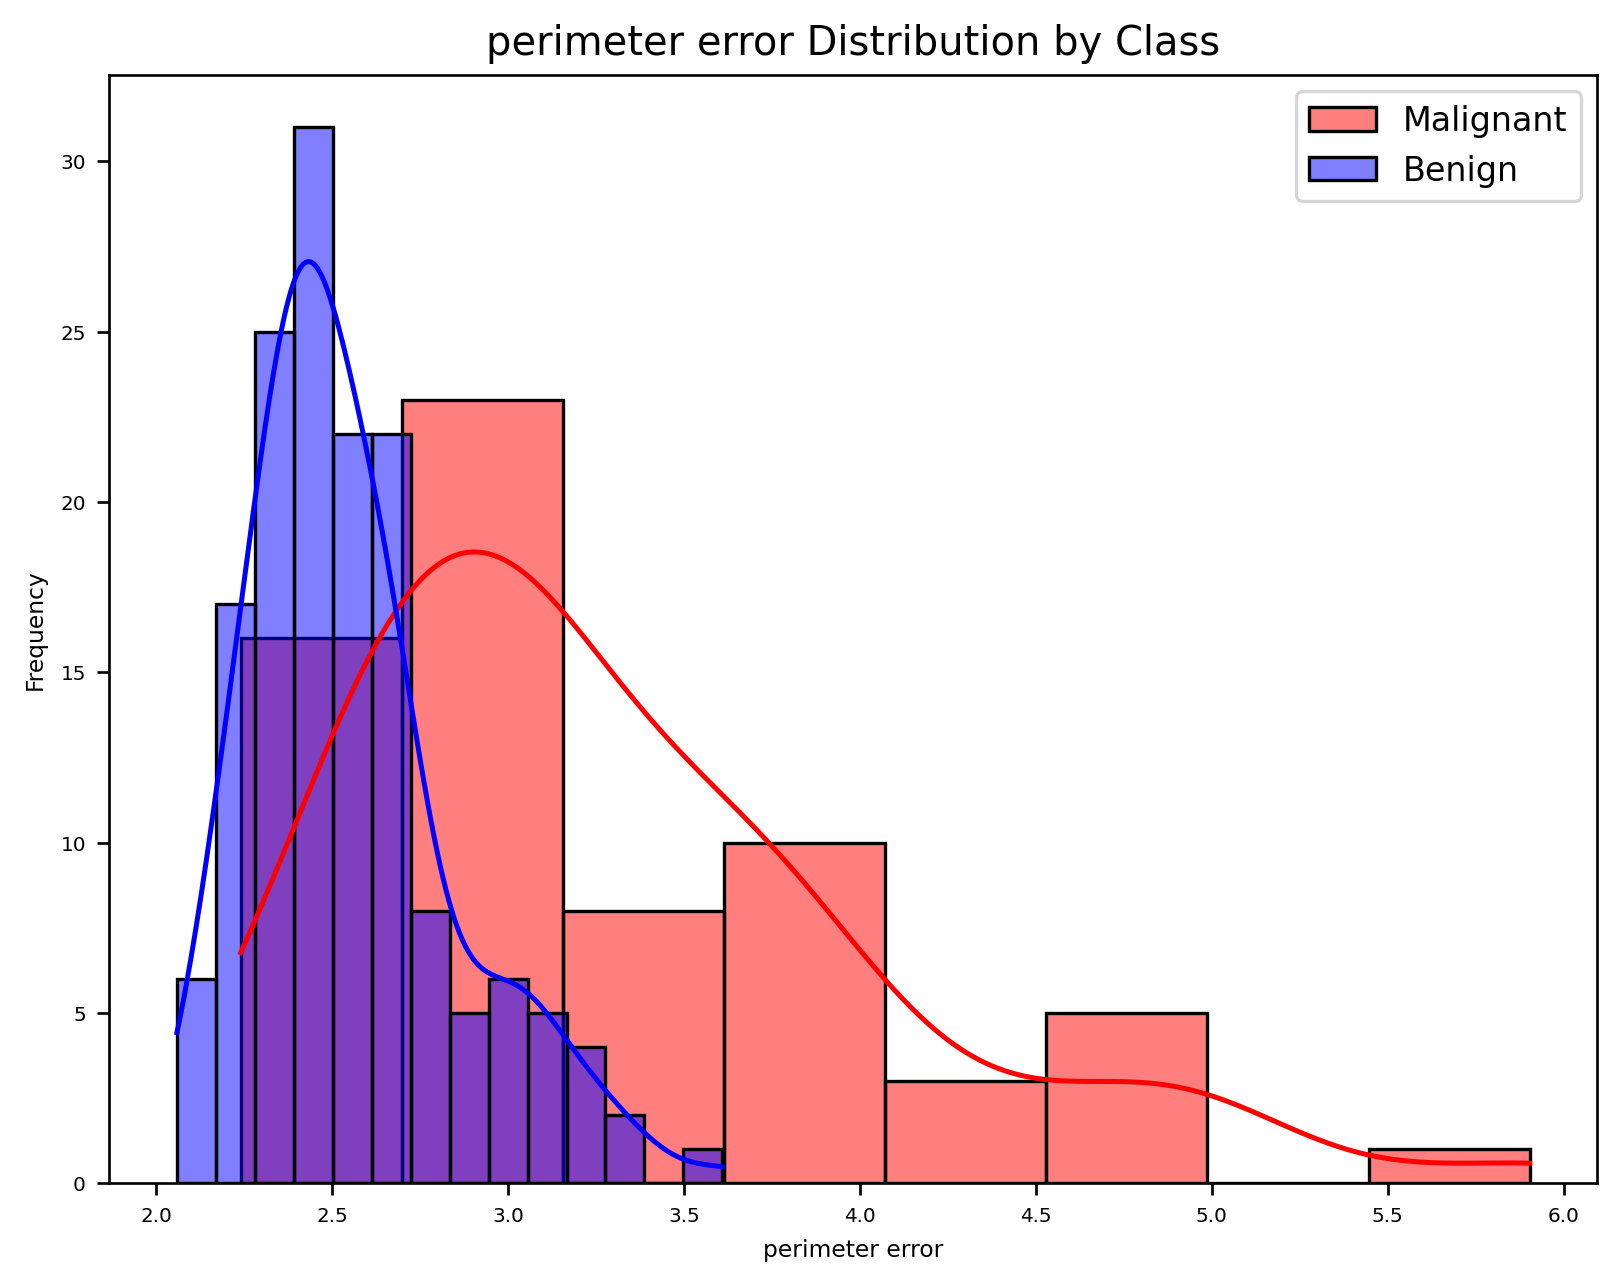

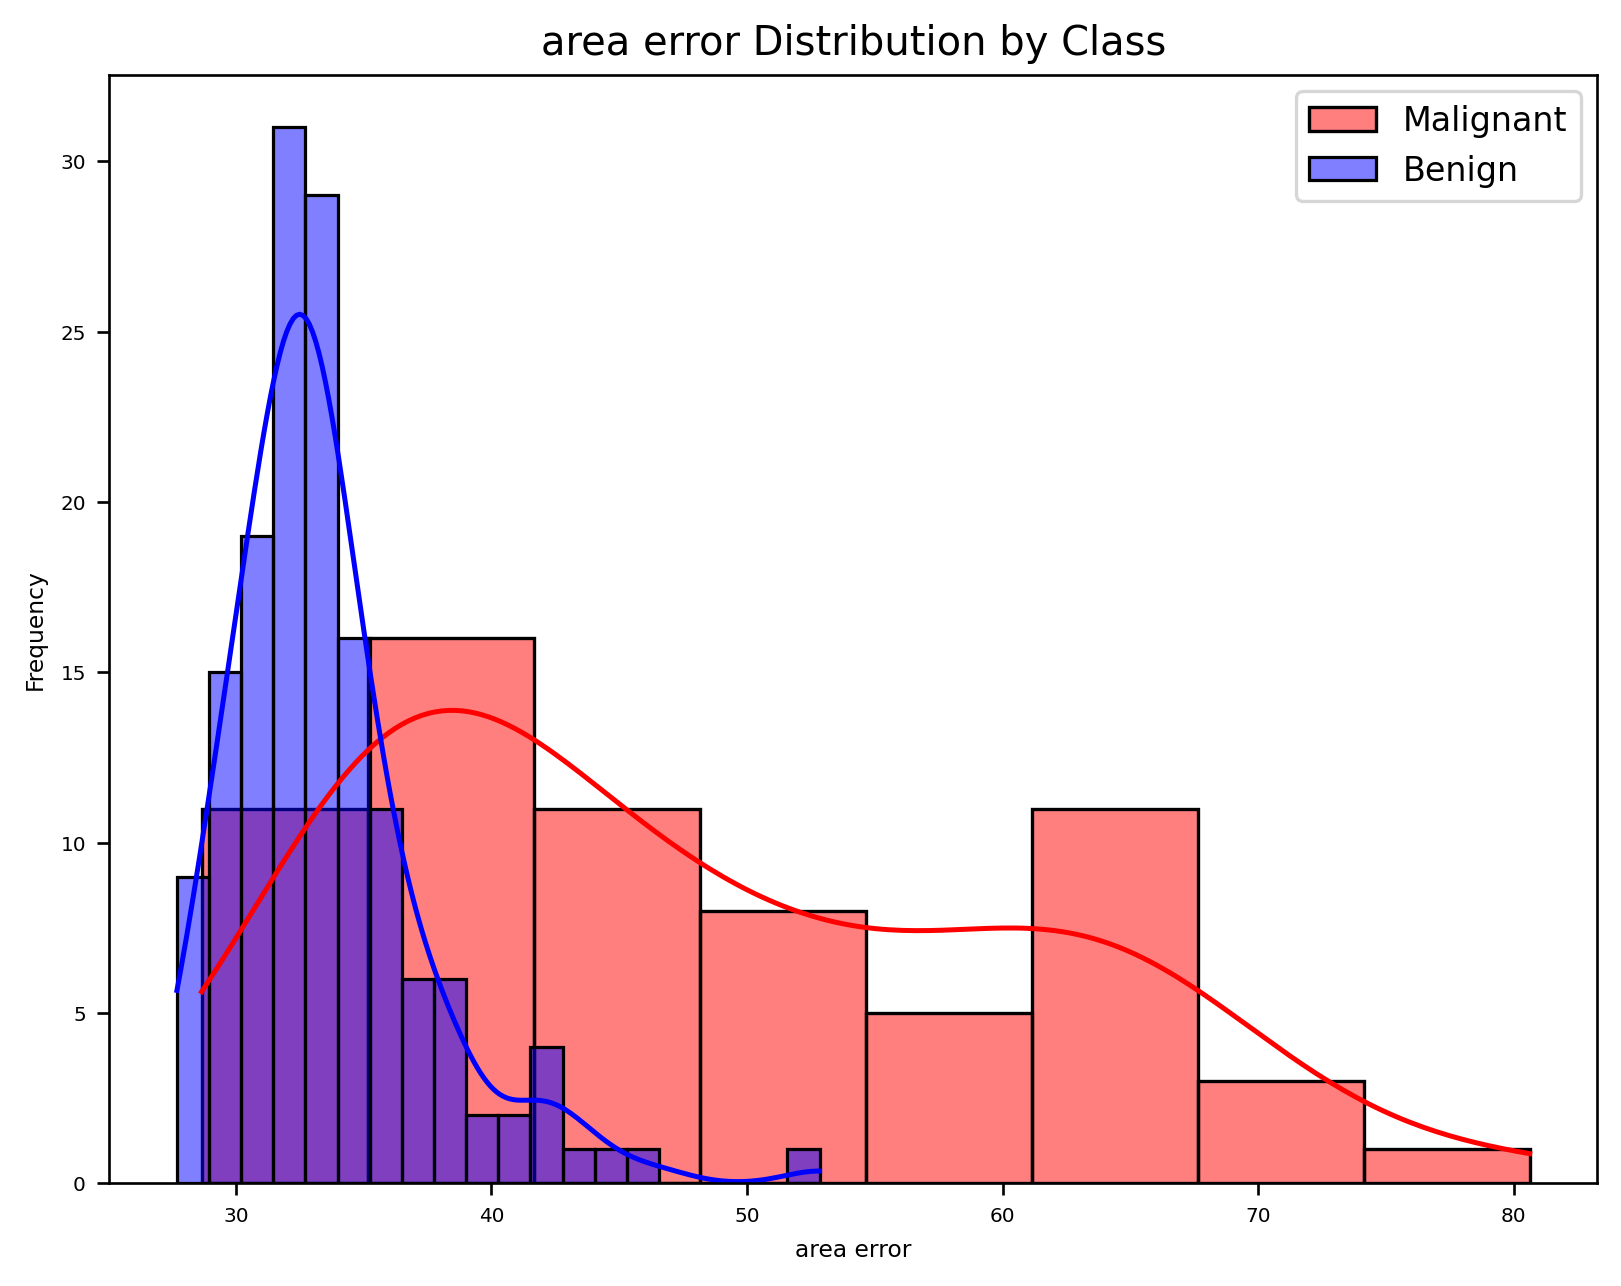

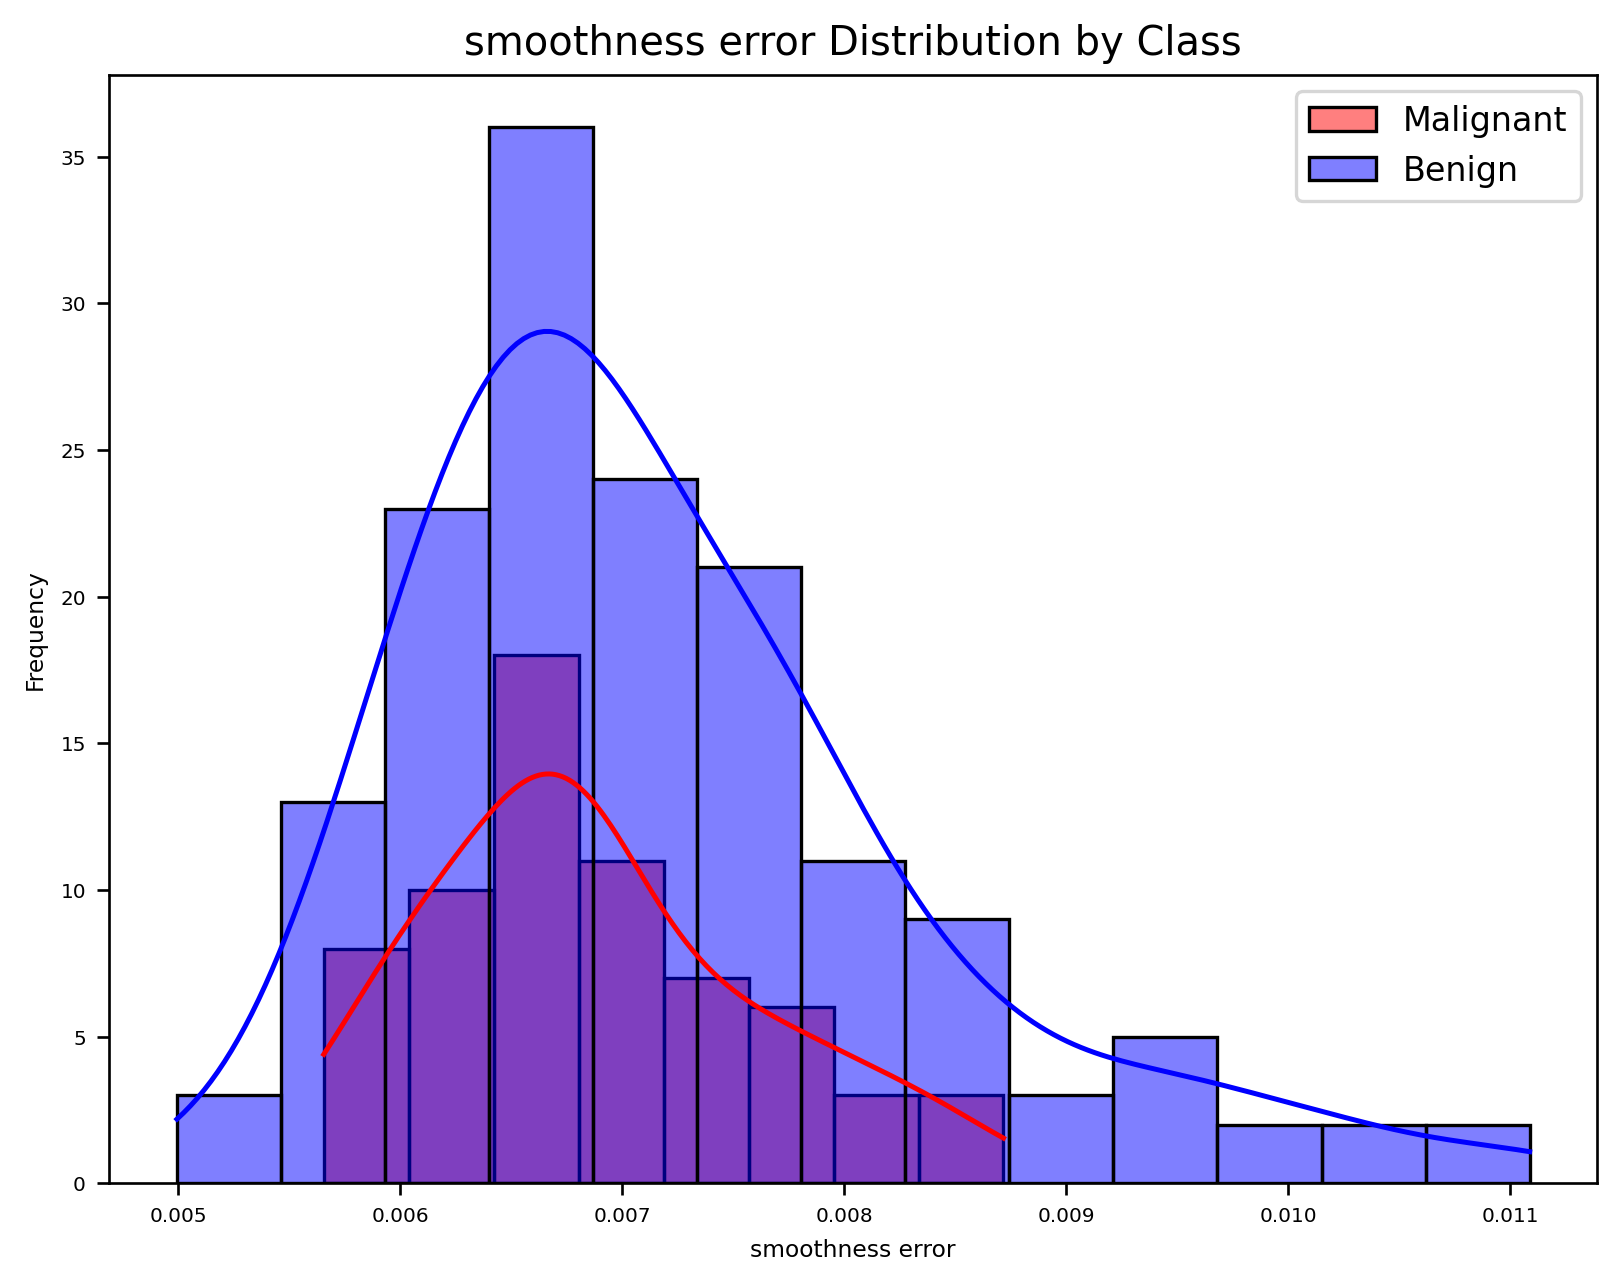

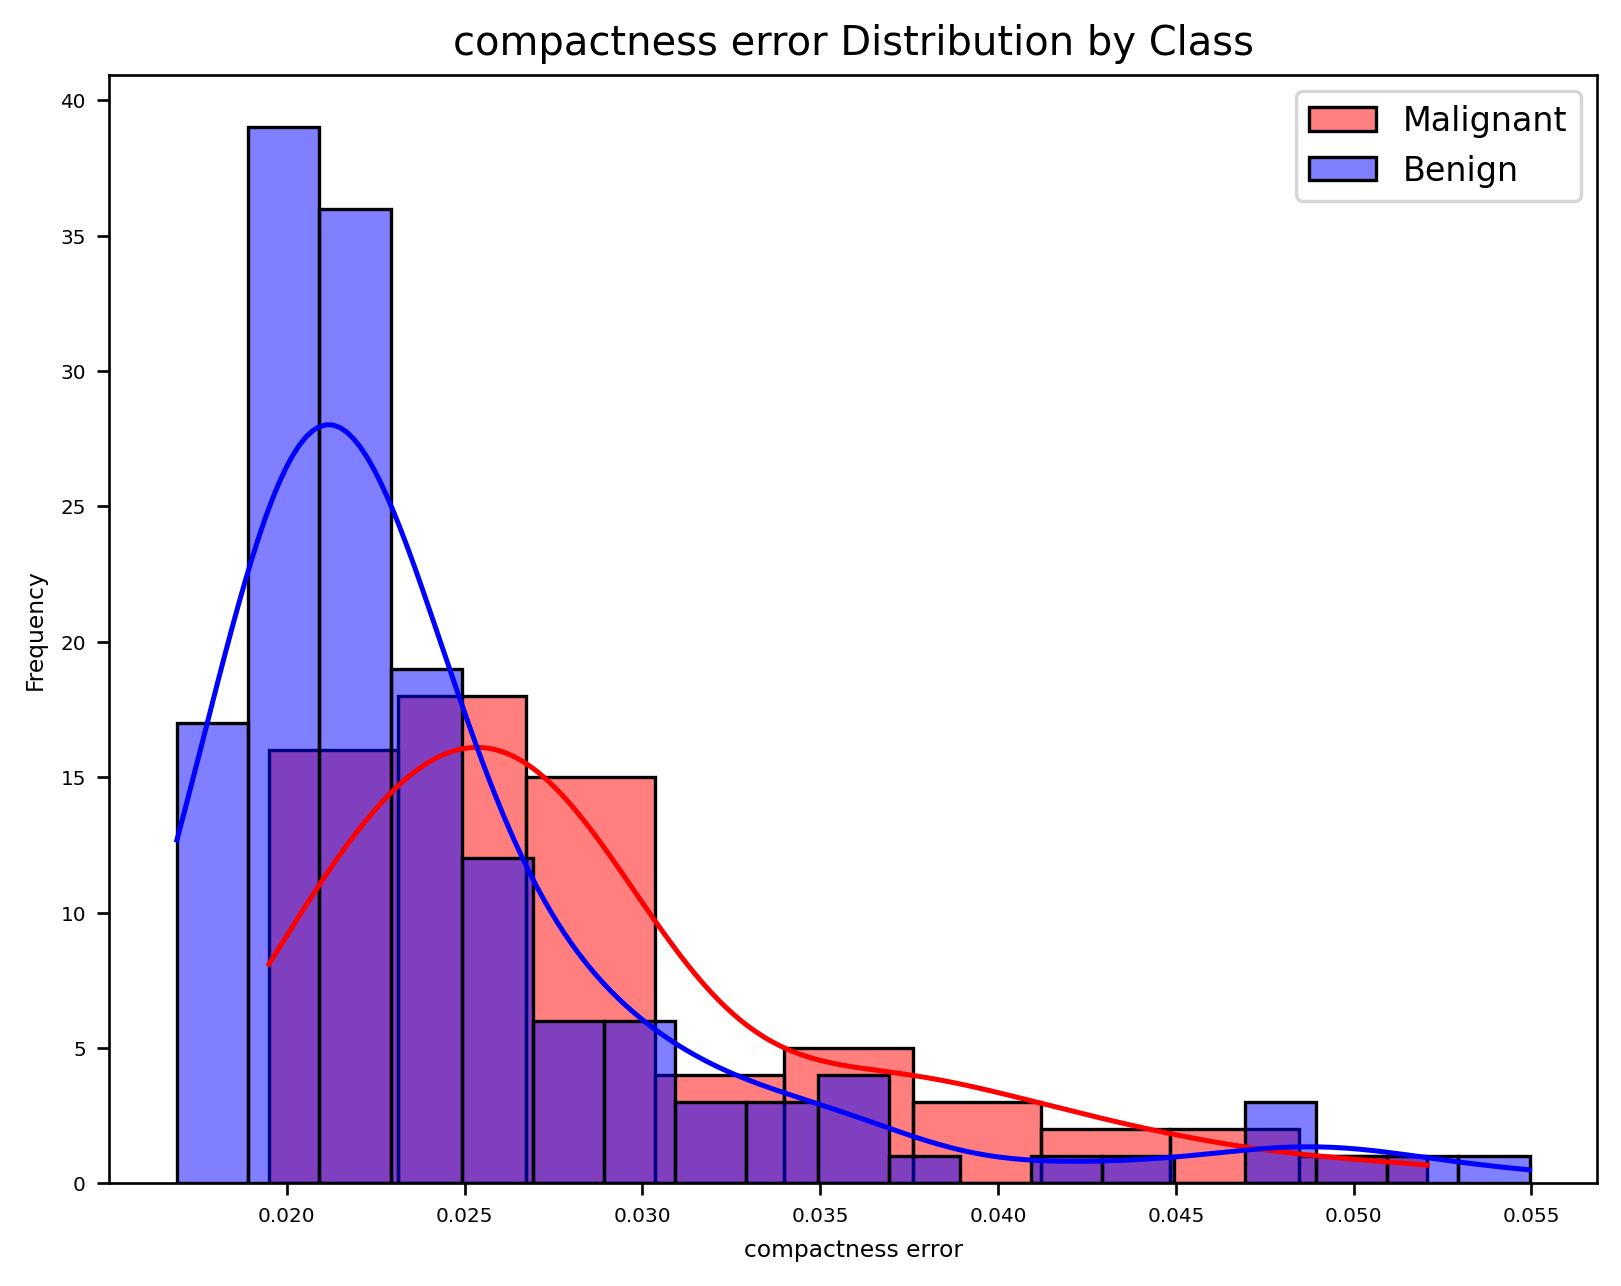

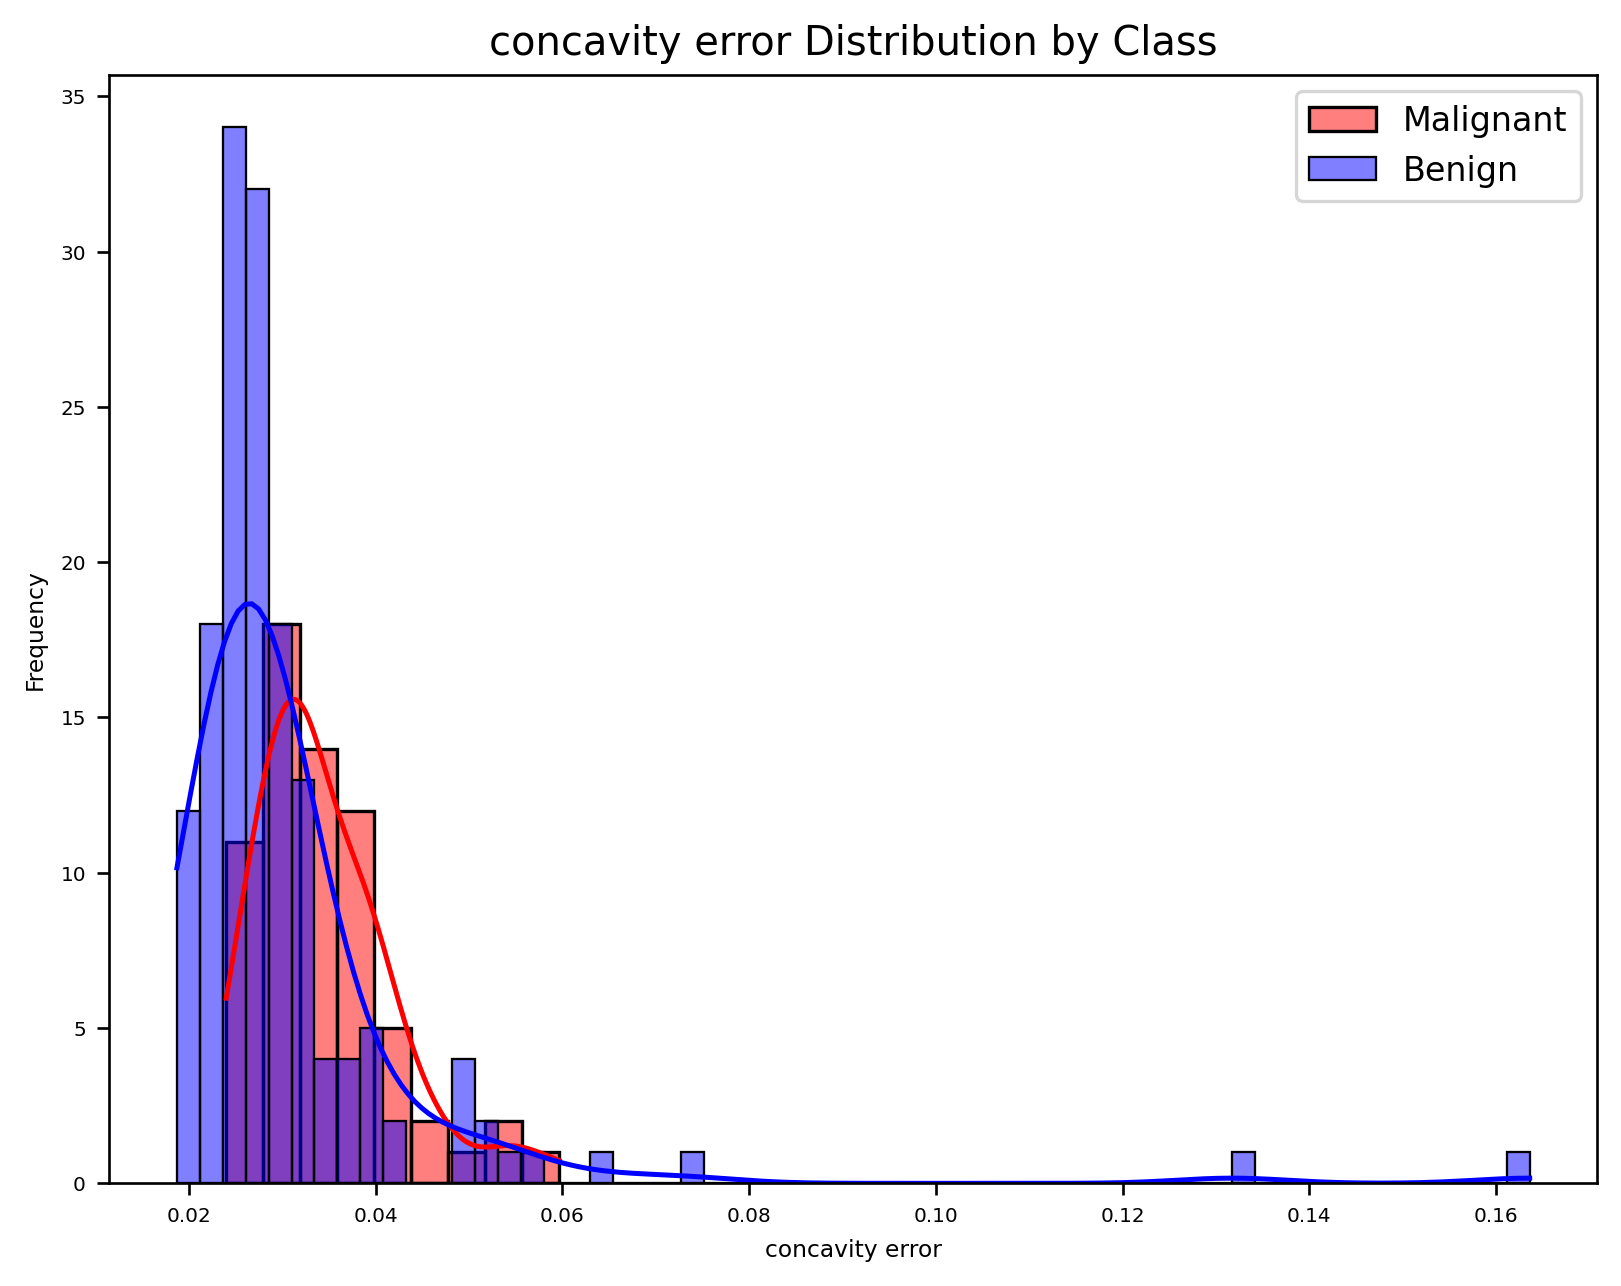

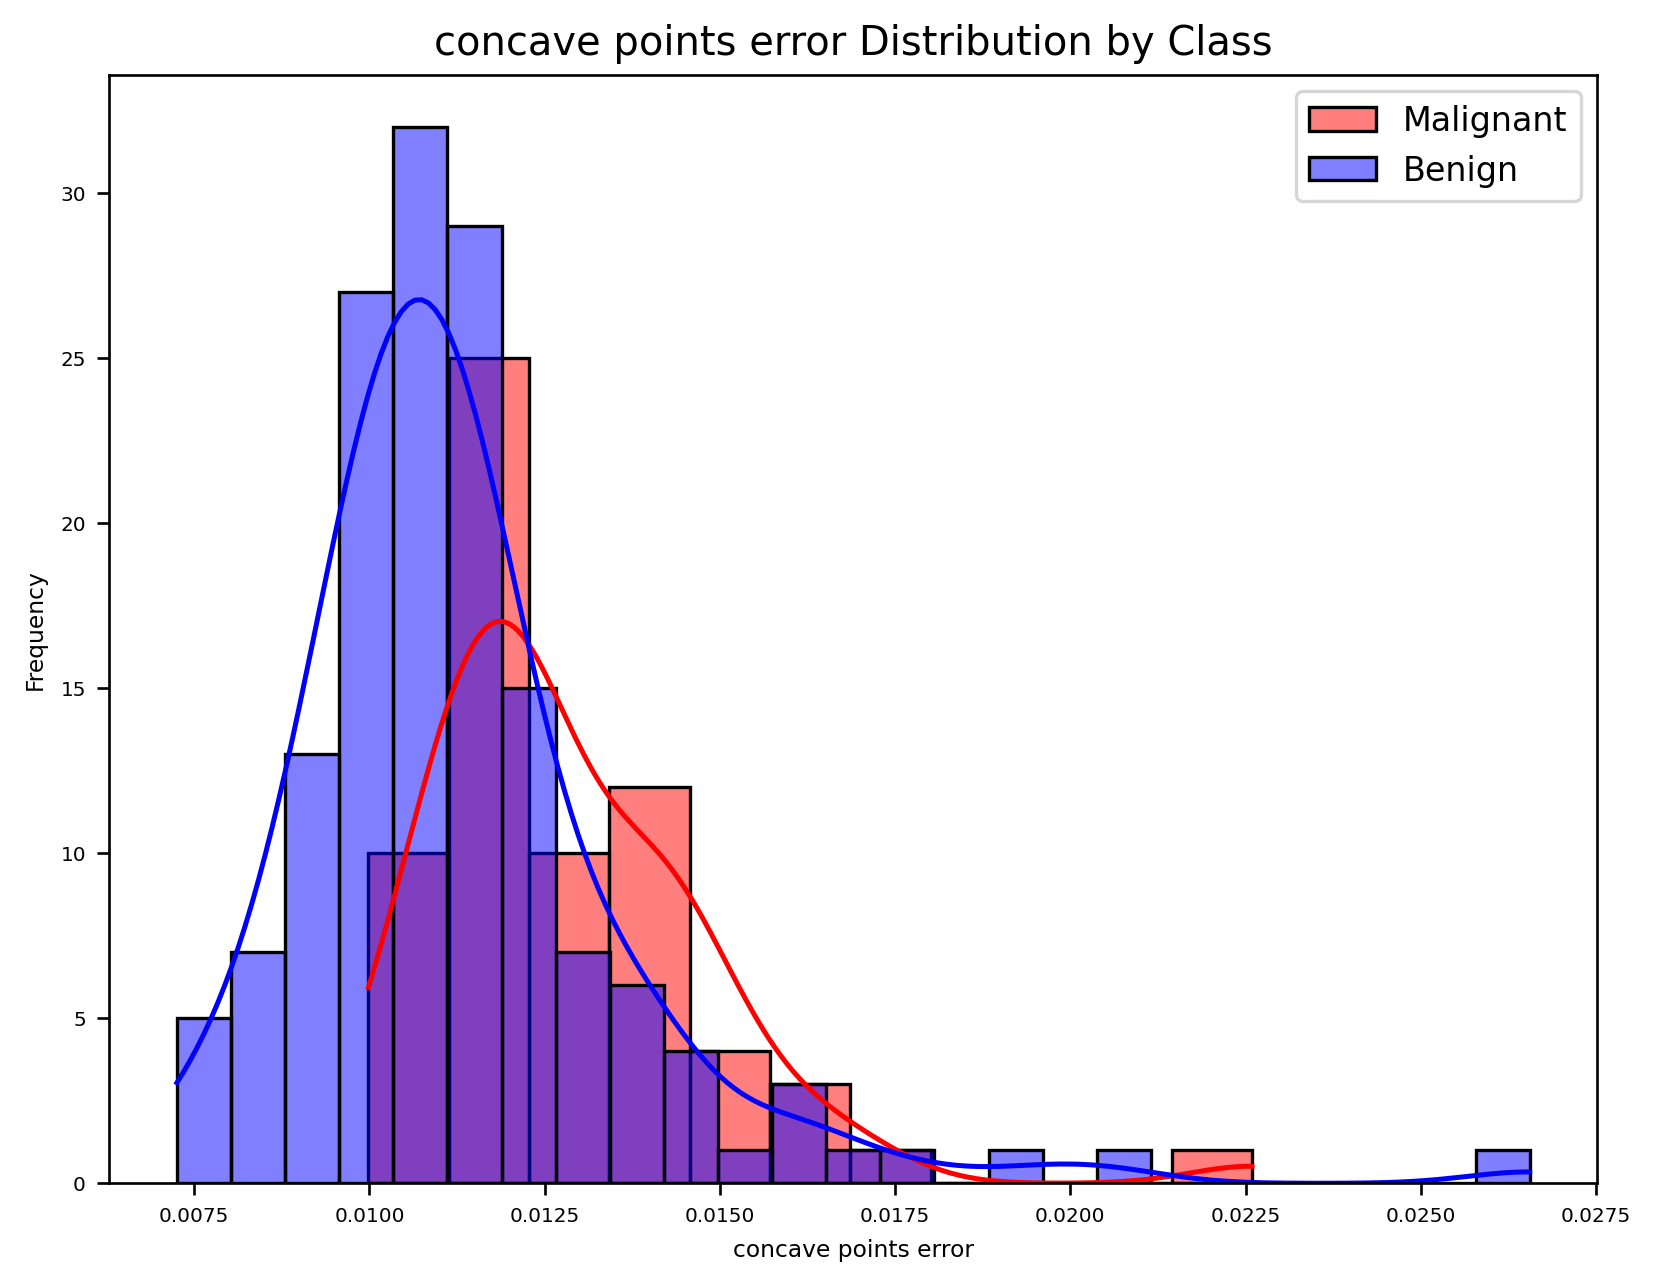

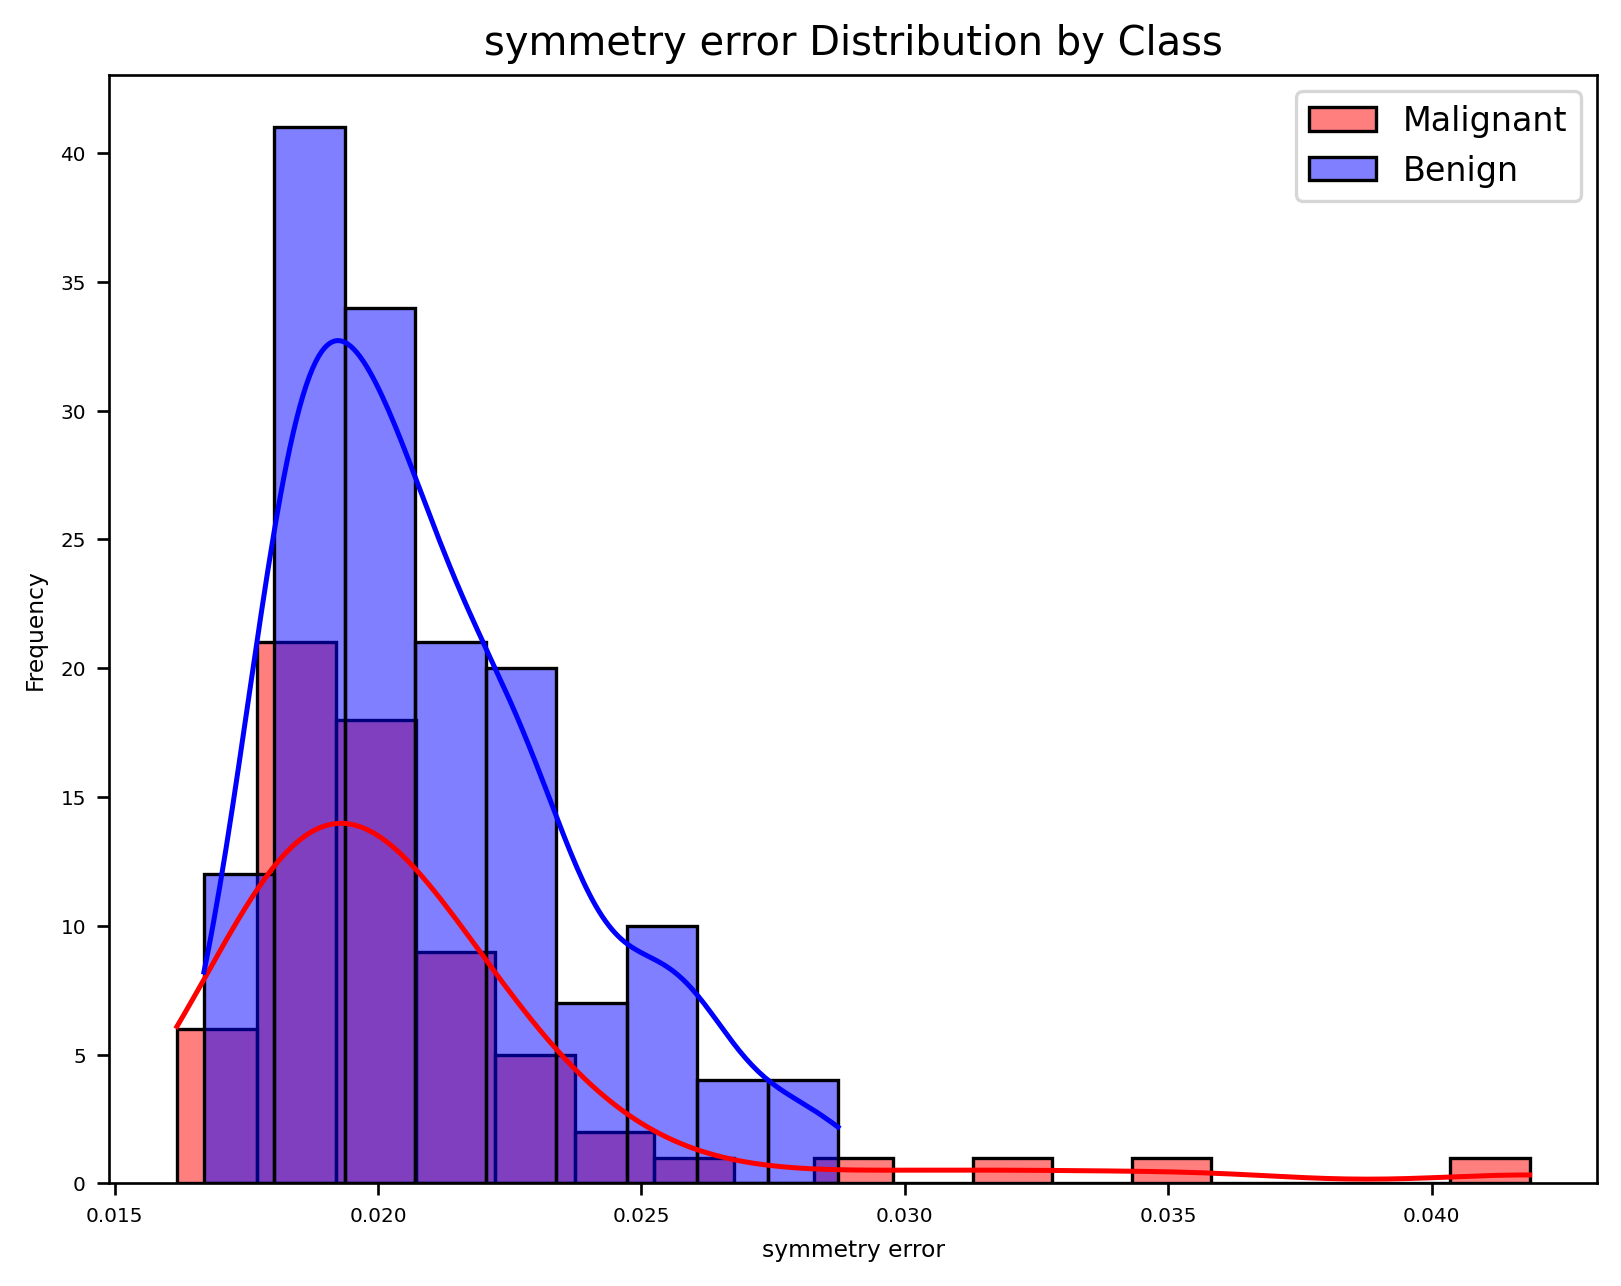

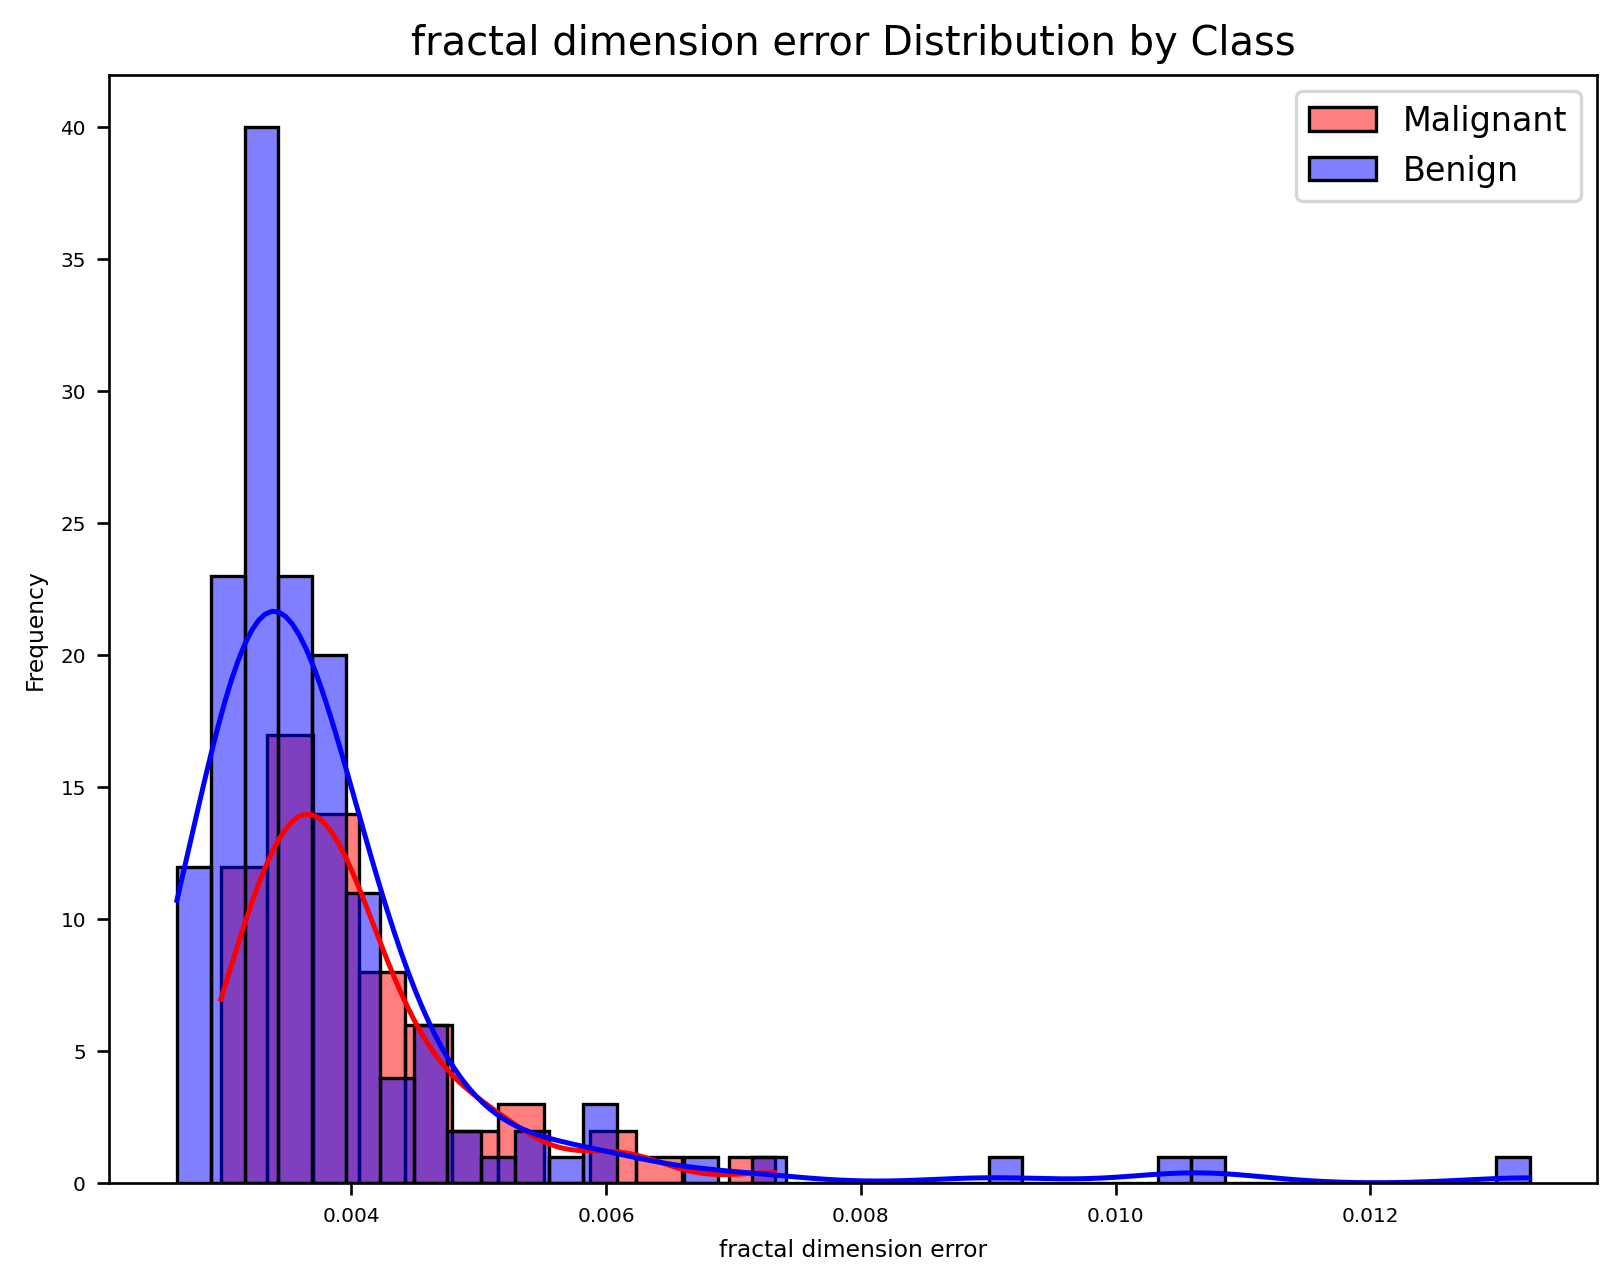

In [474]:
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.histplot(malignant_data[feature], color='red', label='Malignant', kde=True, alpha=0.5)
    sns.histplot(benign_data[feature], color='blue', label='Benign', kde=True, alpha=0.5)
    plt.title(f'{feature} Distribution by Class')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

This code plots scatter plots for each feature, distinguishing between 'malignant' and 'benign' classes by coloring data points accordingly (red for 'malignant' and blue for 'benign'), with enhanced labels, legends, and overall plot layout adjustments. This is for the purpose of visualising outliers

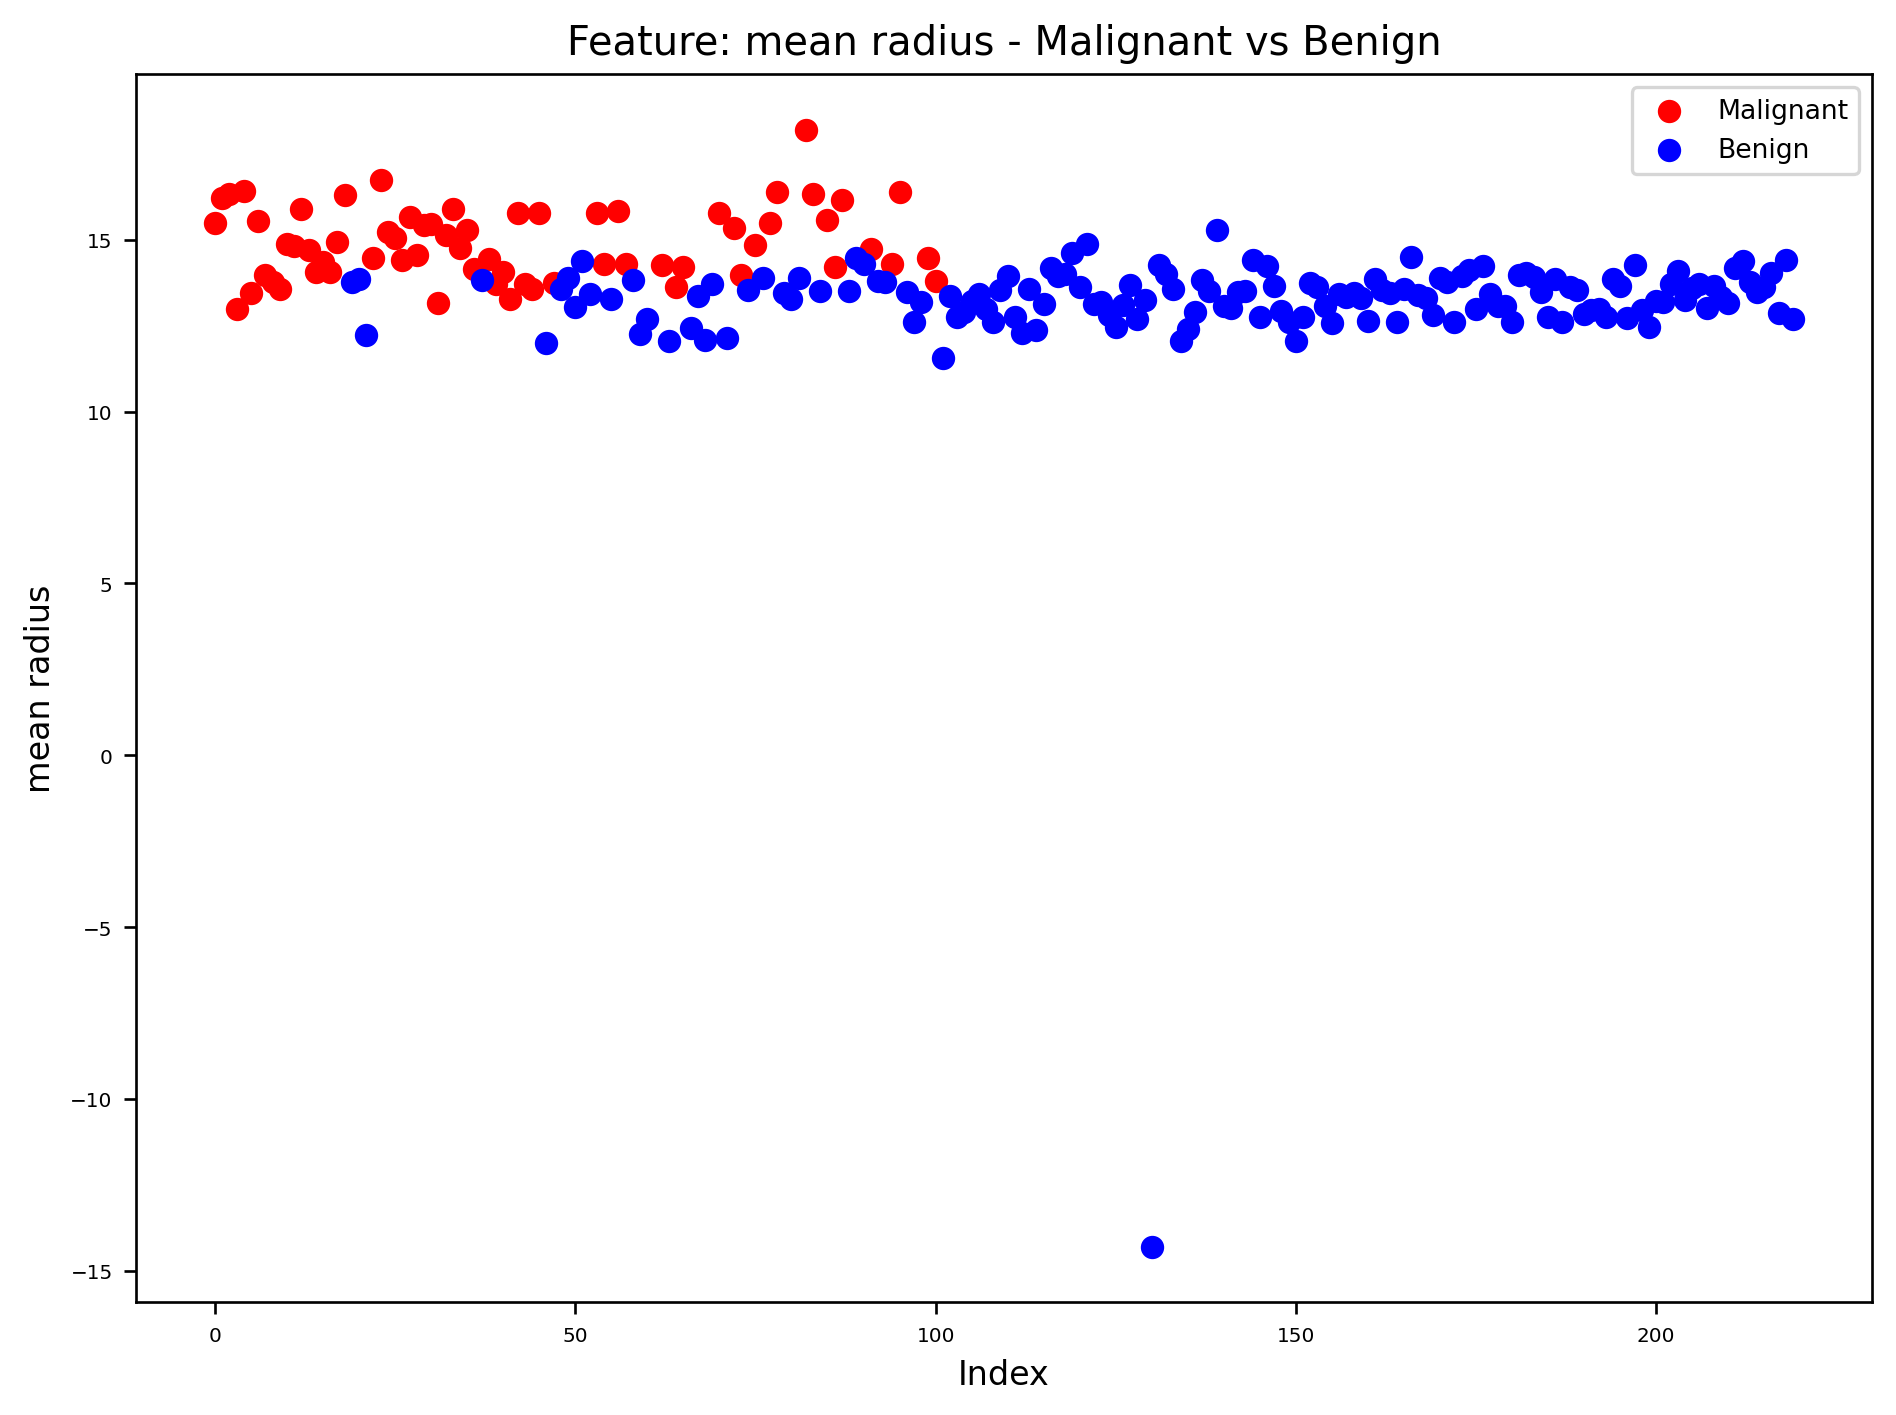

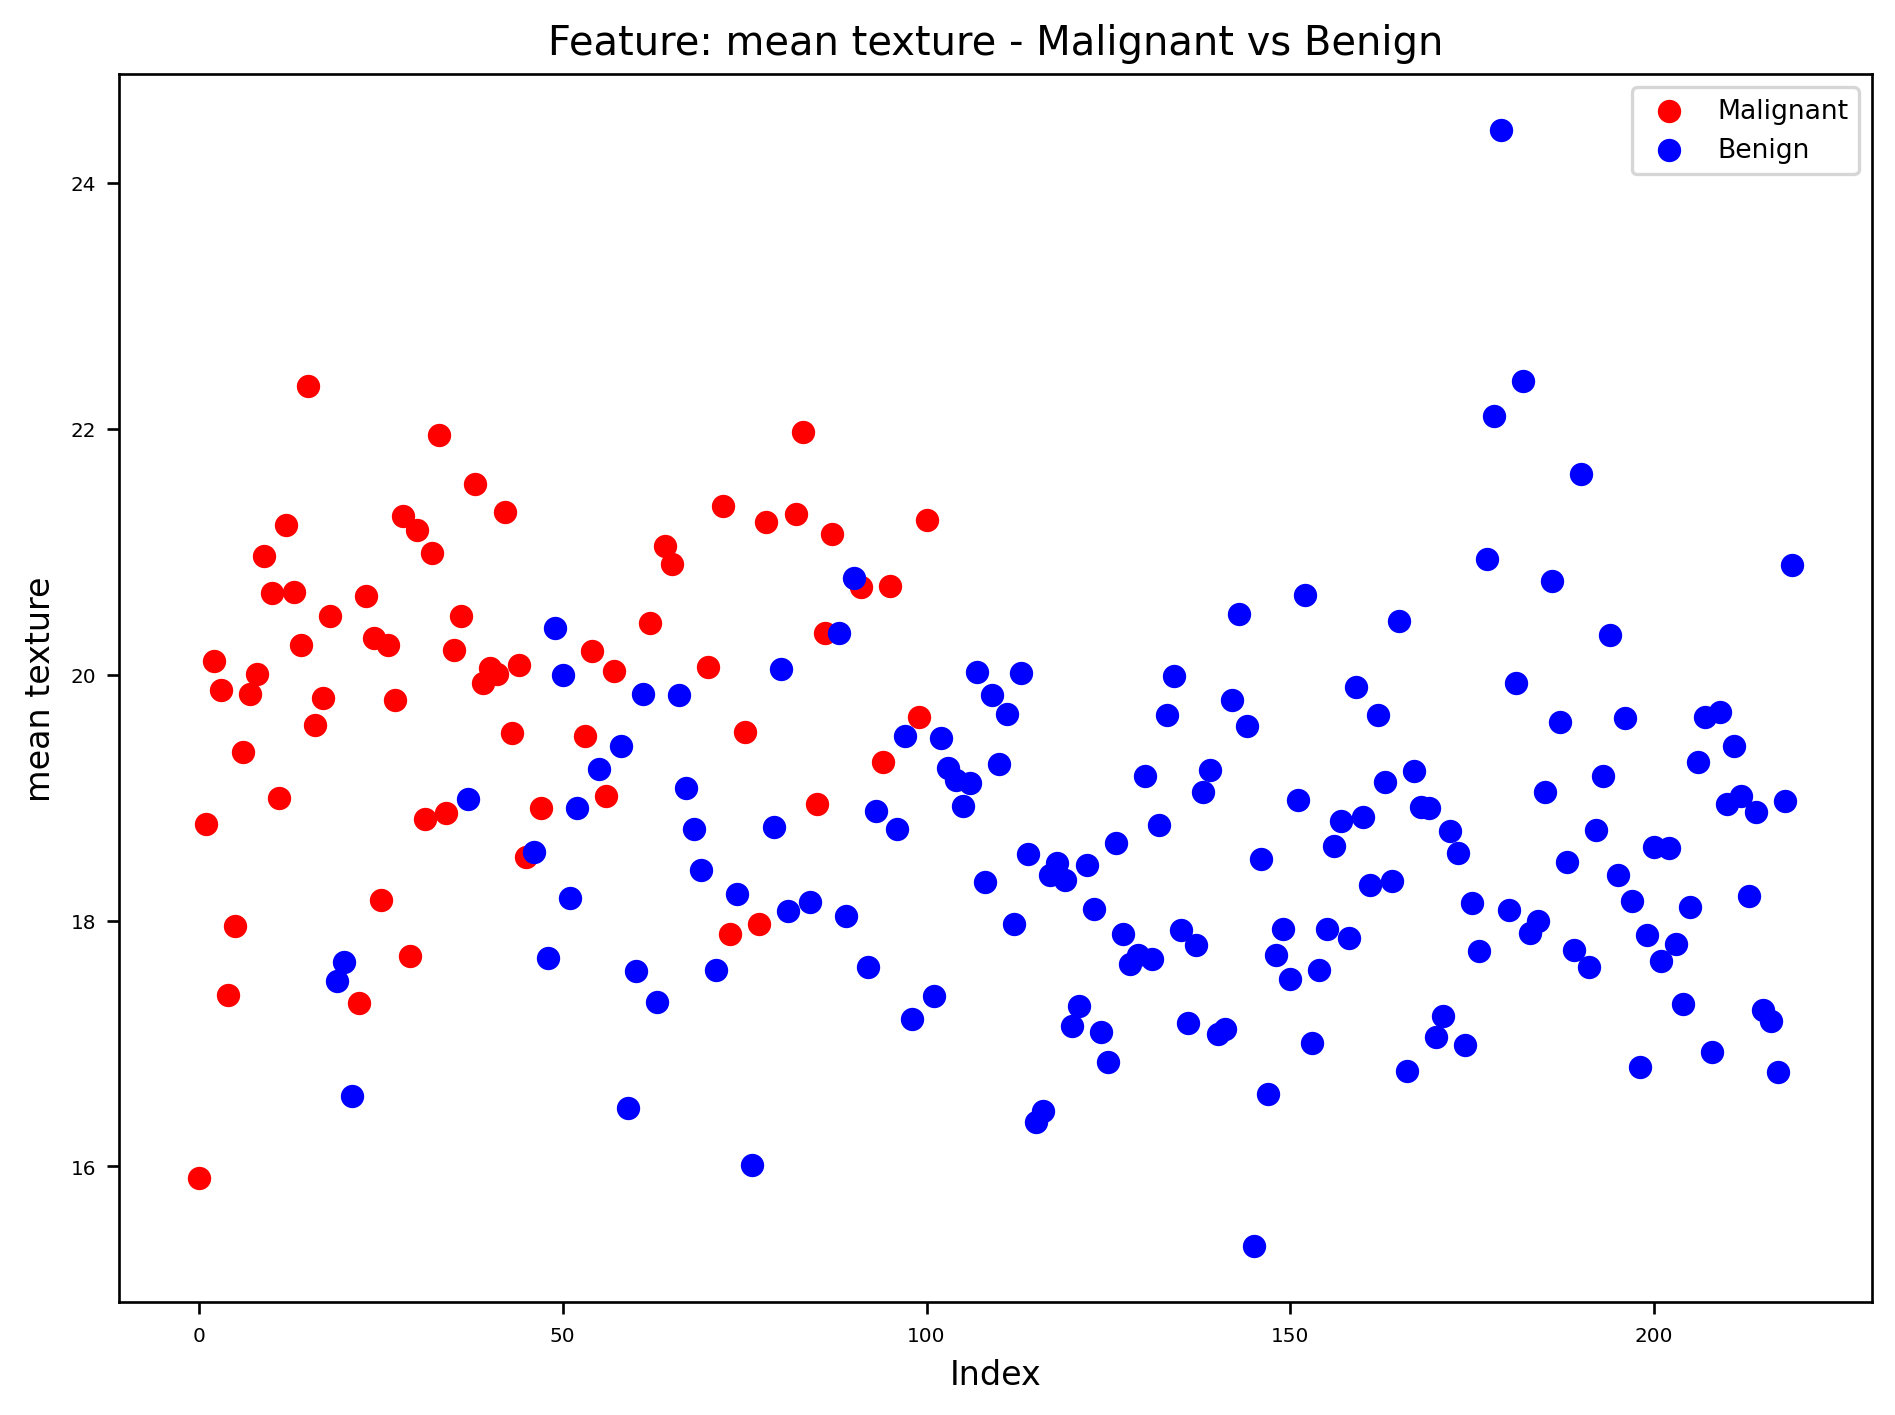

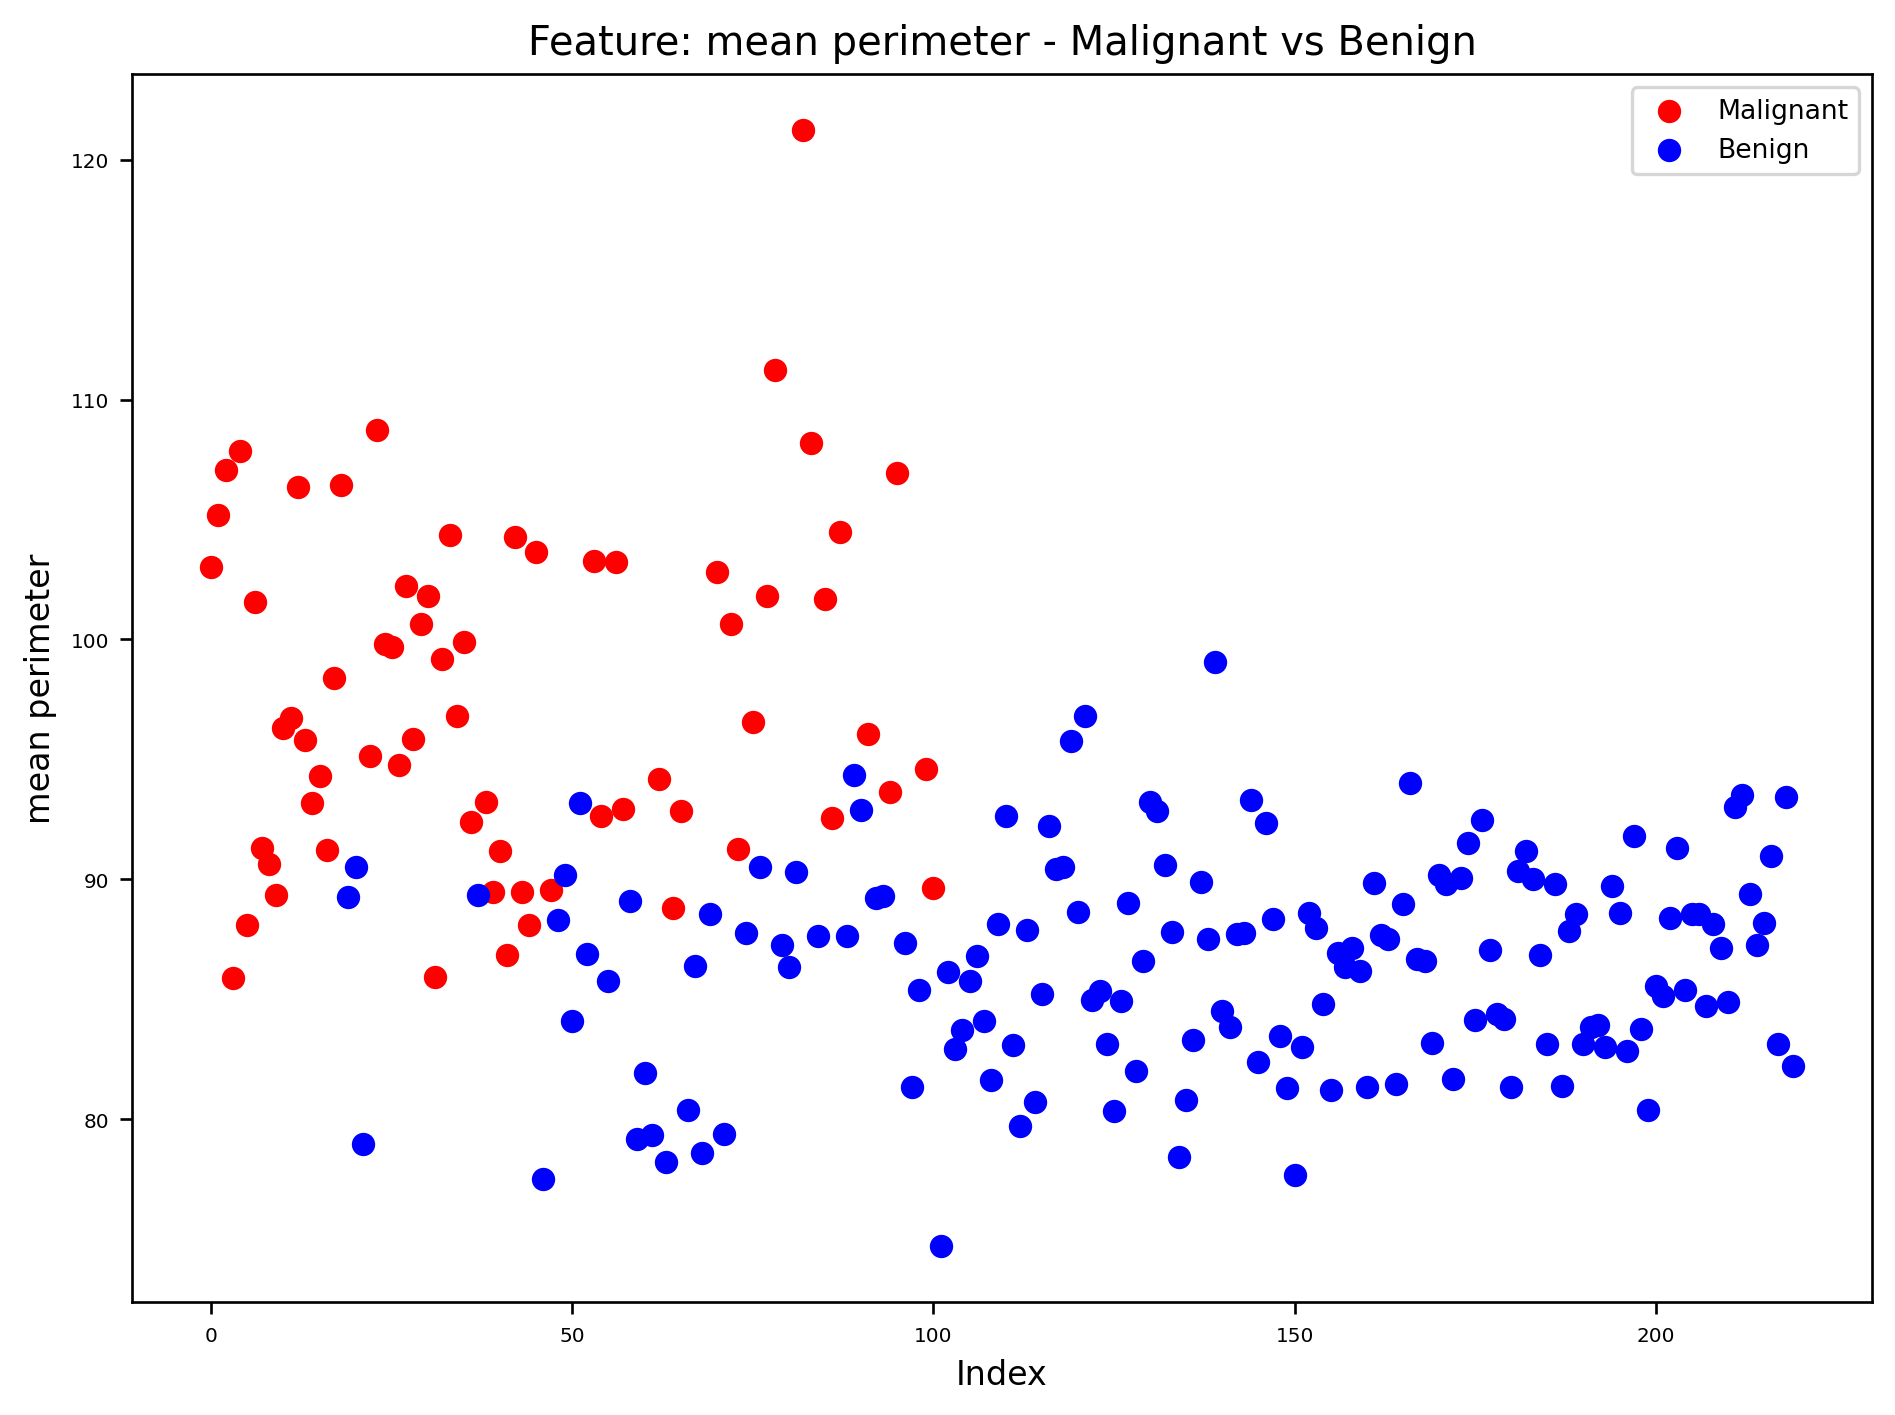

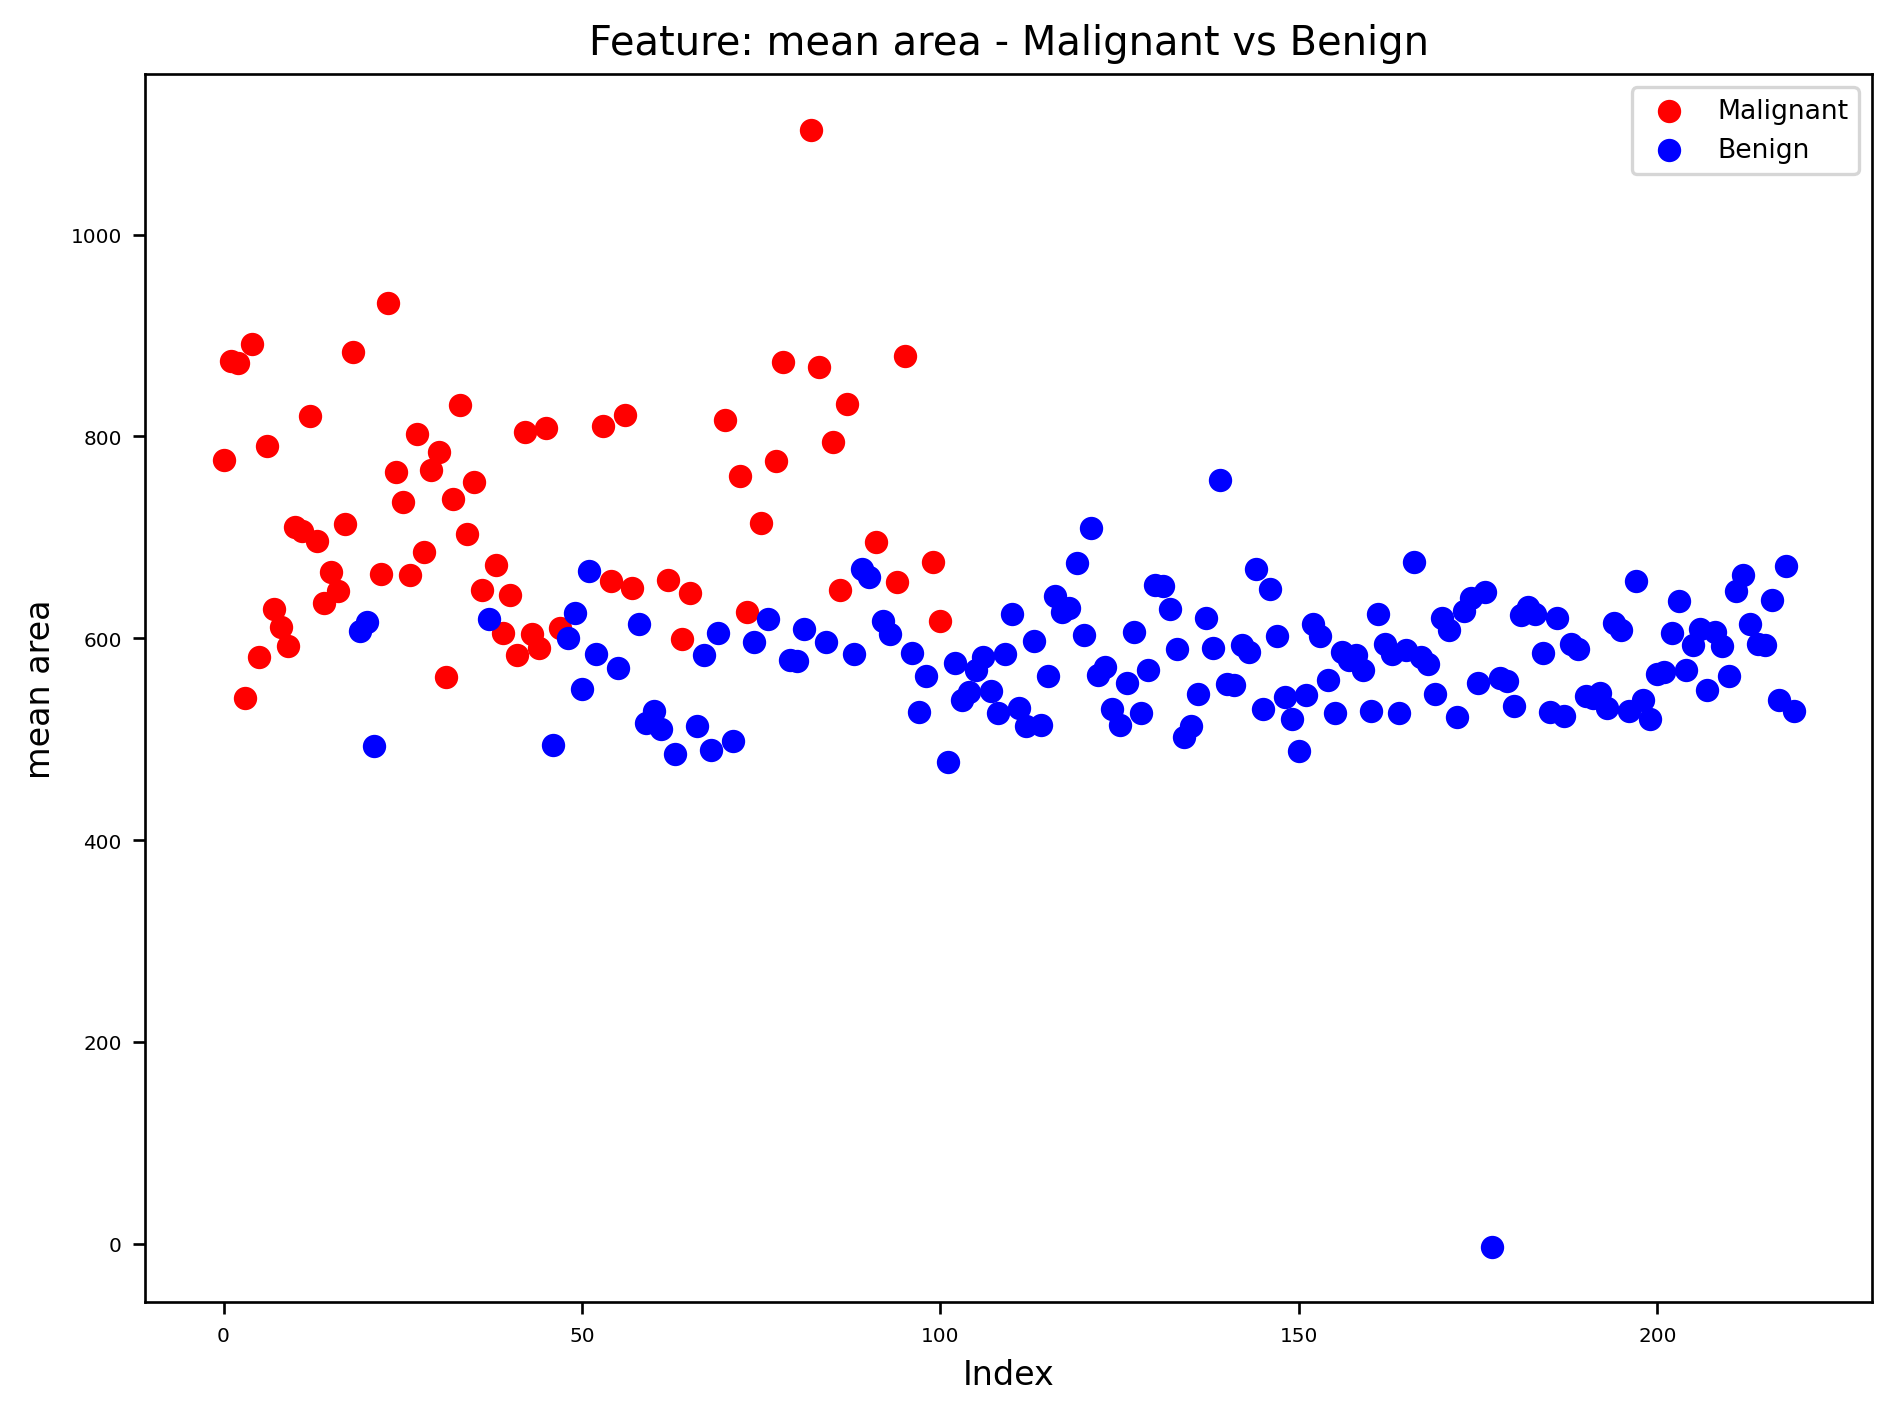

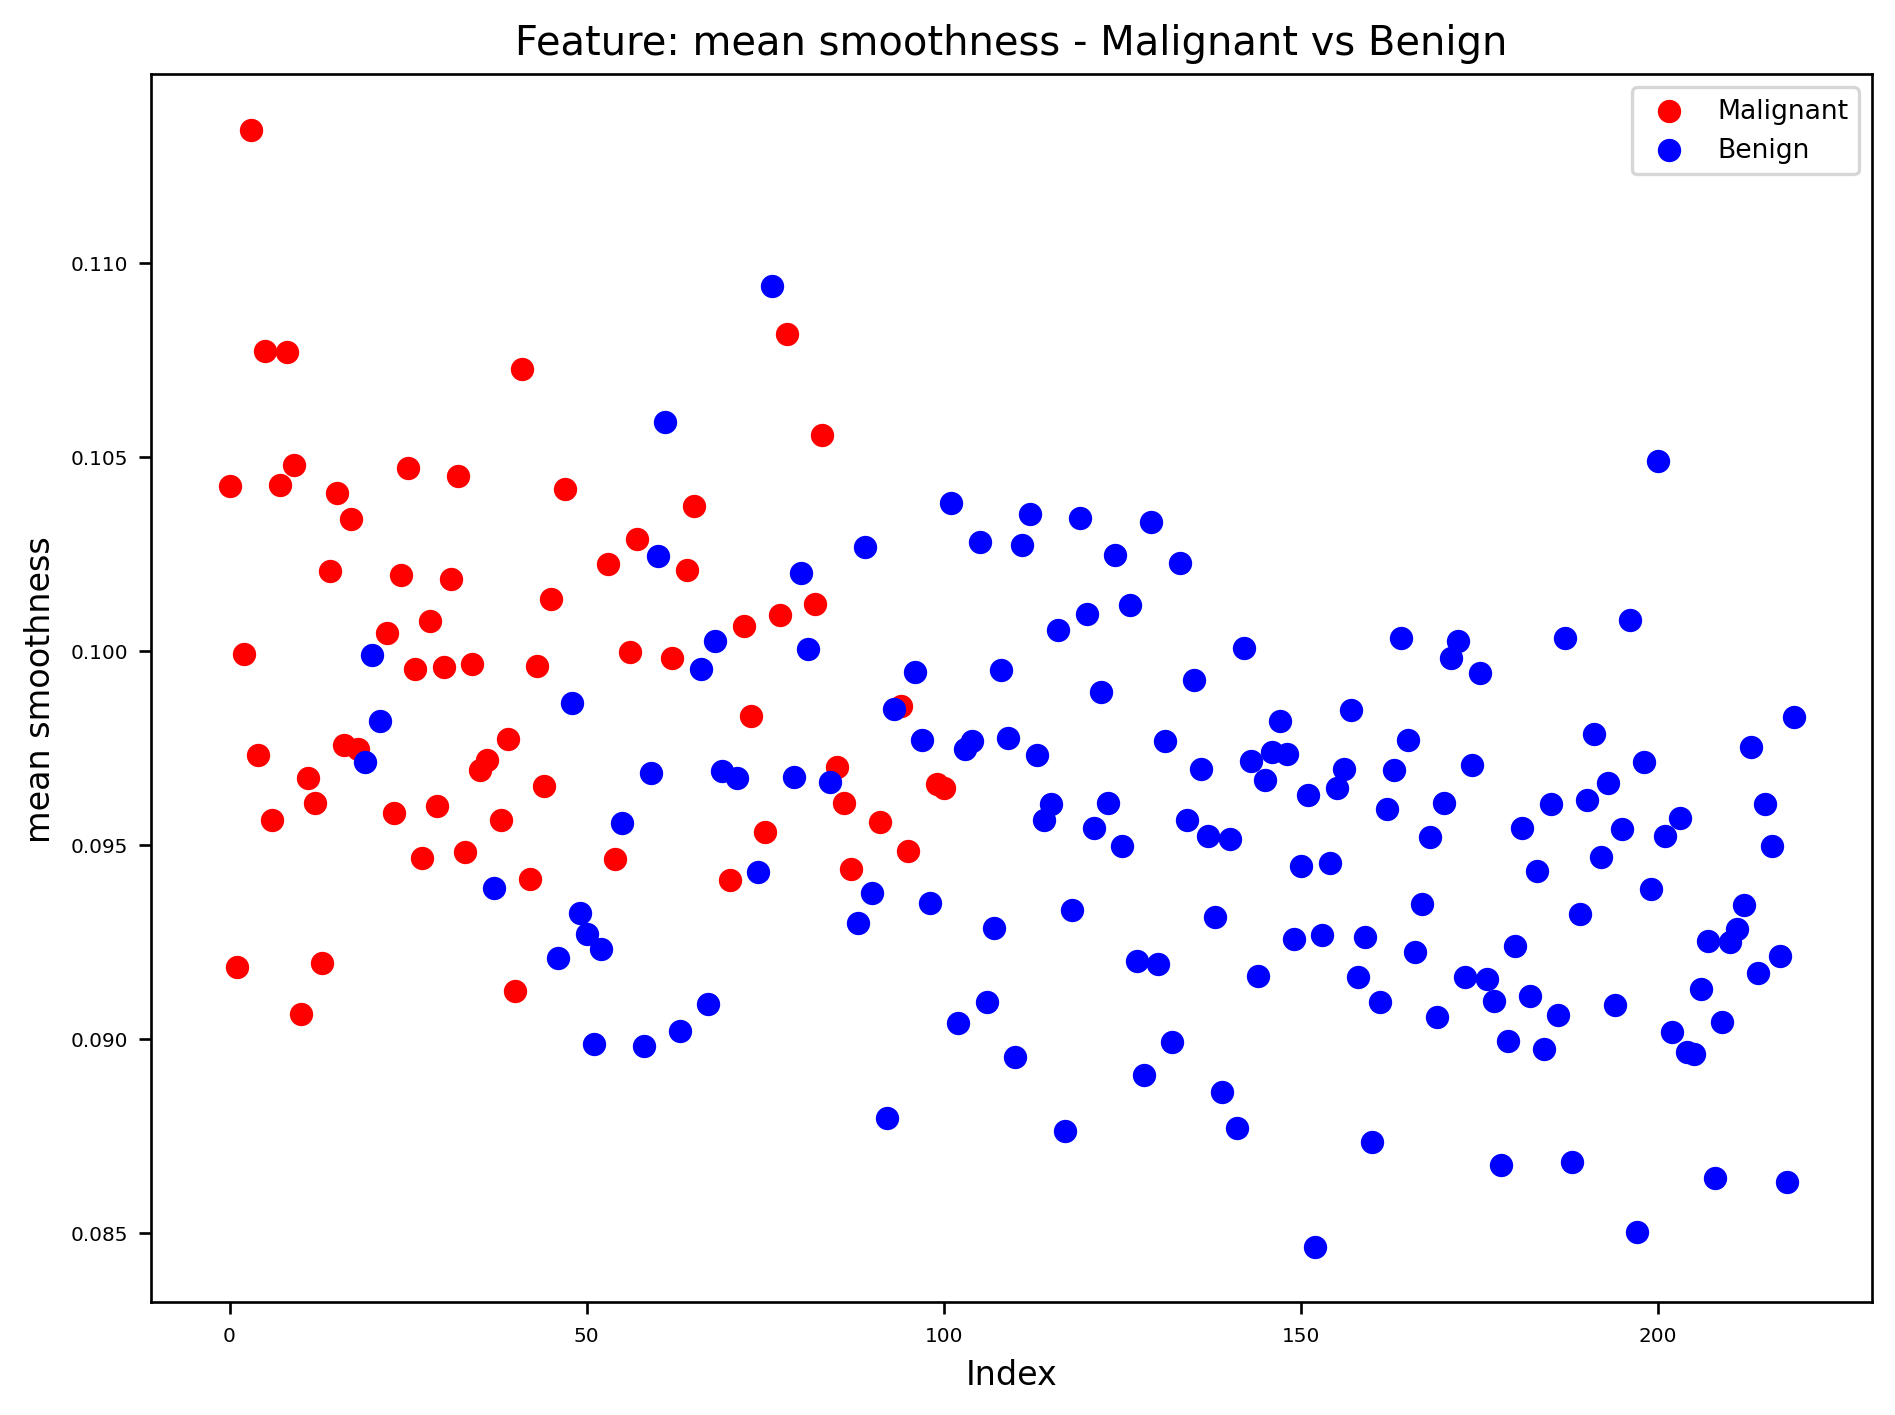

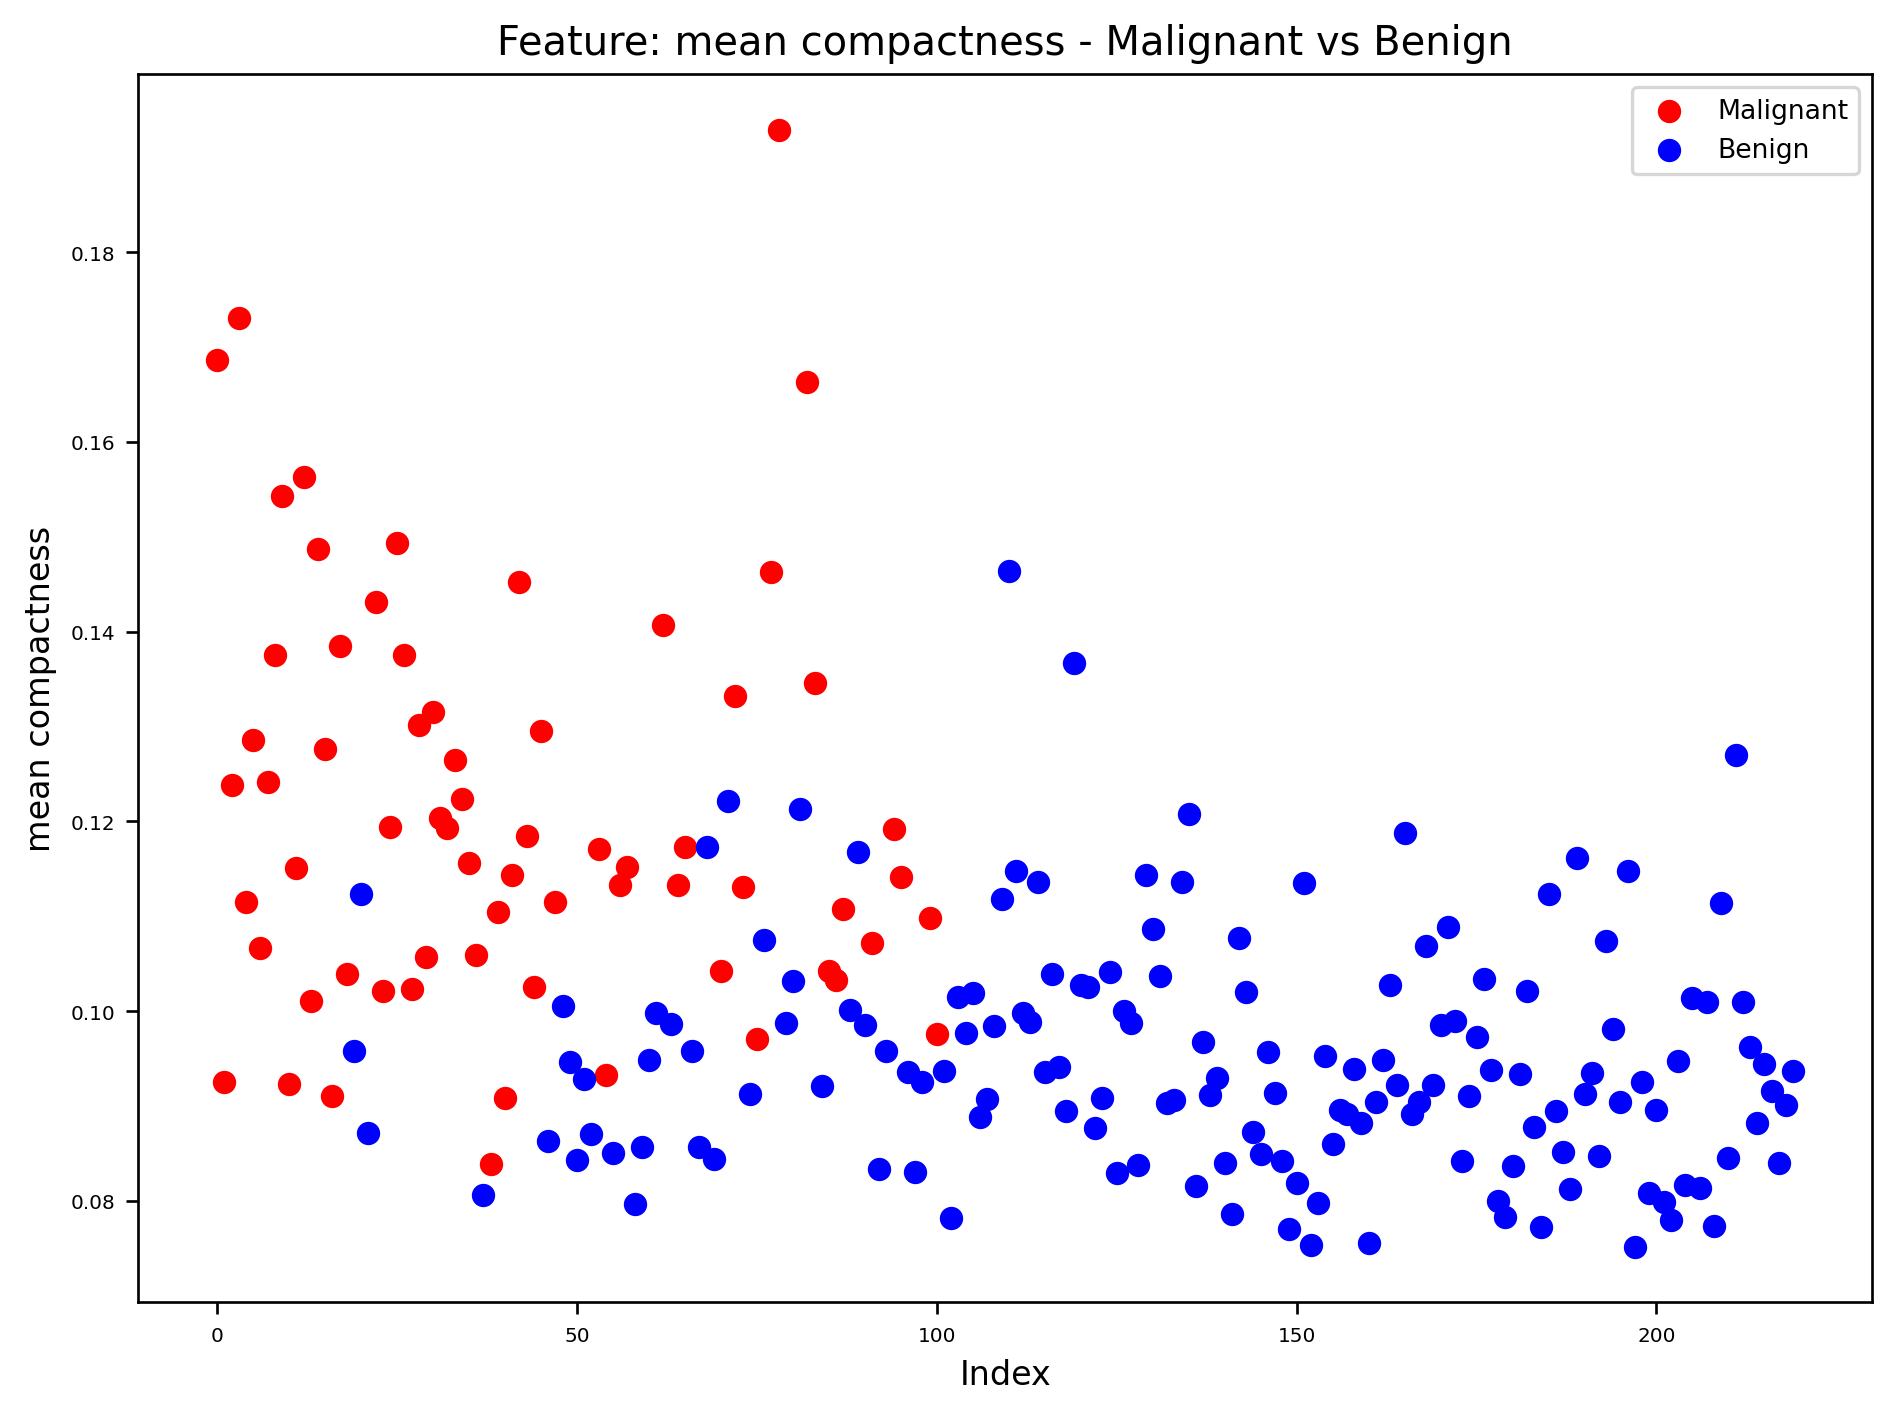

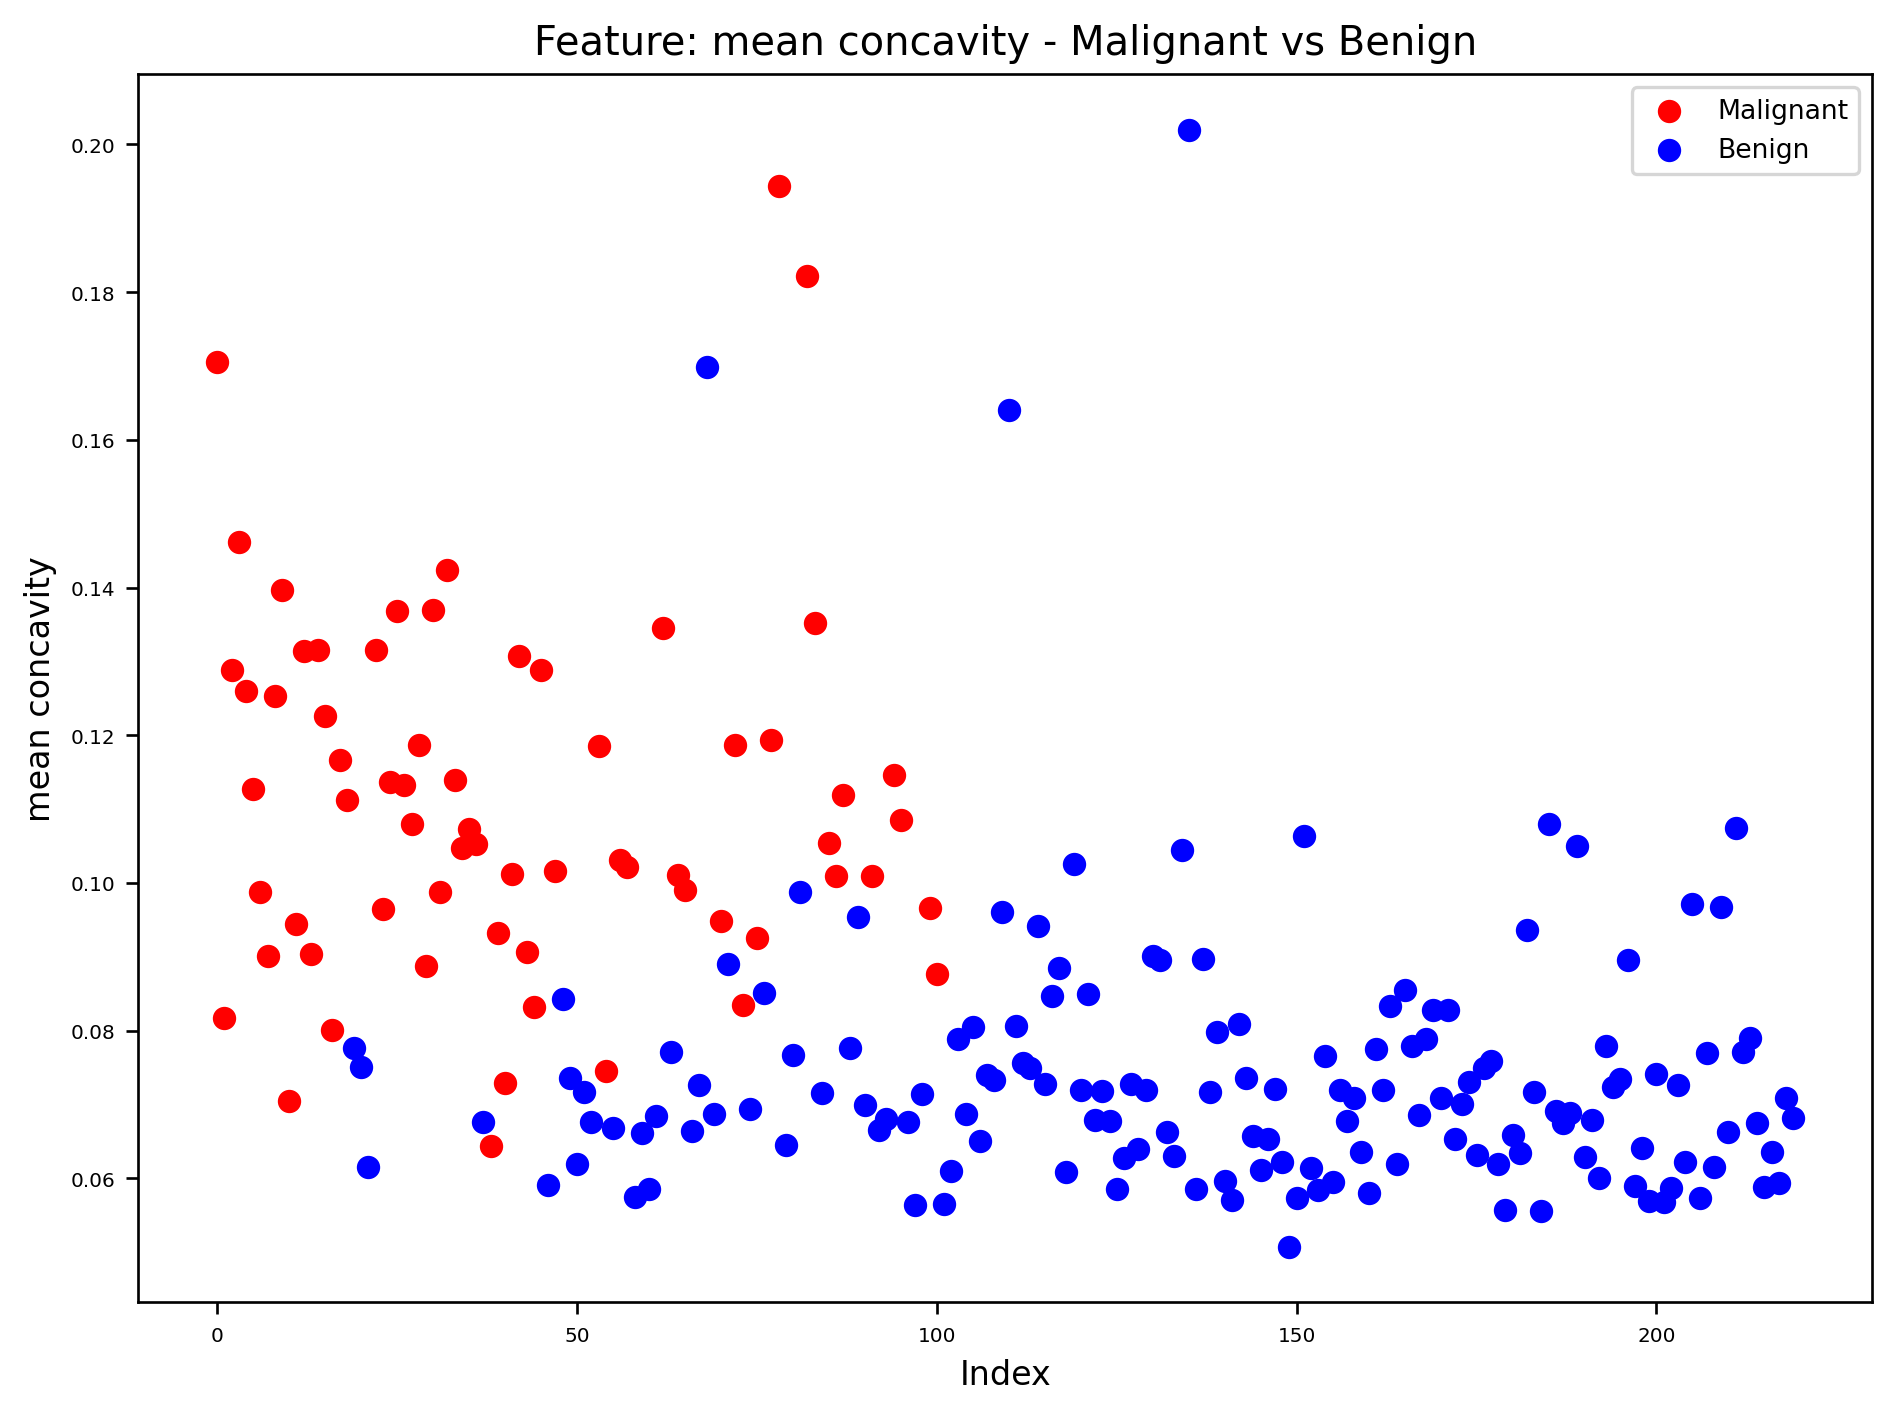

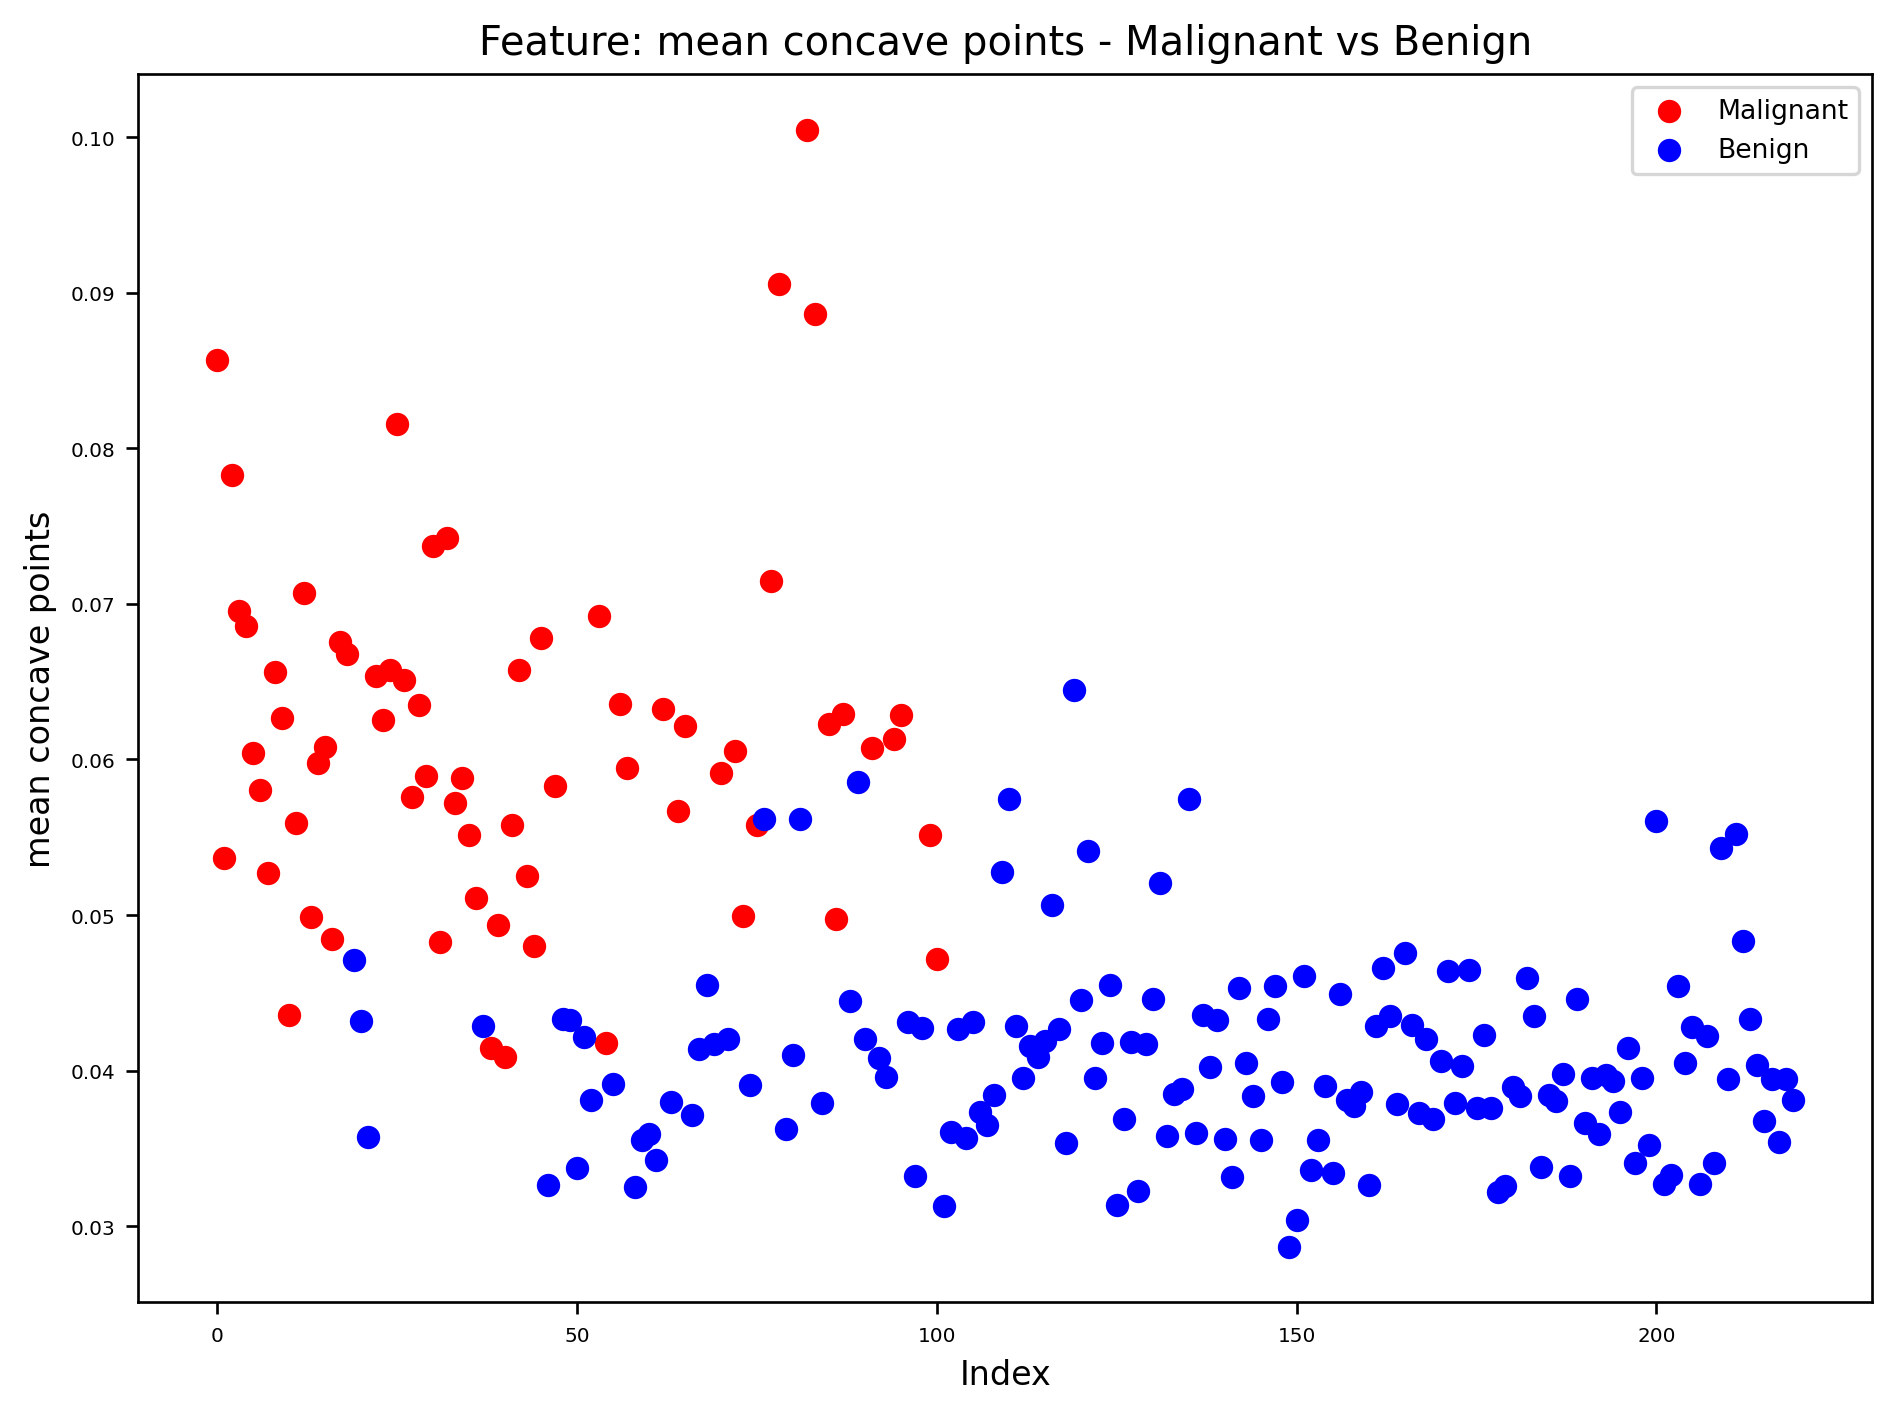

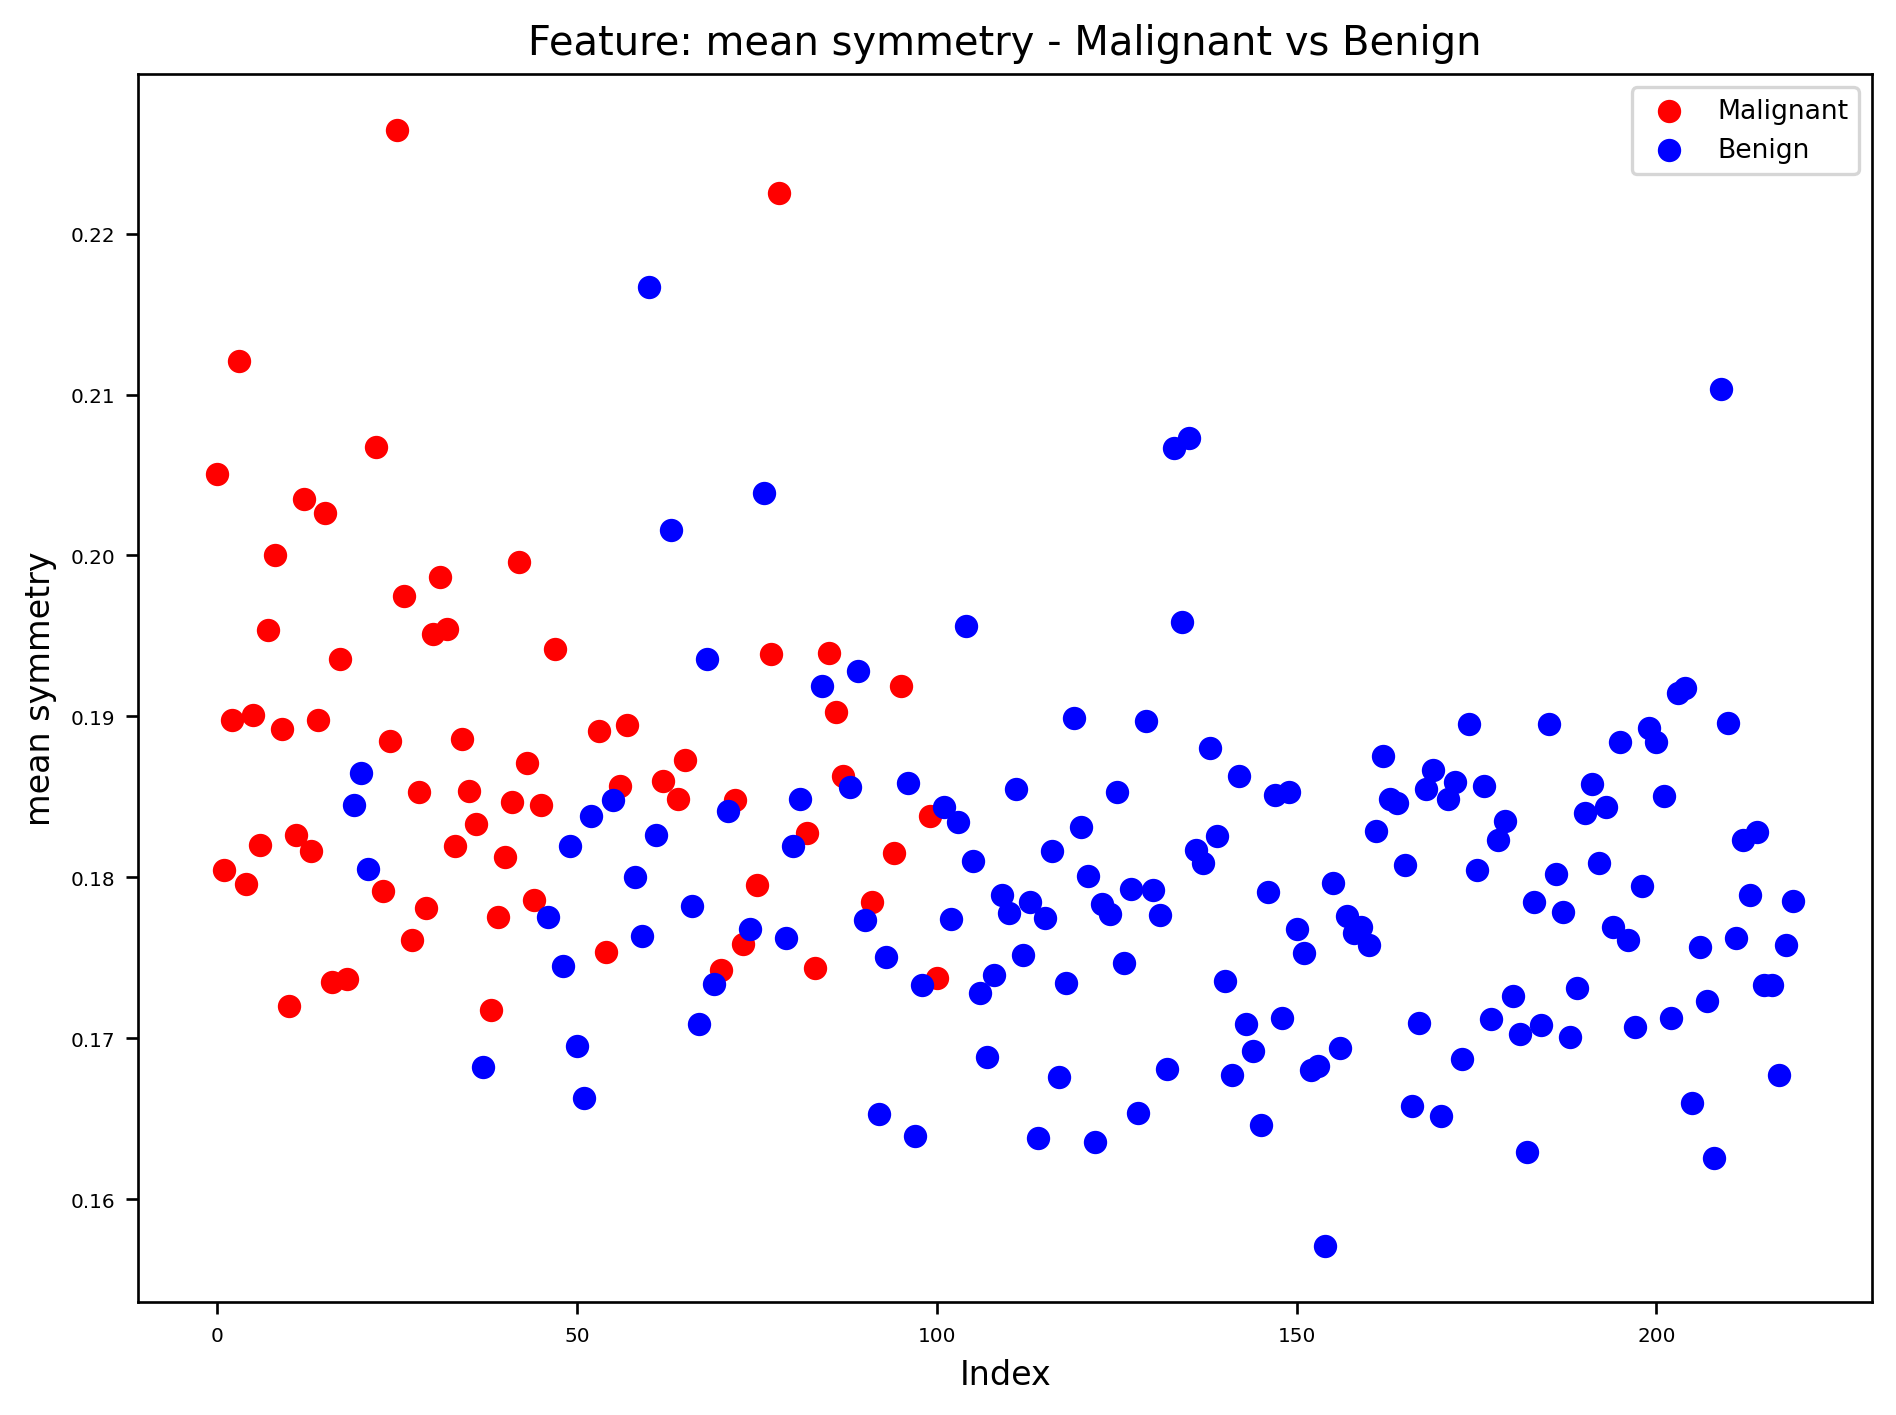

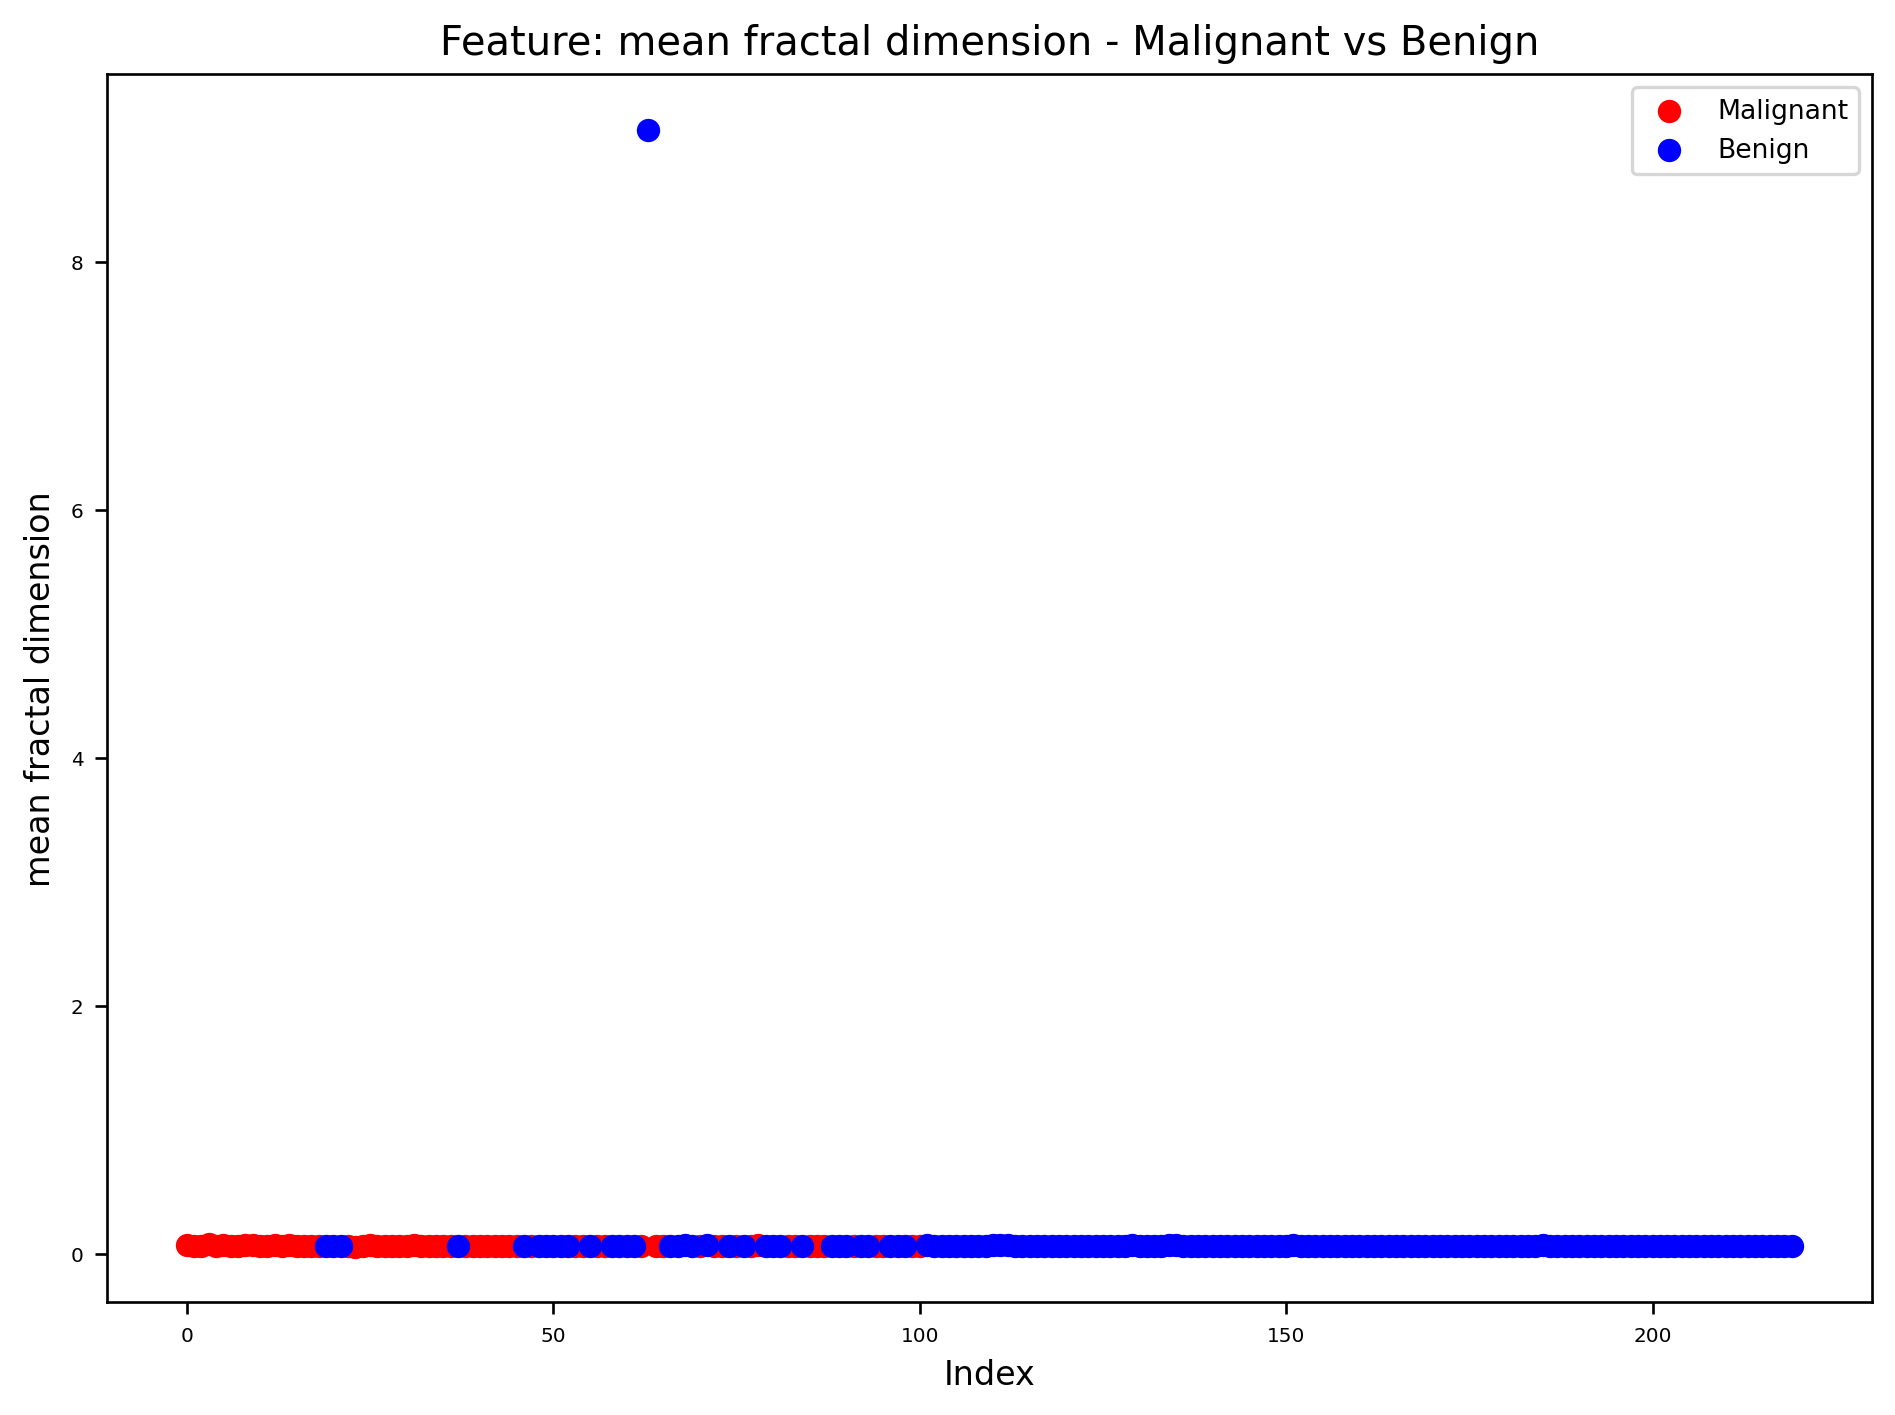

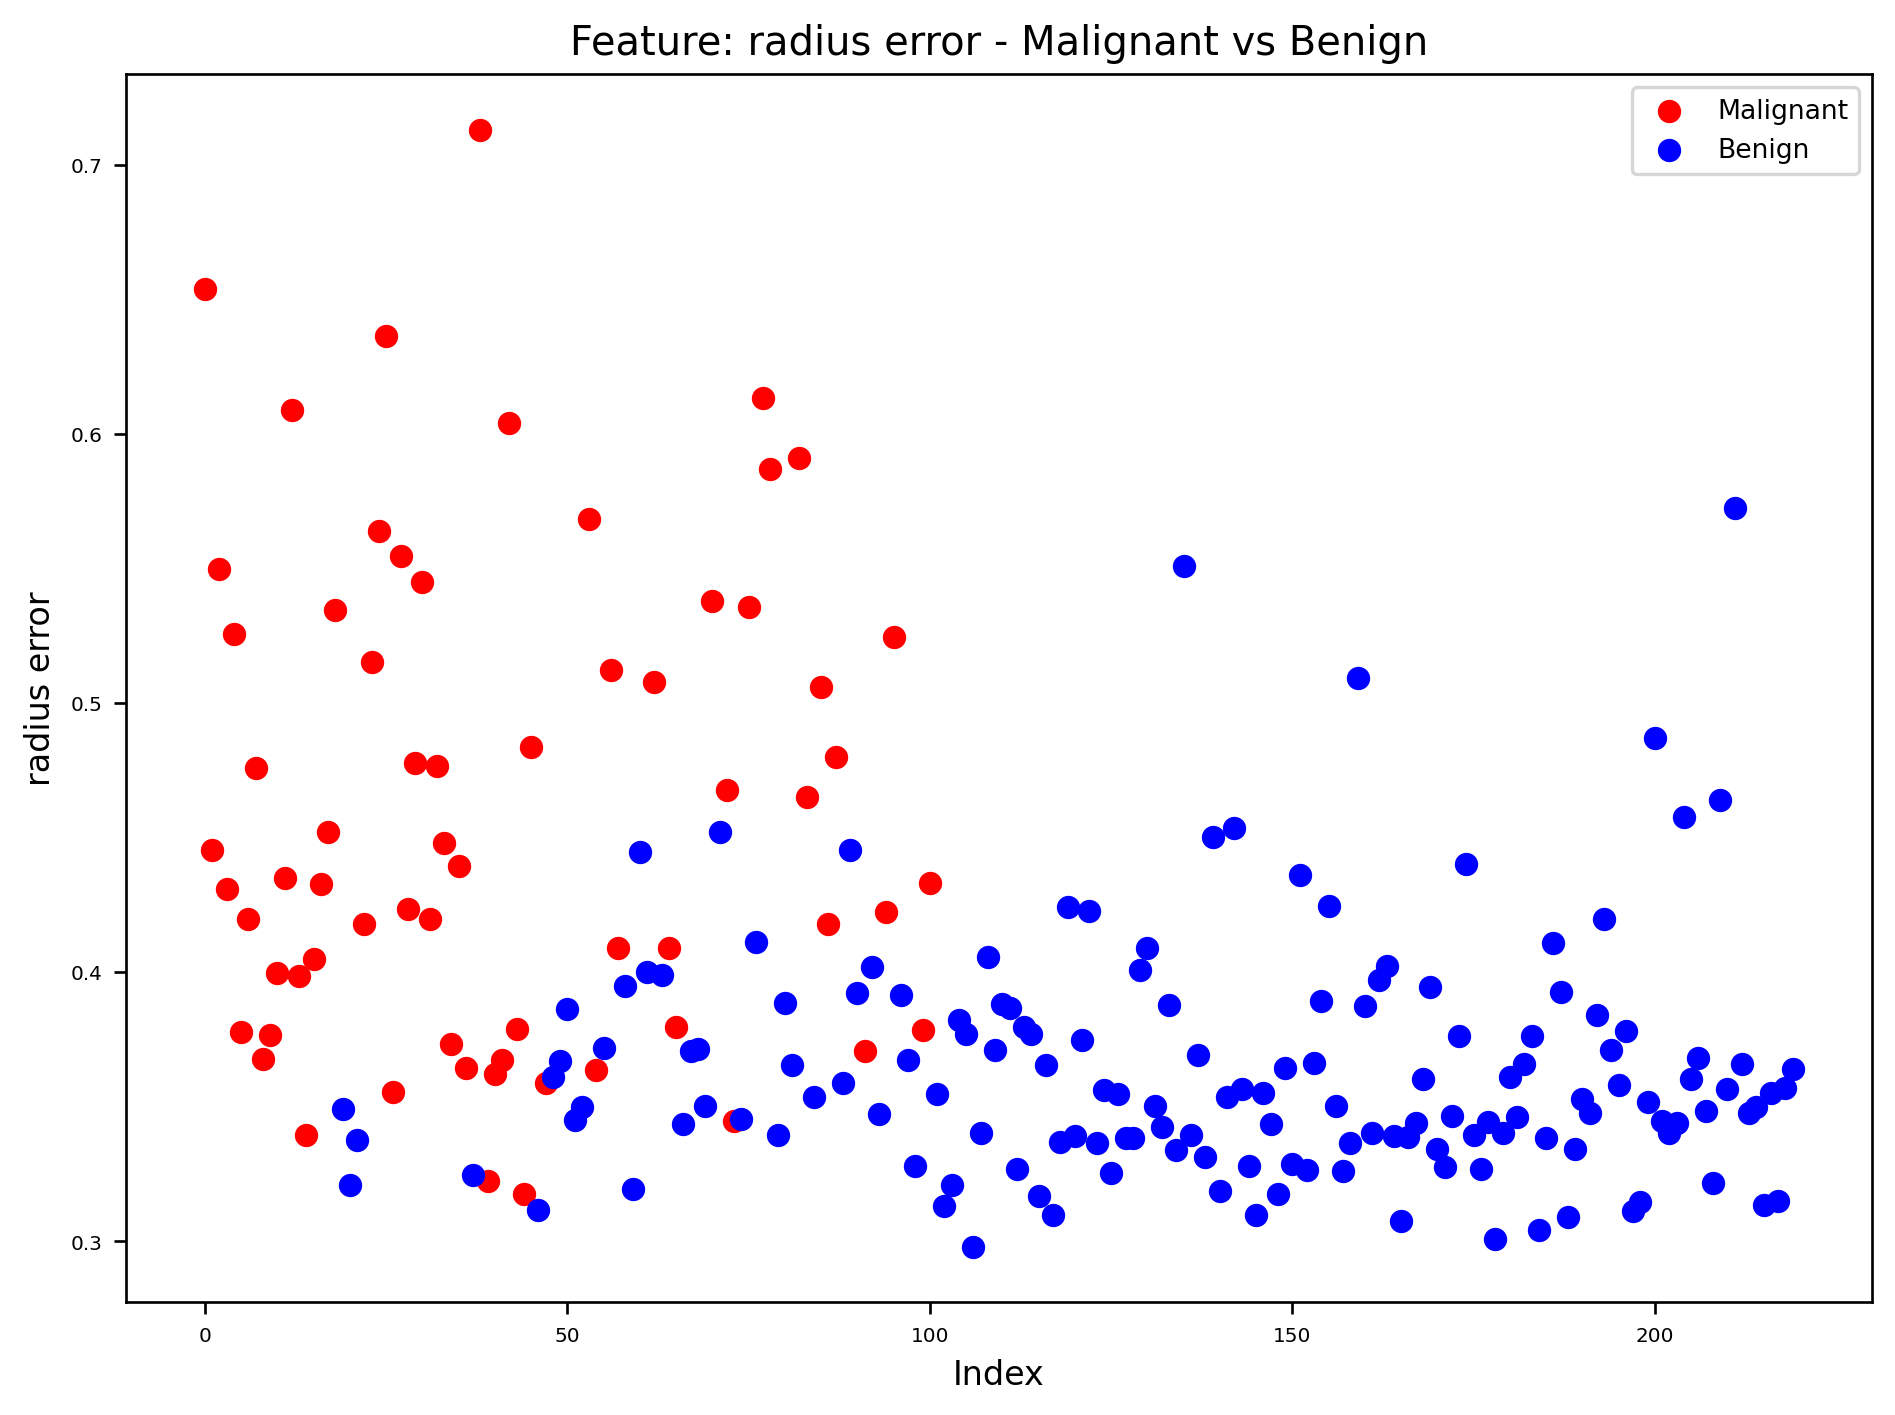

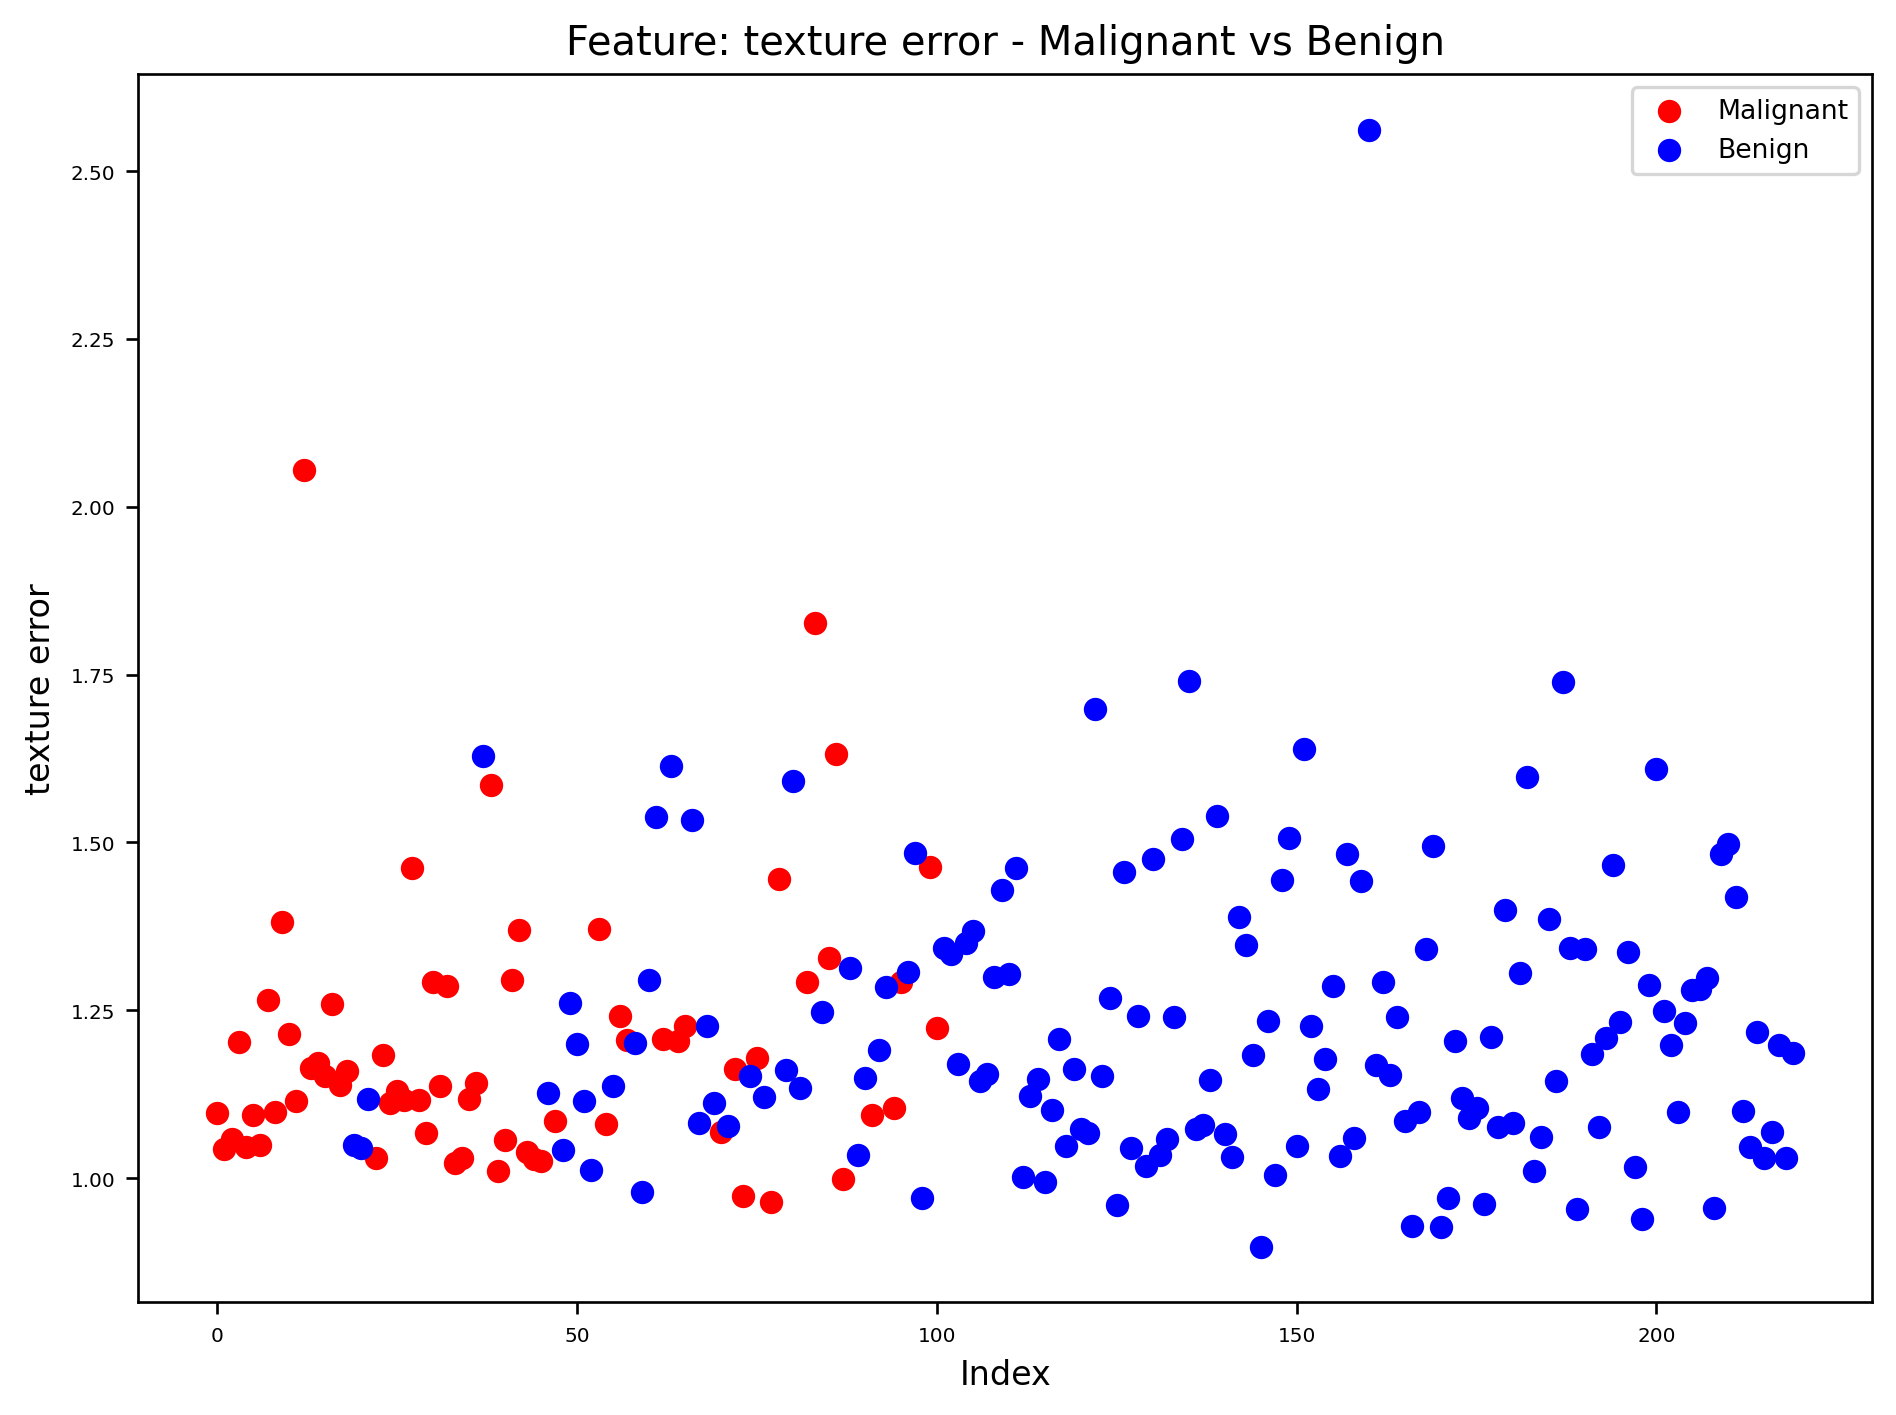

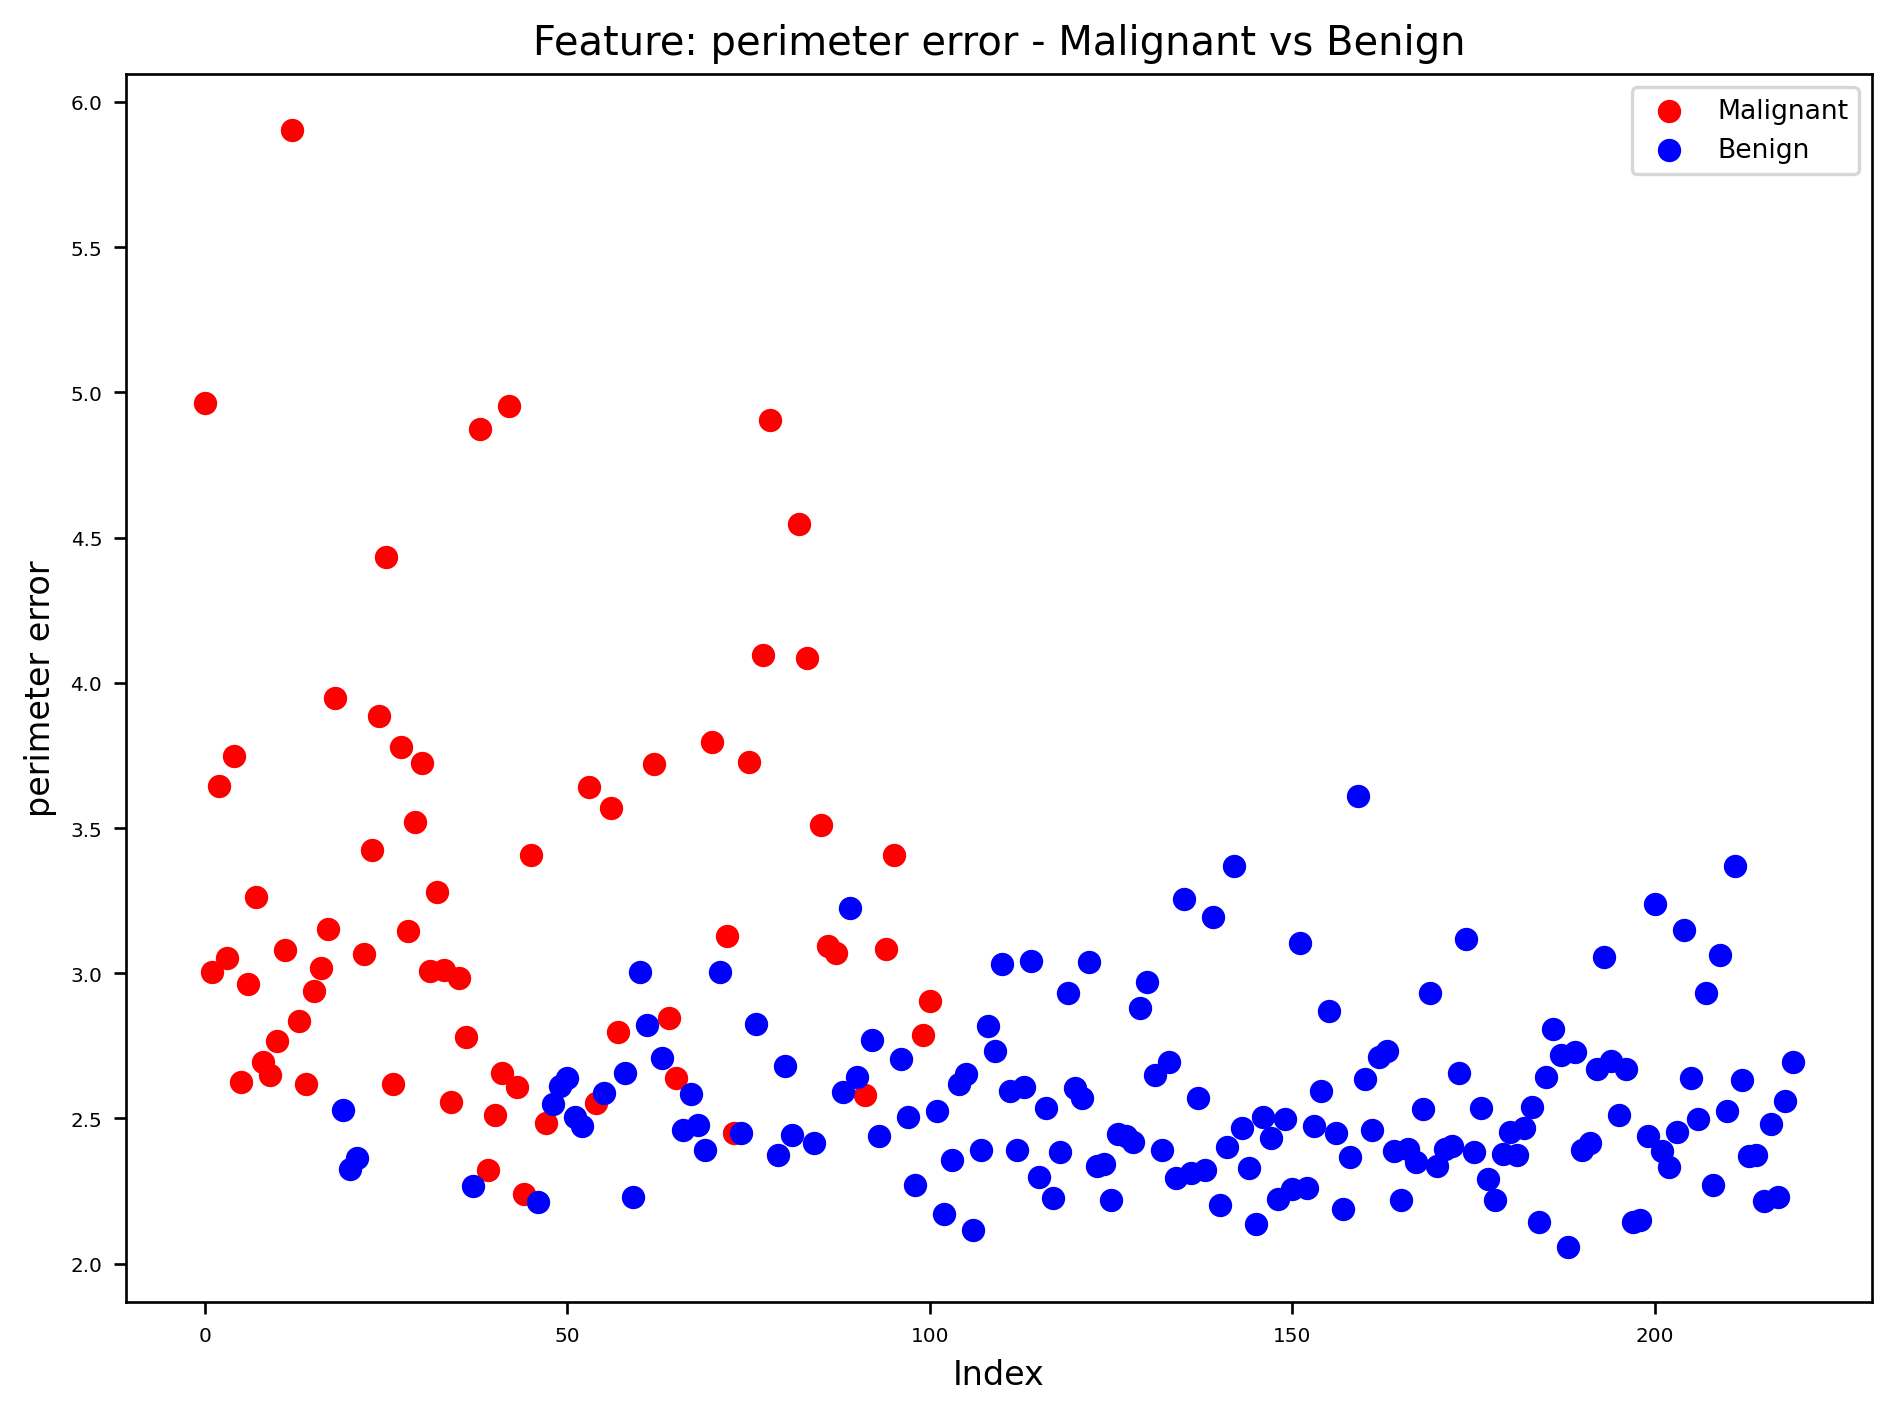

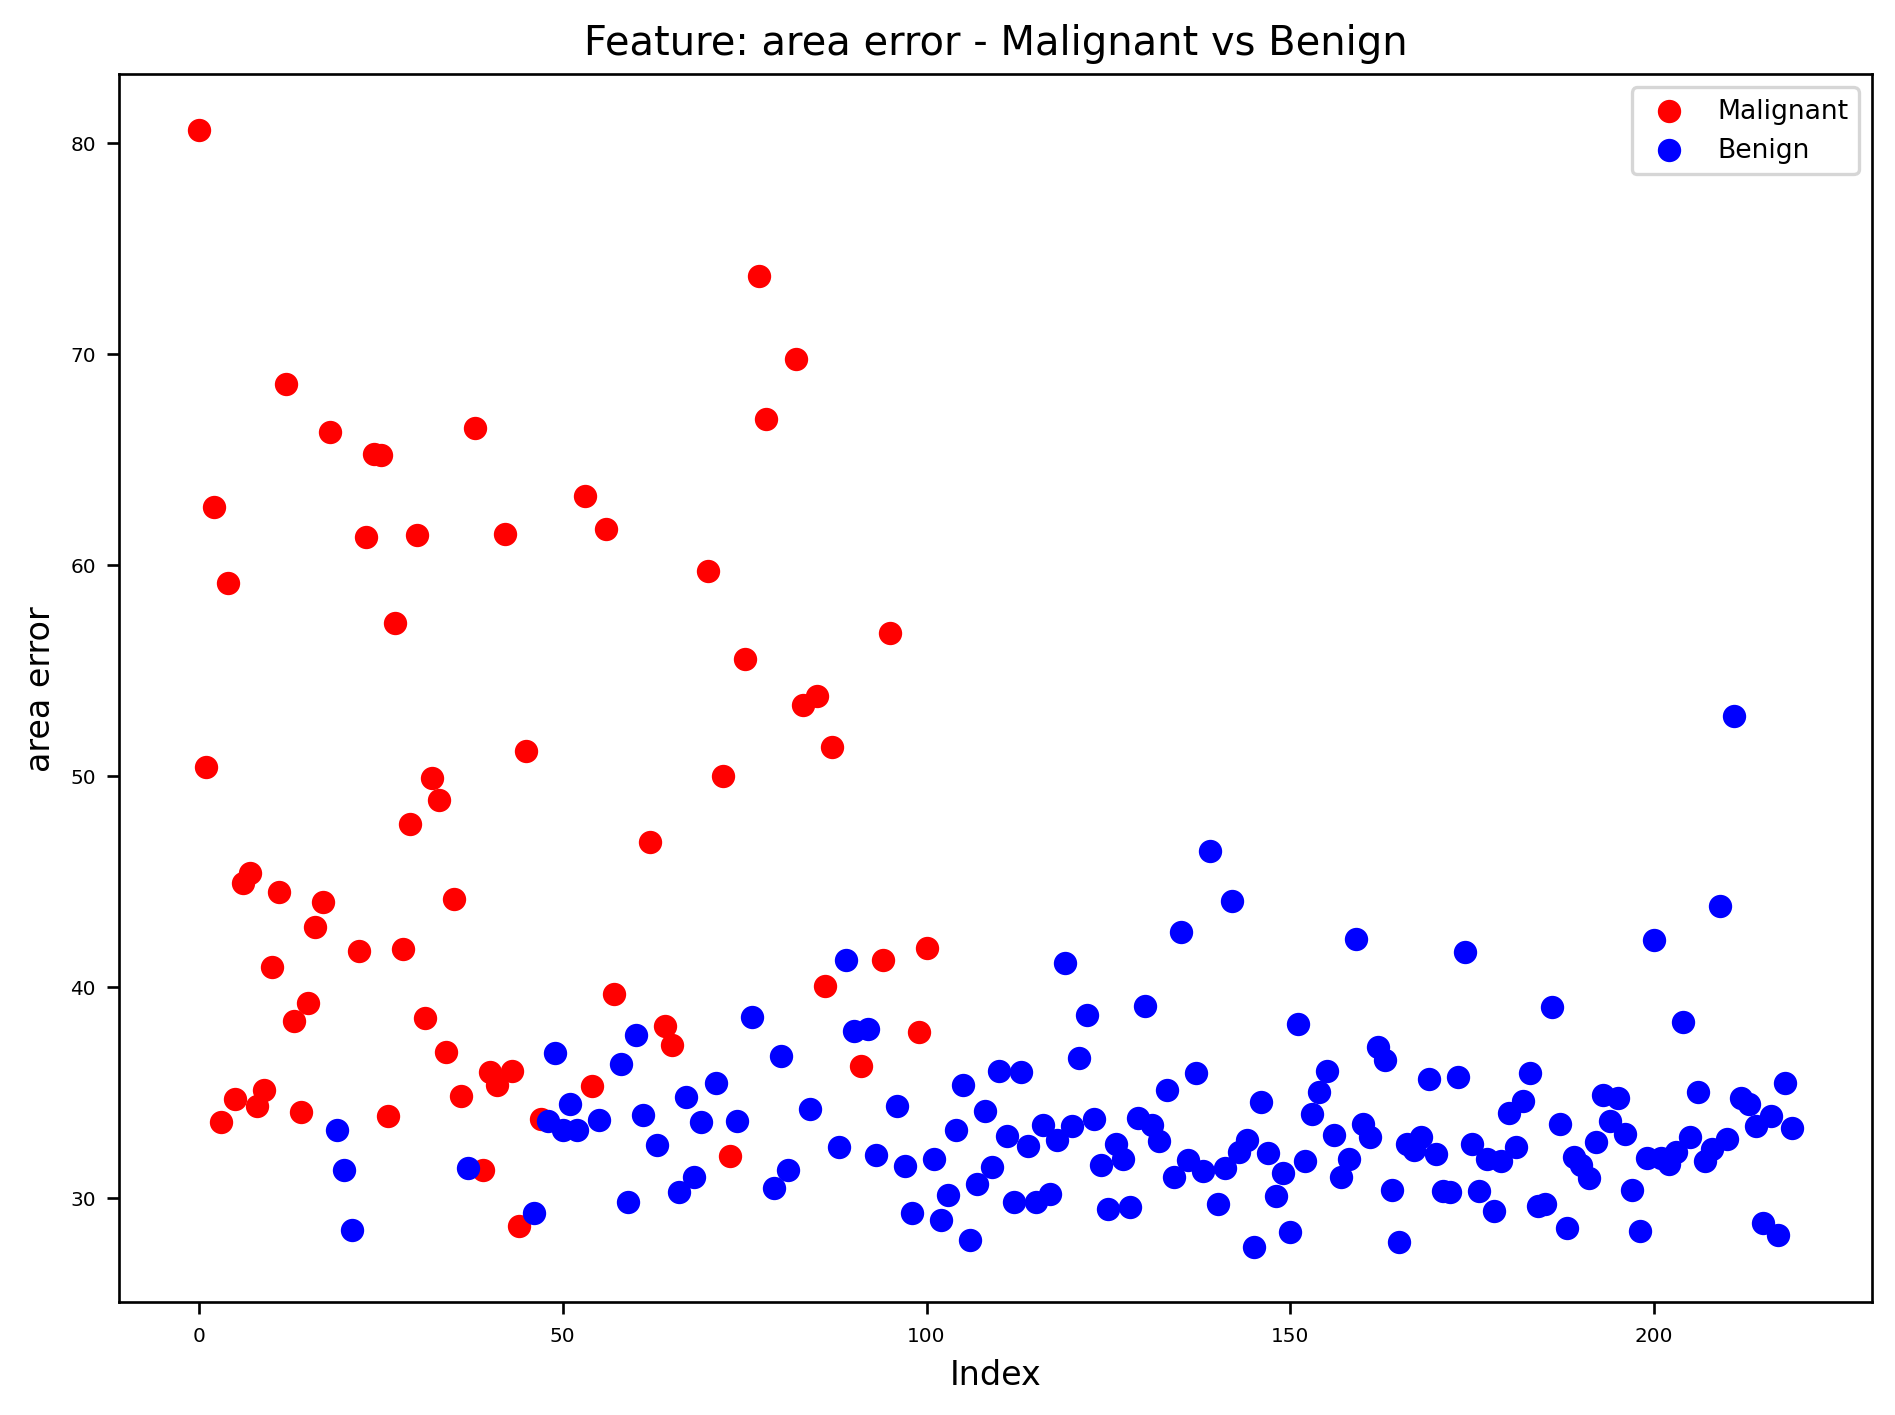

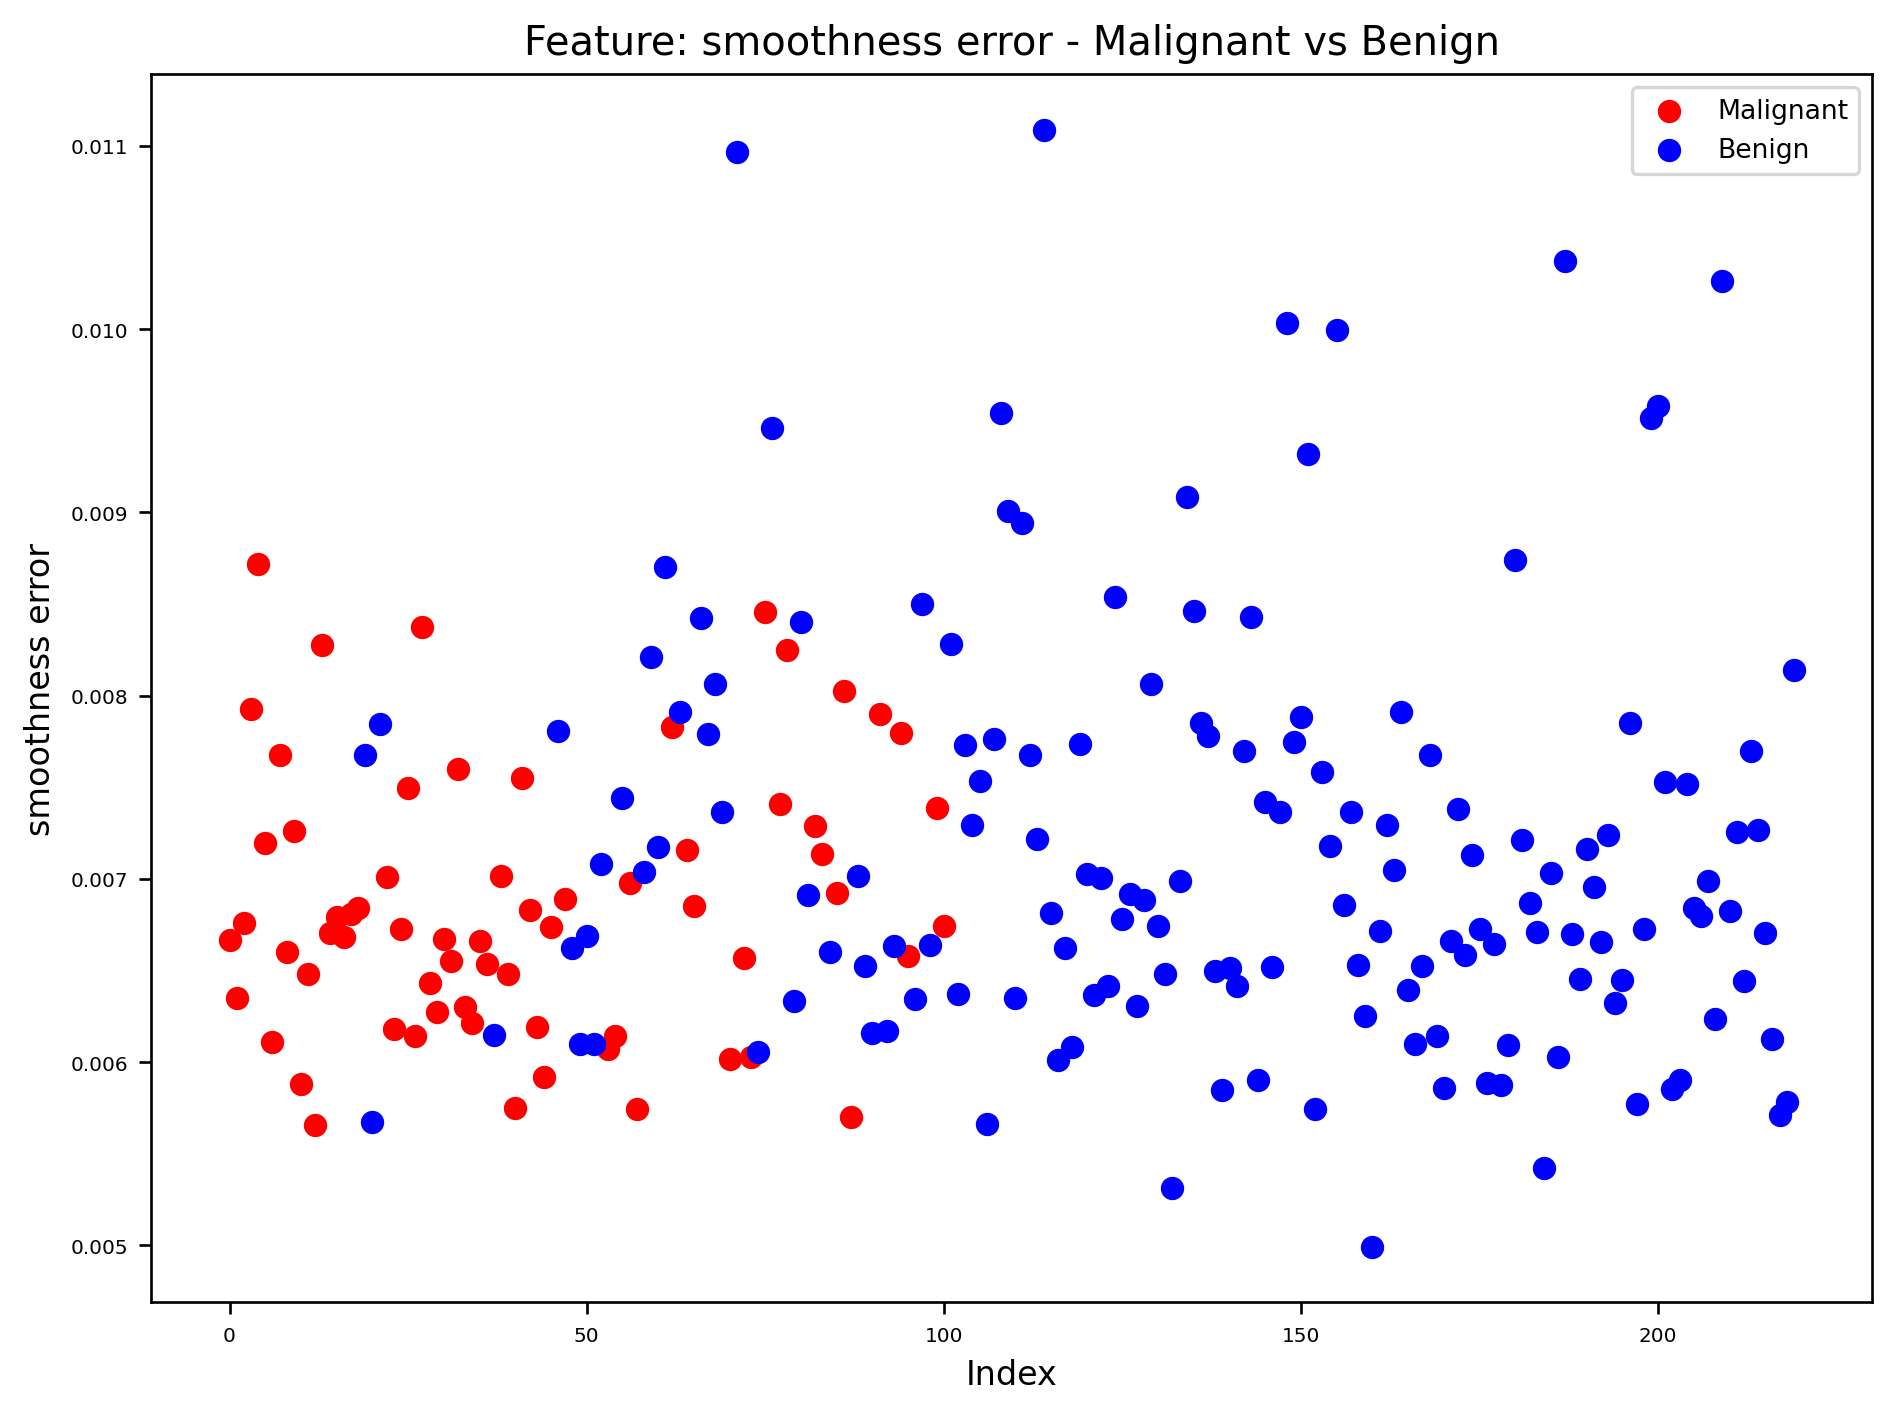

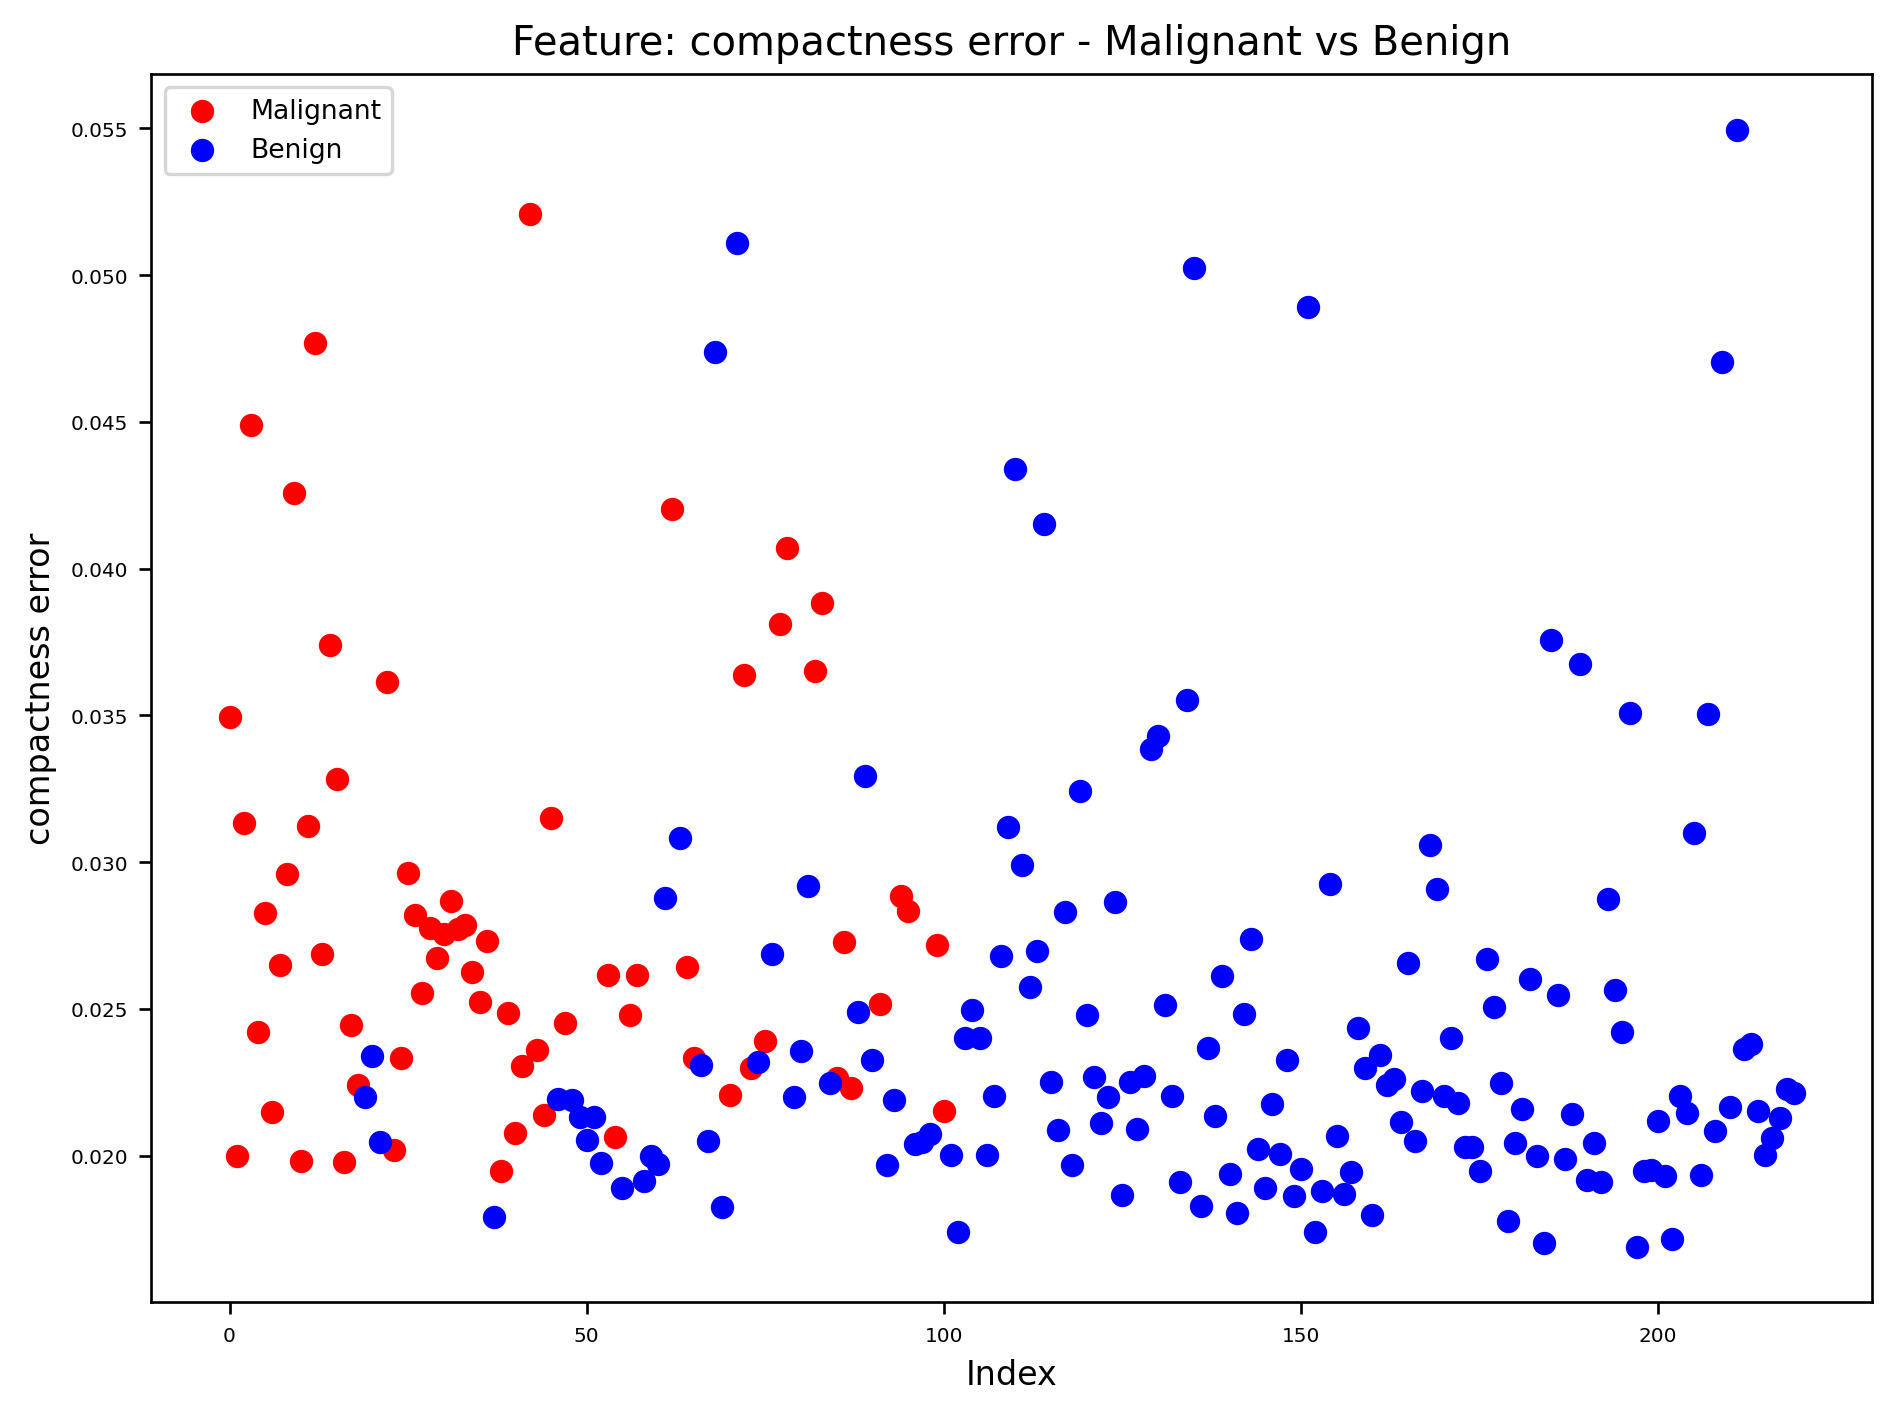

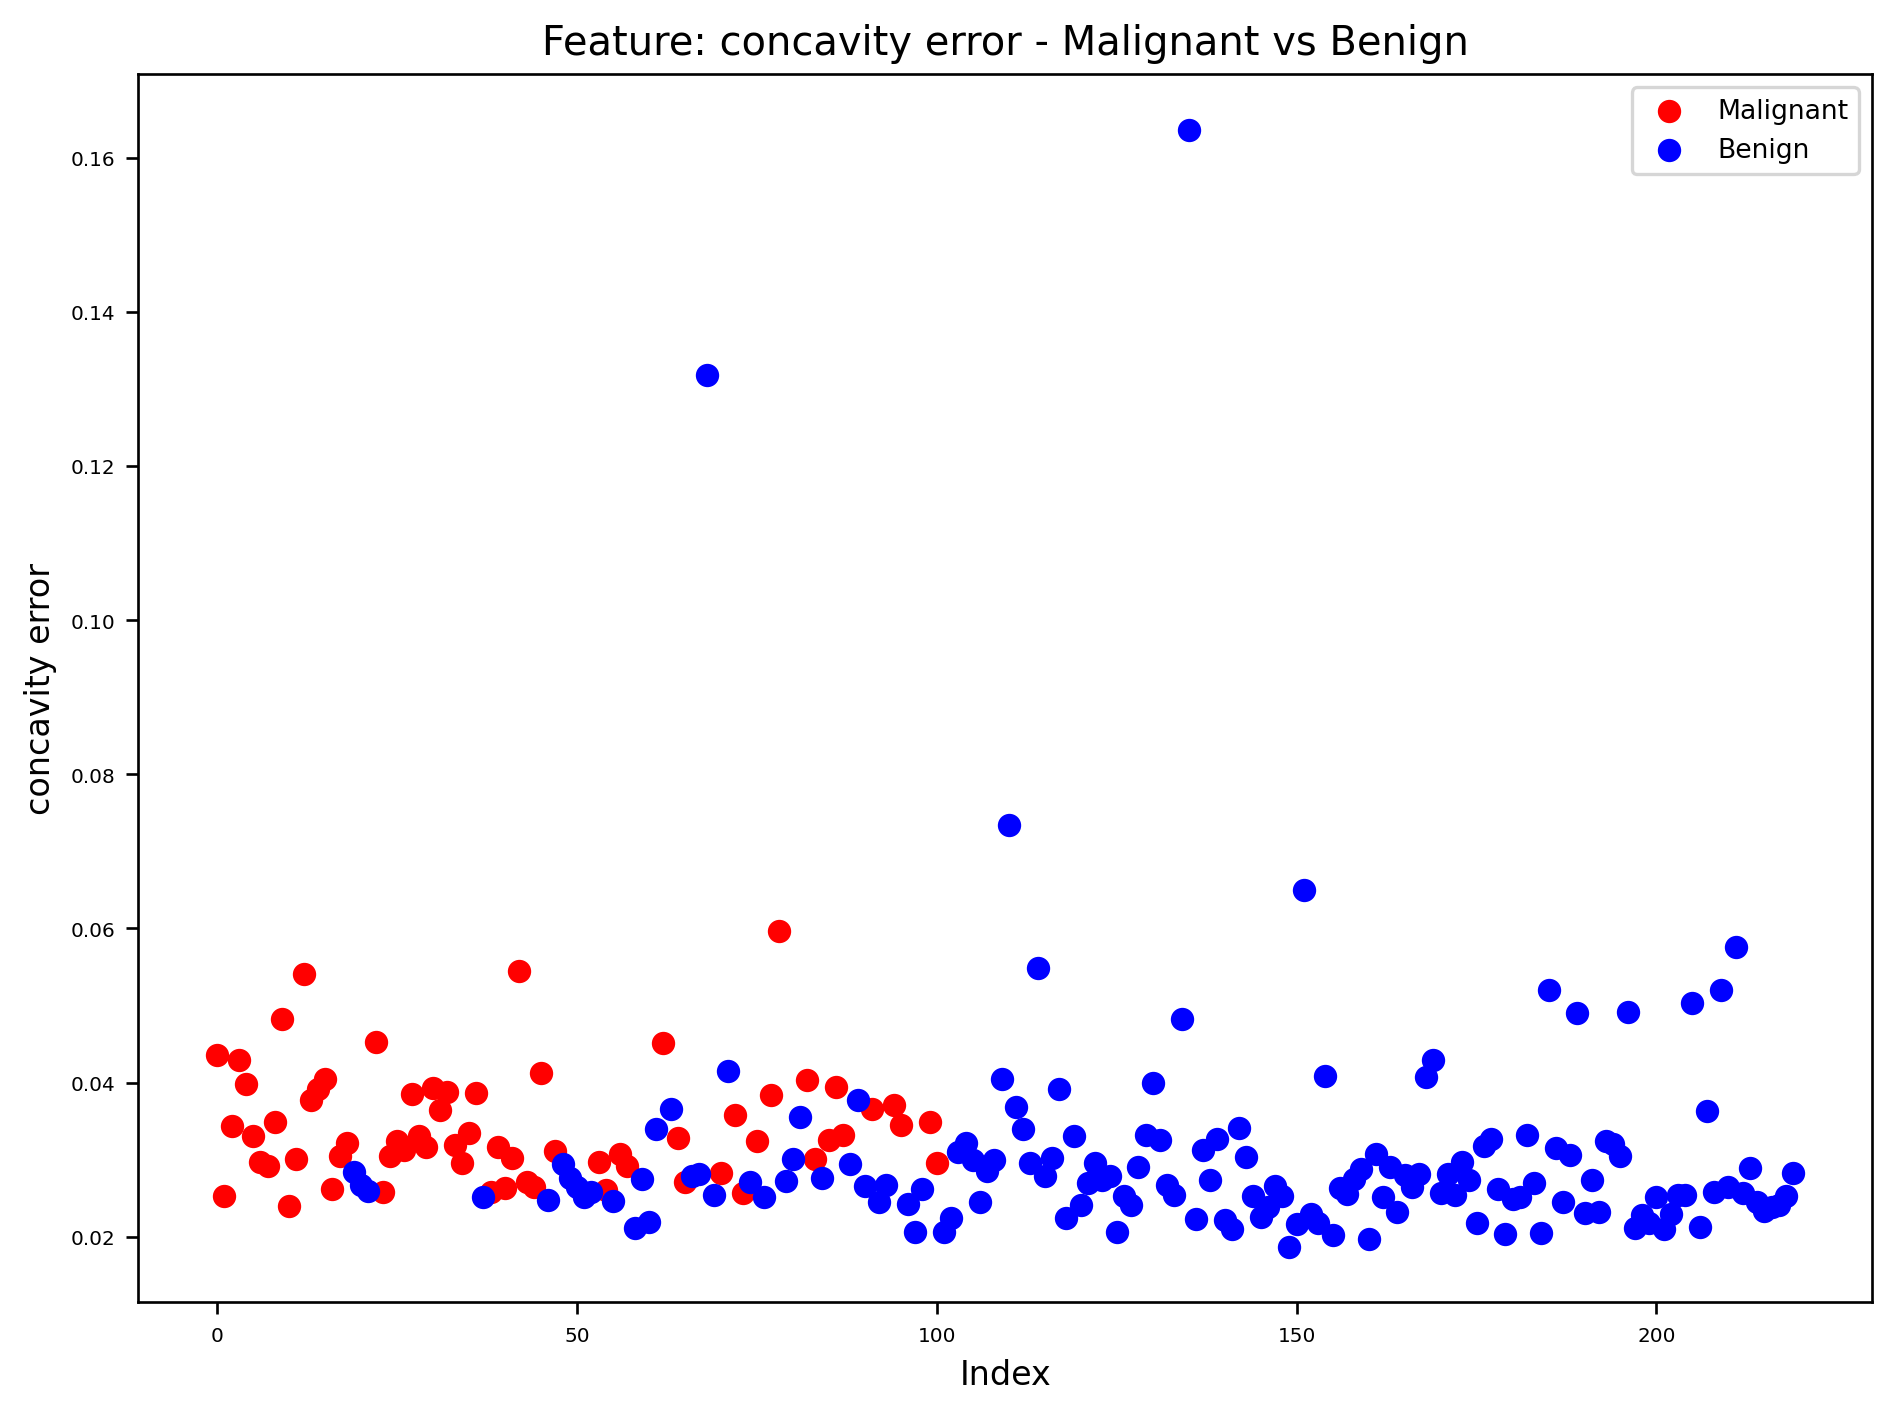

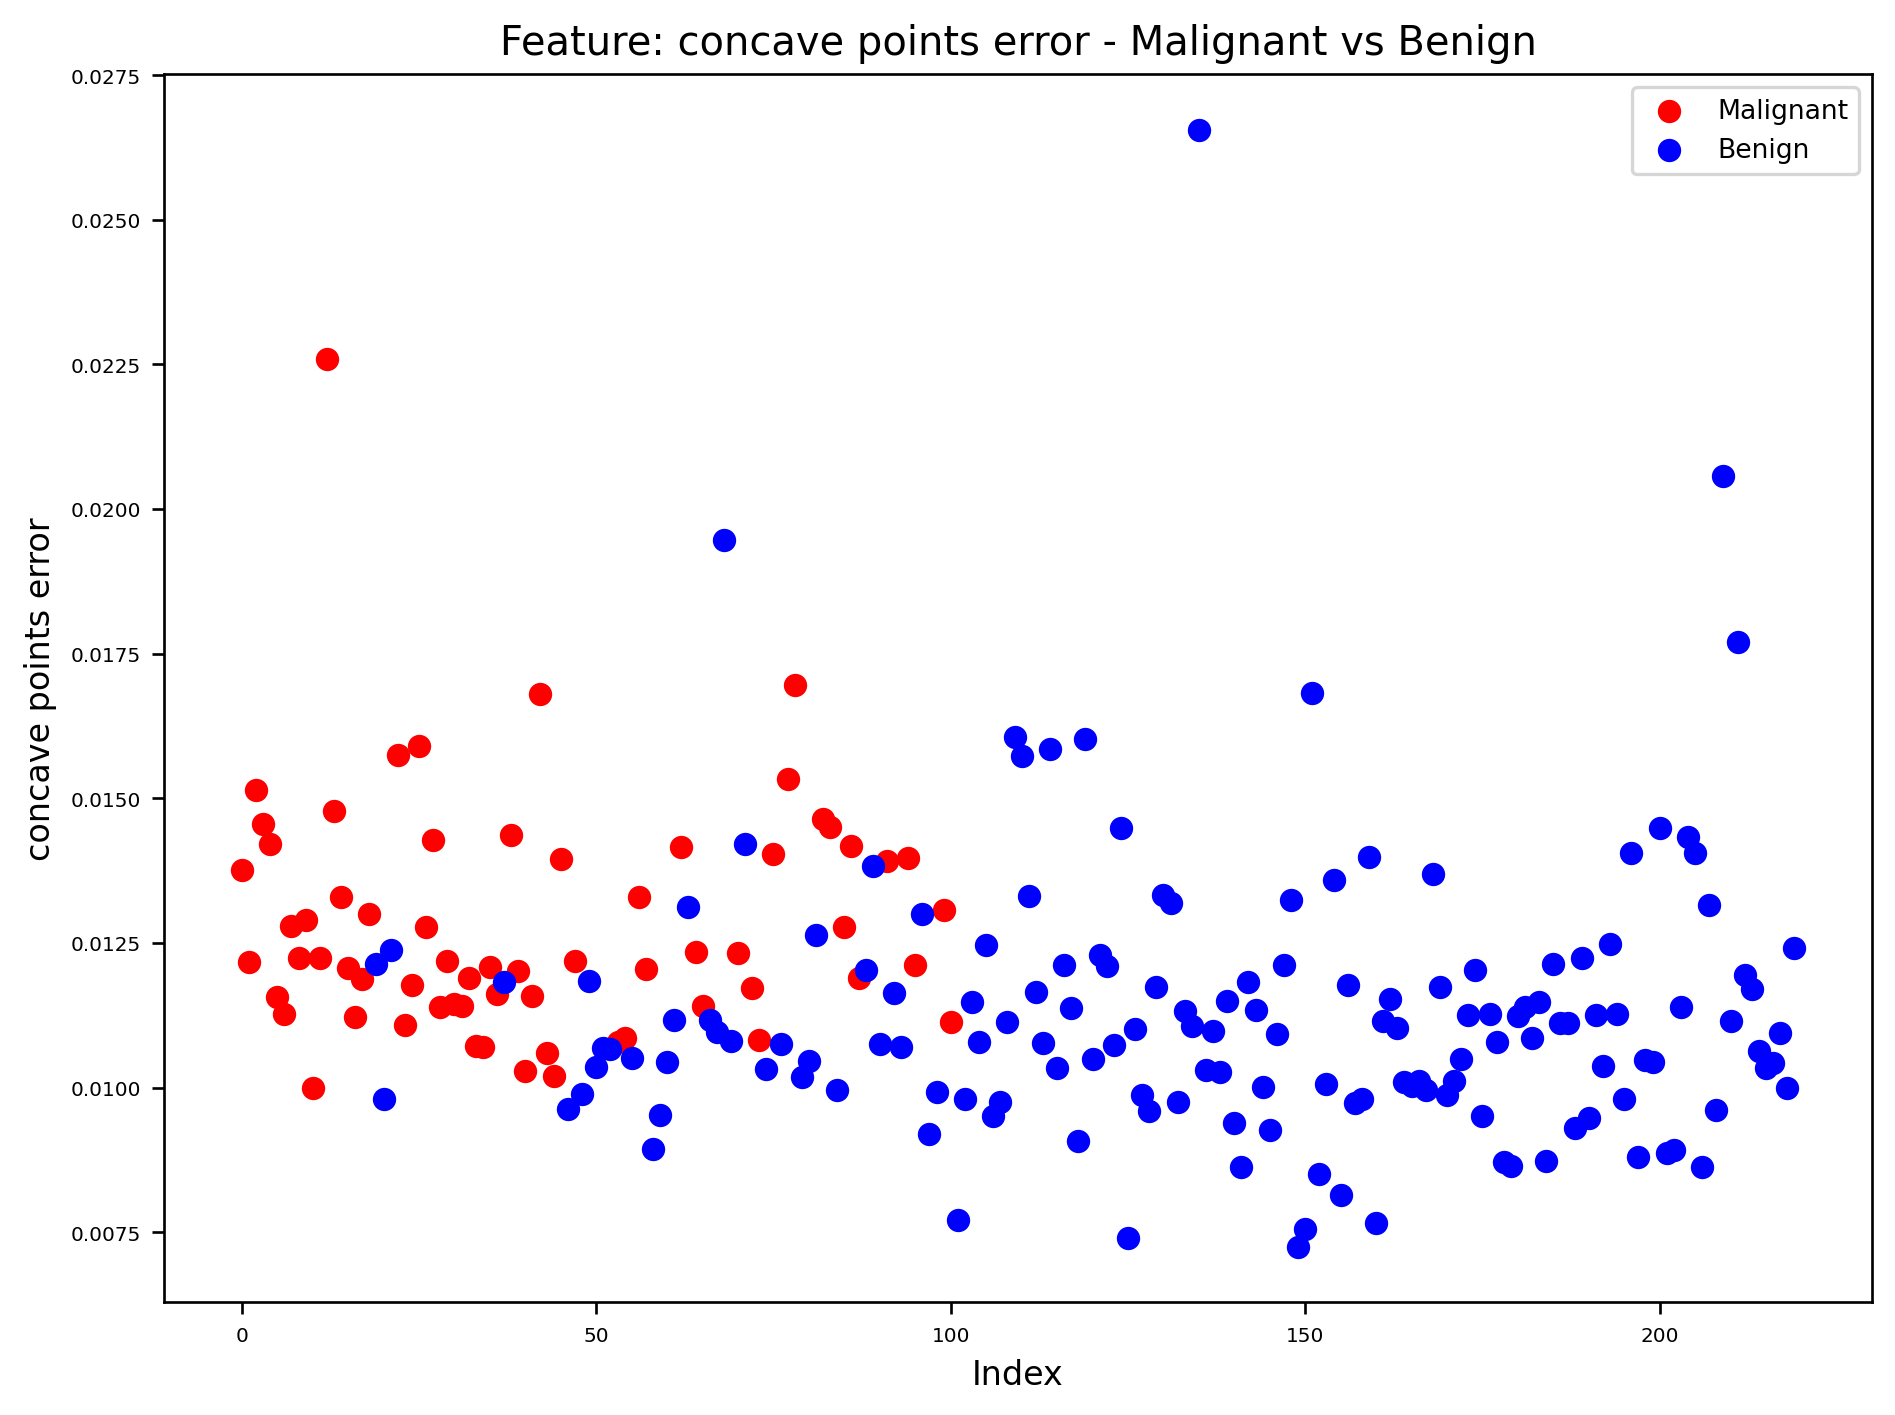

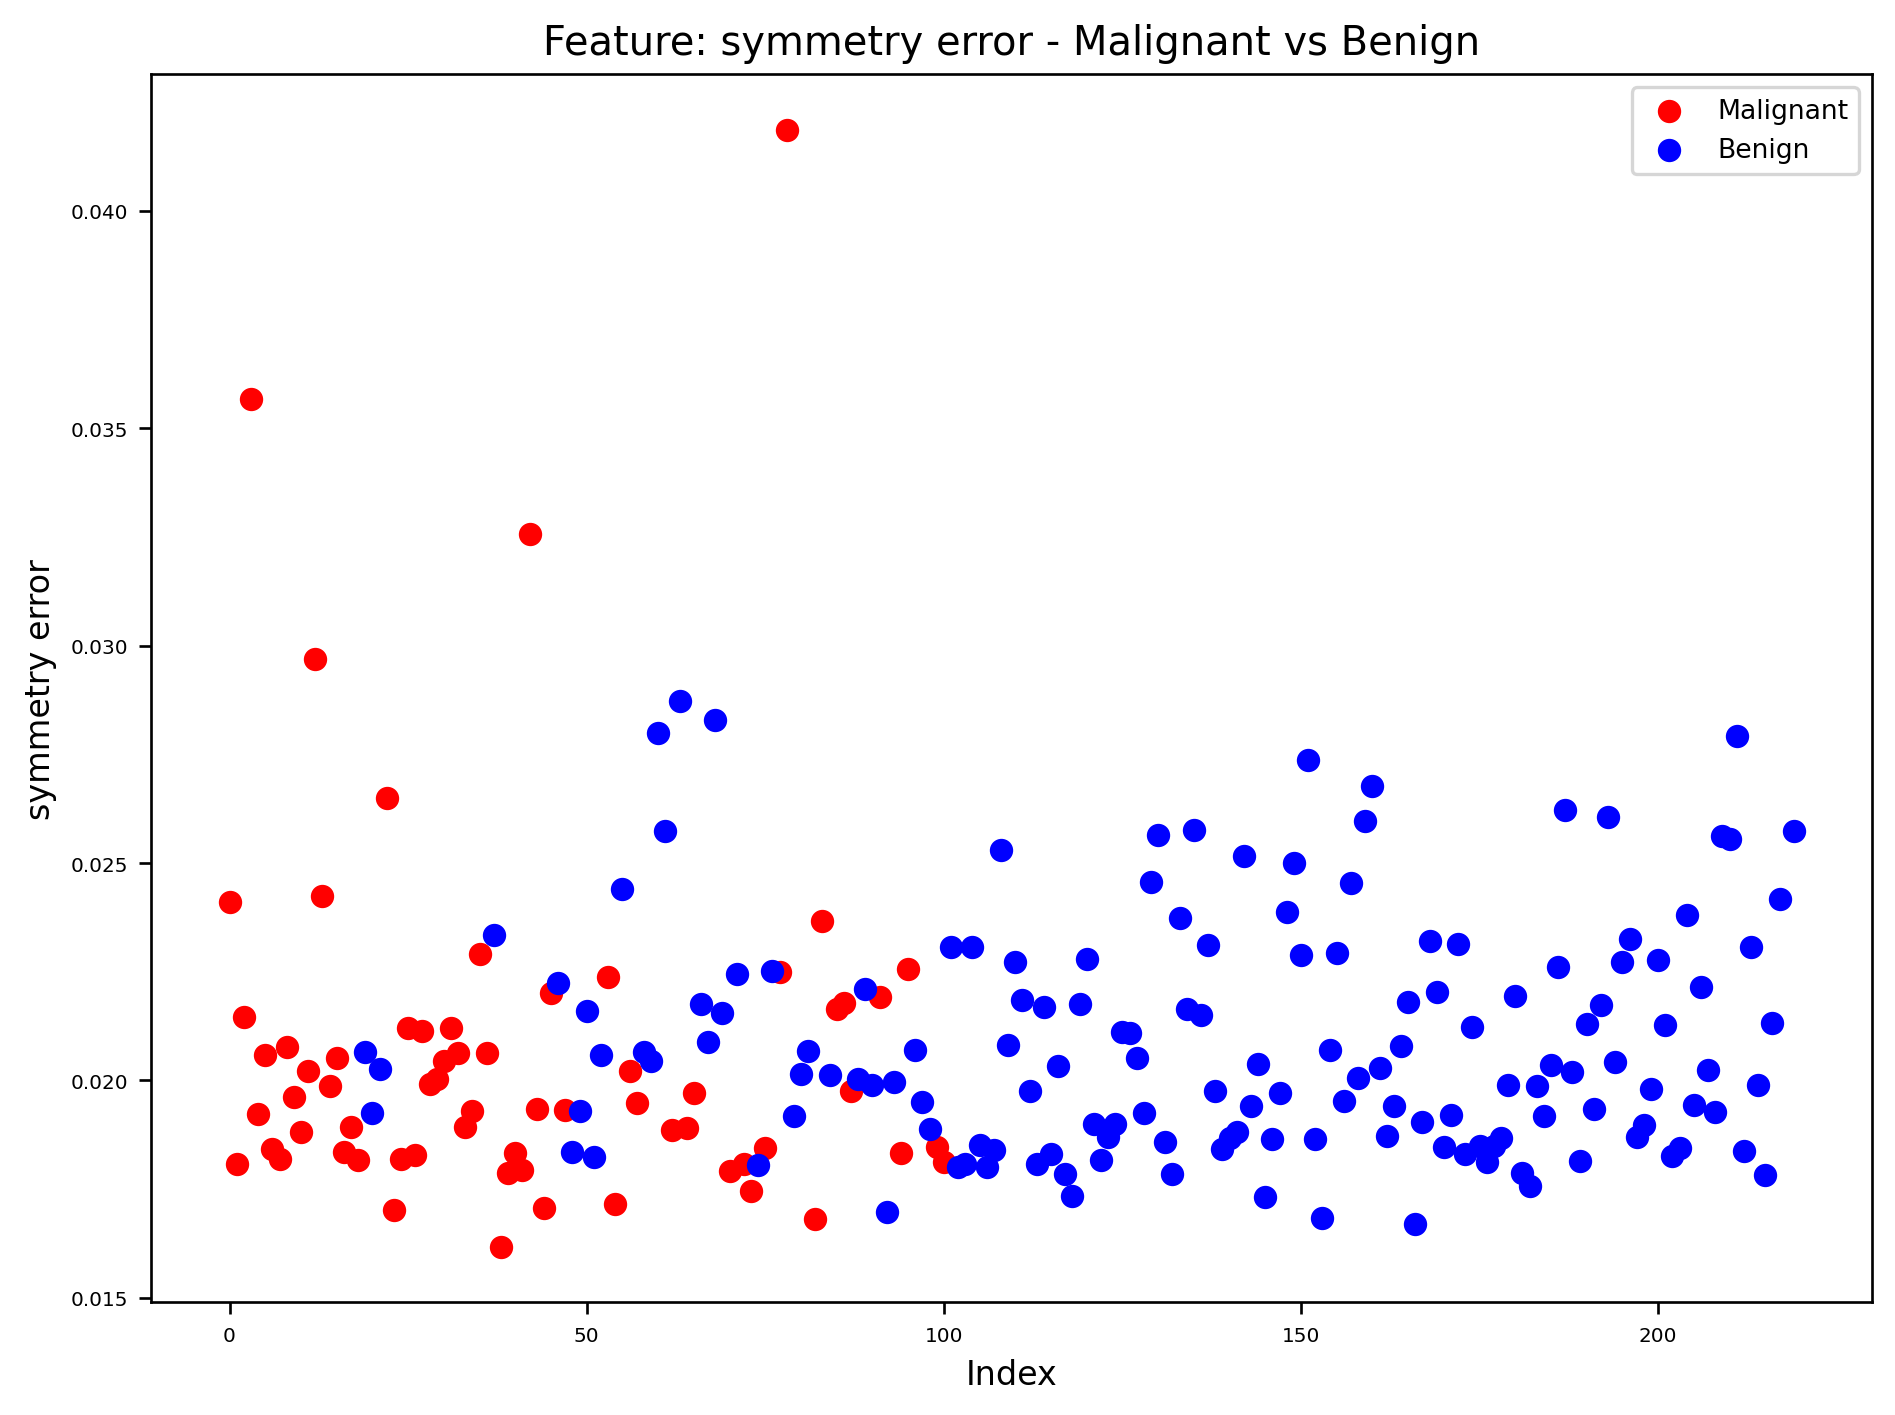

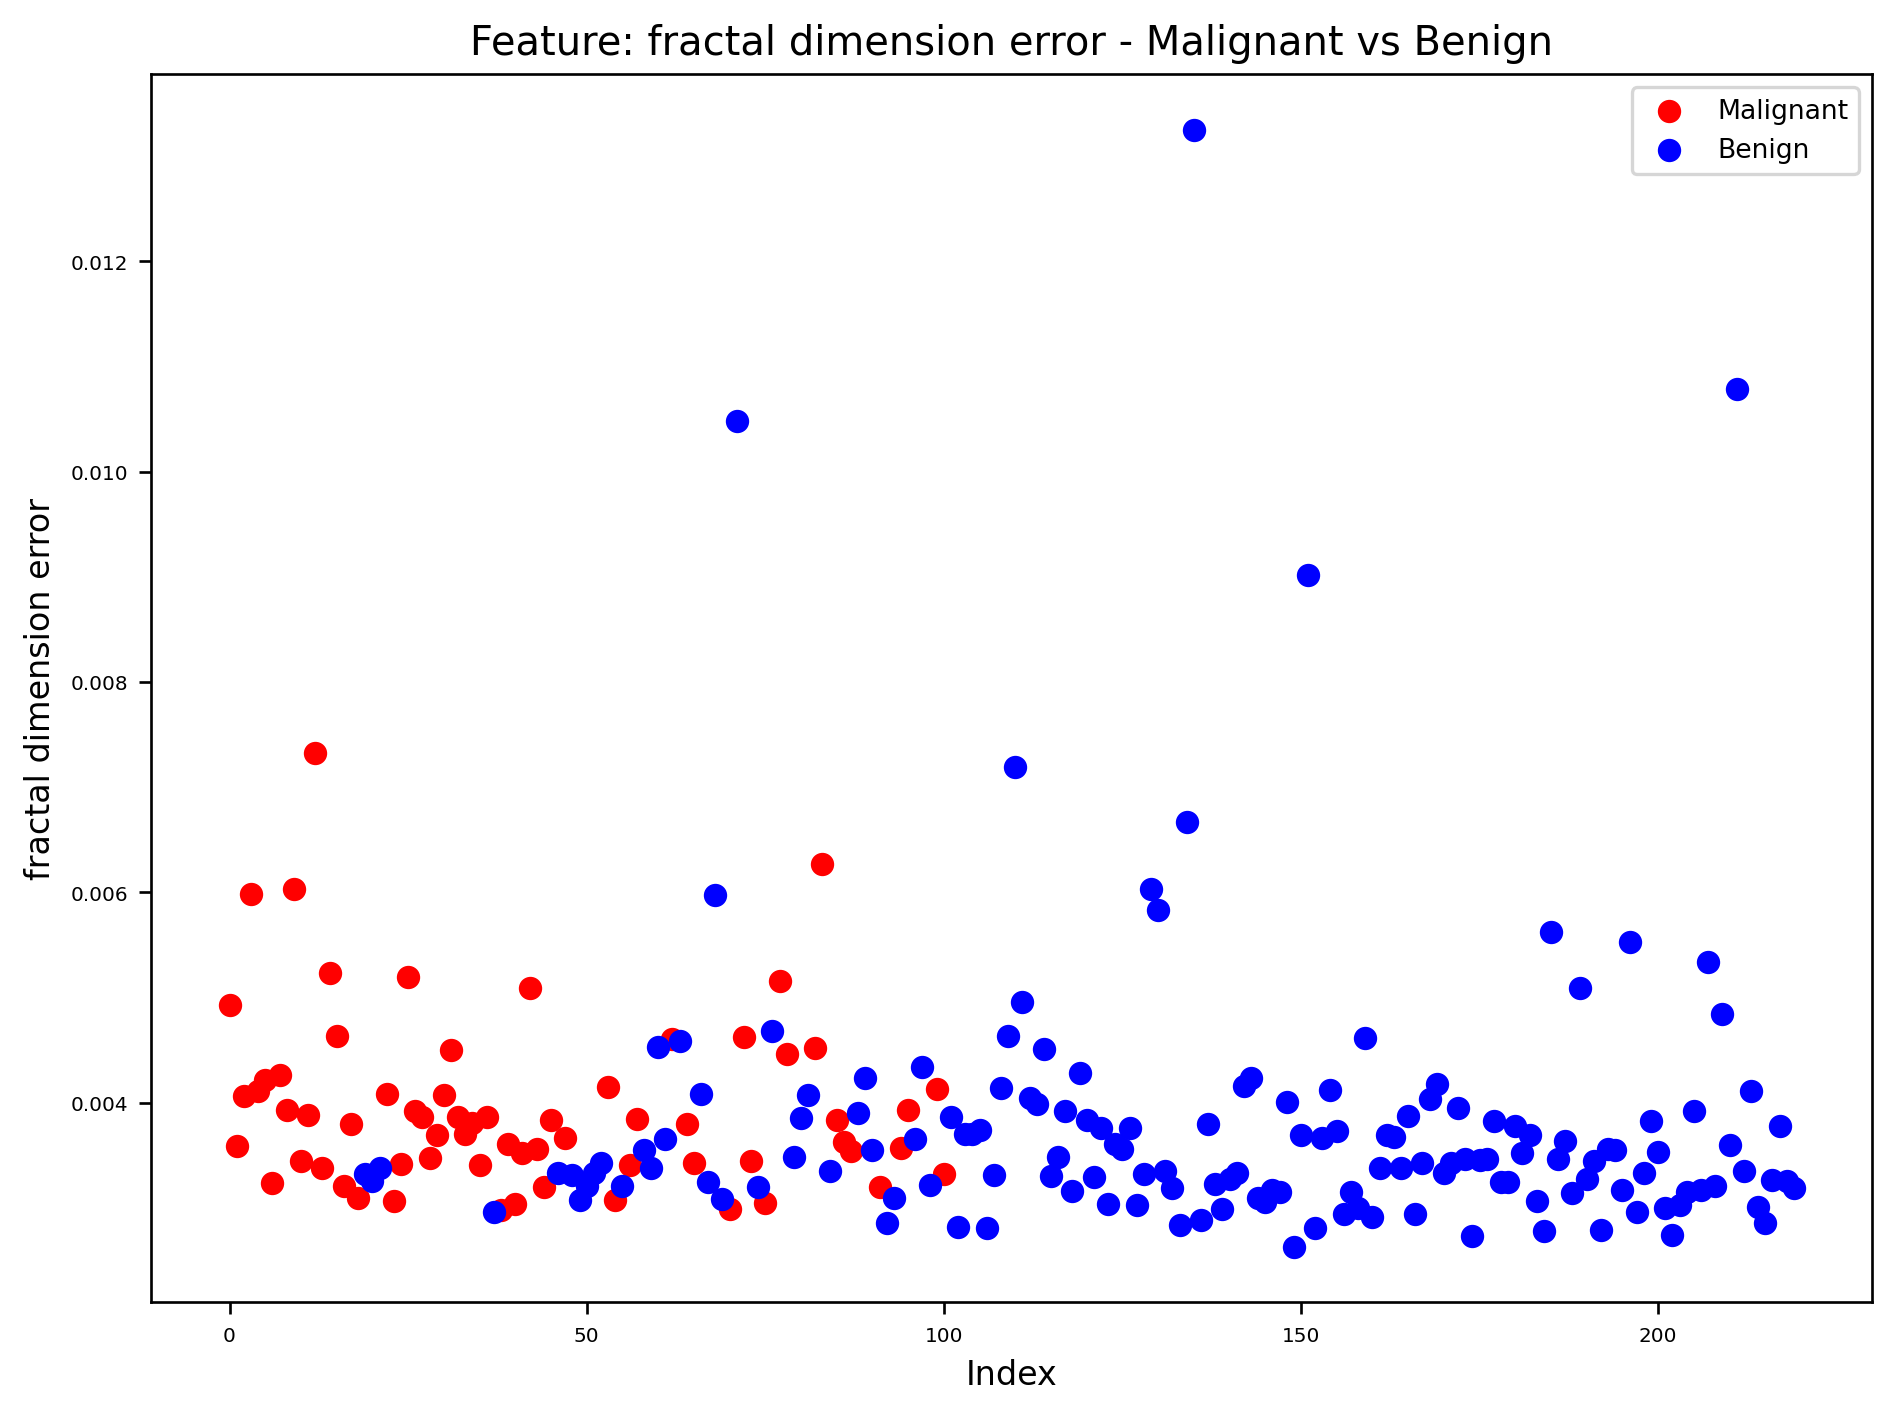

In [475]:
# Plot each feature with enhanced labels and legends
for feature in features:
    plt.figure(figsize=(8, 6))
    
    # Plot malignant data
    plt.scatter(malignant_data.index, malignant_data[feature], color='red', label='Malignant')
    
    # Plot benign data
    plt.scatter(benign_data.index, benign_data[feature], color='blue', label='Benign')
    
    plt.xlabel('Index', fontsize=10)  # x-axis label
    plt.ylabel(feature, fontsize=10)  # y-axis label
    plt.title(f'Feature: {feature} - Malignant vs Benign', fontsize=12)  # descriptive title
    plt.legend(fontsize=8)  # Add legend with adjusted font size
    plt.tight_layout()  # Ensure plots are properly spaced
    plt.show()


For our task, since we're focusing on comparing features between malignant and benign classes, the scatter plot approach might be more beneficial. It allows us to see how individual data points are distributed across the classes, potentially revealing more detailed insights into the feature differences between benign and malignant cases.

This code below identifies outliers in numerical features of a DataFrame using Z-Score, replaces them with NaN, and prints outlier indices for each feature.

In [476]:
# List of all features except the label
features = data.columns[1:]

# Function to identify outliers using Z-Score and replace them with NaN
def replace_outliers_with_nan(df, features, threshold=3):
    df_copy = df.copy()  # Create a copy of the dataframe to modify
    outliers = {}  # Dictionary to store outlier indices
    
    for feature in features:
        mean = df[feature].mean()
        std = df[feature].std()
        z_scores = (df[feature] - mean) / std
        outlier_indices = df.index[np.abs(z_scores) > threshold].tolist()
        
        # Print outlier indices for the current feature
        if outlier_indices:
            print(f"Outliers in {feature} (Z-Score):")
            print(outlier_indices)
        else:
            print(f"No outliers in {feature} (Z-Score)")
        
        # Replace outliers with NaN in the copied dataframe
        df_copy.loc[outlier_indices, feature] = np.nan
    
    return df_copy

# Replace outliers with NaN in the dataset and print outlier indices
data_cleaned = replace_outliers_with_nan(data, features)

Outliers in mean radius (Z-Score):
[130]
Outliers in mean texture (Z-Score):
[179]
Outliers in mean perimeter (Z-Score):
[82]
Outliers in mean area (Z-Score):
[82, 177]
Outliers in mean smoothness (Z-Score):
[3]
Outliers in mean compactness (Z-Score):
[0, 3, 78, 82]
Outliers in mean concavity (Z-Score):
[0, 68, 78, 82, 135]
Outliers in mean concave points (Z-Score):
[0, 78, 82, 83]
Outliers in mean symmetry (Z-Score):
[25, 60, 78]
Outliers in mean fractal dimension (Z-Score):
[63]
Outliers in radius error (Z-Score):
[0, 25, 38]
Outliers in texture error (Z-Score):
[12, 160]
Outliers in perimeter error (Z-Score):
[0, 12, 38, 42, 78, 82]
Outliers in area error (Z-Score):
[0, 12, 77, 82]
Outliers in smoothness error (Z-Score):
[71, 114, 187, 209]
Outliers in compactness error (Z-Score):
[12, 42, 71, 135, 151, 211]
Outliers in concavity error (Z-Score):
[68, 135]
Outliers in concave points error (Z-Score):
[12, 68, 135, 209]
Outliers in symmetry error (Z-Score):
[3, 42, 78]
Outliers in fra

This code verifies that after handling outliers and cleaning the data (data_cleaned), there are no negative values remaining in the numerical columns.

In [477]:
# Check for negative values in numerical columns
negative_values = (data_cleaned[features] < 0).sum()

# Print the columns that have negative values and their counts
print("Columns with negative values and their counts:")
print(negative_values[negative_values > 0])

Columns with negative values and their counts:
Series([], dtype: int64)


During data visualization and summary:

- Outliers detected using z-score were marked as NaN for further handling. They will be filled with the mean after the dataset is split. Negative values were also addressed concurrently.
- Two missing values were identified: one in the 'mean radius' and another in 'symmetry error'. These missing values will also be imputed during preprocessing to ensure completeness of the dataset.
- The column 'label', which serves as the categorical target column with identified imbalance (benign: 154, malignant: 66), will be managed after the dataset is split during preprocessing.
- A mislabeled data point ('maligant') was corrected to 'malignant' to ensure accuracy in visualization and subsequent analysis.

## 2. Prepare data and models, and make baseline measurements [20%]
 - Split data into appropriate sets using the `stratify` option to obtain consistent proportions of classes in each set.
 - Decide on appropriate pre-processing steps for the data.
 - Implement a _very_ simple baseline model that makes purely random predictions of the class.
 - Measure the baseline performance with the following metrics:
   - accuracy
   - balanced accuracy: accounts for imblanaced datasets, defined as _(sensitivity + specificity)/2_
   - recall
   - precision
   - auc
   - f1score
   - fbeta_scores with beta=0.1
   - fbeta_score with beta=10
 - Also display a confusion matrix for the baseline predictions.
 - As a second baseline, implement an SGD classifier and fit it once (without hyper-parameter optimisation) and then display the same performance metrics and a confusion matrix for its results.

This code splits the cleaned dataset (data_cleaned) into training and testing sets (X_train, X_test for features and y_train, y_test for labels) while ensuring proportional class distribution (stratify=y). It then prints the shapes of the resulting sets.

In [478]:
from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your labels (target variable)
X = data_cleaned.drop(columns=['label'])  # Features
y = data_cleaned['label']  # Target variable

# Split the data into training and testing sets, stratifying by y (labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the resulting sets to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (176, 20), y_train shape: (176,)
X_test shape: (44, 20), y_test shape: (44,)


This code defines a preprocessing pipeline (feature_pipeline) that sequentially imputes missing values with the mean and scales numerical features to a specified range using scikit-learn's transformers (SimpleImputer and StandardScaler).

In [479]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# Creating a pipeline for preprocessing features
feature_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler()),  # Scale numerical features
])

This code below its and transforms the training data with the preprocessing pipeline and only transforms the testing data to avoid data leakage.

In [480]:
# Fit and transform features on training data
X_train_preprocessed = feature_pipeline.fit_transform(X_train)

# Transform features on testing data (only transform, no fitting)
X_test_preprocessed = feature_pipeline.transform(X_test)

The code below applies SMOTE to balance the training data by generating synthetic samples for the minority class, using 5 nearest neighbors and a random state of 42.

In [481]:
from imblearn.over_sampling import SMOTE

# Apply Cluster-Based Over Sampling (CBOS) using SMOTE
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

The code encodes the resampled training target variable with LabelEncoder and applies the same encoding to the test target variable.

In [482]:
# Encoding the target variable (if necessary)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)
y_test_encoded = label_encoder.transform(y_test)

The code below is to print the original class names that have been encoded as 0 and 1, showing which original class corresponds to each encoded value.

In [483]:
encoded_classes = label_encoder.classes_
print(f"Class encoded as 0: {encoded_classes[0]}")
print(f"Class encoded as 1: {encoded_classes[1]}")

Class encoded as 0: benign
Class encoded as 1: malignant


The code trains a basic DummyClassifier using a stratified strategy on resampled training data, makes predictions on the test data, computes several performance metrics, and visualizes them alongside the confusion matrix.

Baseline Model (Dummy Classifier) Metrics:
Accuracy: 0.4545
Balanced Accuracy: 0.4789
Recall: 0.5385
Precision: 0.2800
AUC: 0.4789
F1 Score: 0.3684
F-beta Score (beta=0.1): 0.2813
F-beta Score (beta=10): 0.5336

Confusion Matrix (Dummy Classifier):
[[13 18]
 [ 6  7]]


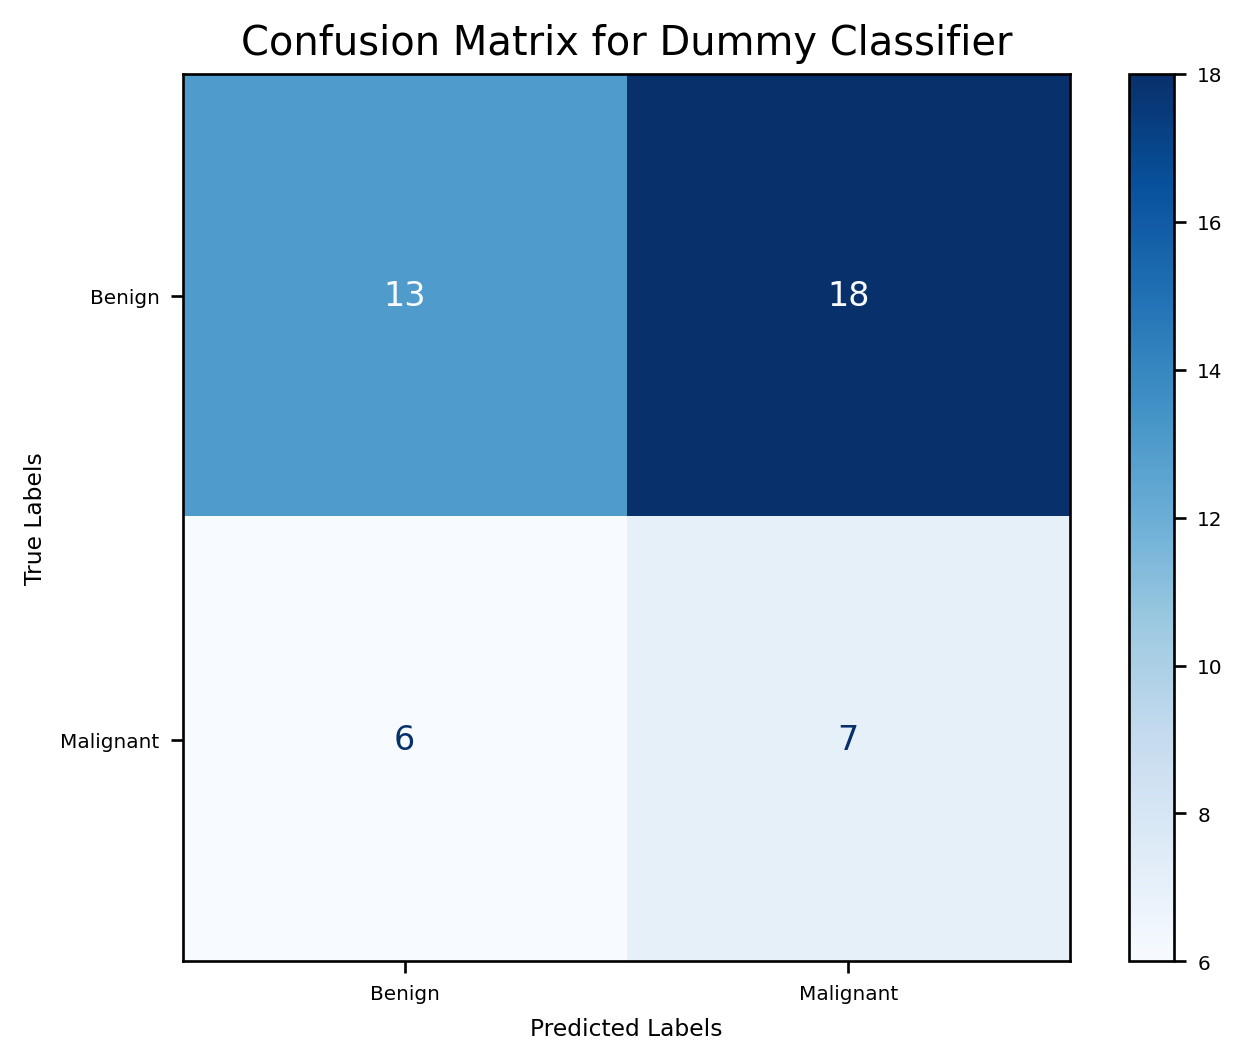

In [484]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, \
                            roc_auc_score, f1_score, confusion_matrix,fbeta_score
from sklearn.metrics import ConfusionMatrixDisplay

# Instantiate a random classifier (stratified)
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train_resampled, y_train_encoded)
y_pred_dummy = dummy_clf.predict(X_test_preprocessed)

# Calculate metrics
accuracy_dummy = accuracy_score(y_test_encoded, y_pred_dummy)
balanced_accuracy_dummy = balanced_accuracy_score(y_test_encoded, y_pred_dummy)

# For metrics focusing on positive class (pos_label=1)
recall_dummy = recall_score(y_test_encoded, y_pred_dummy, pos_label=1)
precision_dummy = precision_score(y_test_encoded, y_pred_dummy, pos_label=1)
f1_dummy = f1_score(y_test_encoded, y_pred_dummy, pos_label=1)
fbeta_01_dummy = fbeta_score(y_test_encoded, y_pred_dummy, beta=0.1, pos_label=1)
fbeta_10_dummy = fbeta_score(y_test_encoded, y_pred_dummy, beta=10, pos_label=1)

# AUC score doesn't require pos_label
auc_dummy = roc_auc_score(y_test_encoded, y_pred_dummy)


# Confusion Matrix
conf_matrix_dummy = confusion_matrix(y_test_encoded, y_pred_dummy)

# Display metrics
print("Baseline Model (Dummy Classifier) Metrics:")
print(f"Accuracy: {accuracy_dummy:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_dummy:.4f}")
print(f"Recall: {recall_dummy:.4f}")
print(f"Precision: {precision_dummy:.4f}")
print(f"AUC: {auc_dummy:.4f}")
print(f"F1 Score: {f1_dummy:.4f}")
print(f"F-beta Score (beta=0.1): {fbeta_01_dummy:.4f}")
print(f"F-beta Score (beta=10): {fbeta_10_dummy:.4f}")
print("\nConfusion Matrix (Dummy Classifier):")
print(conf_matrix_dummy)


# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_dummy)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)

# Set title and axis labels
plt.title("Confusion Matrix for Dummy Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.grid(False)  # Disable the grid for better readability

plt.show()

This code trains an SGD classifier on the resampled training data, predicts on the test data, calculates various performance metrics, and displays them along with the confusion matrix.


SGD Classifier Metrics on Test Data:
Accuracy: 0.9545
Balanced Accuracy: 0.9231
Recall: 0.8462
Precision: 1.0000
AUC: 0.9231
F1 Score: 0.9167
F-beta Score (beta=0.1): 0.9982
F-beta Score (beta=10): 0.8474

Confusion Matrix (SGD Classifier - Test Data):
[[31  0]
 [ 2 11]]


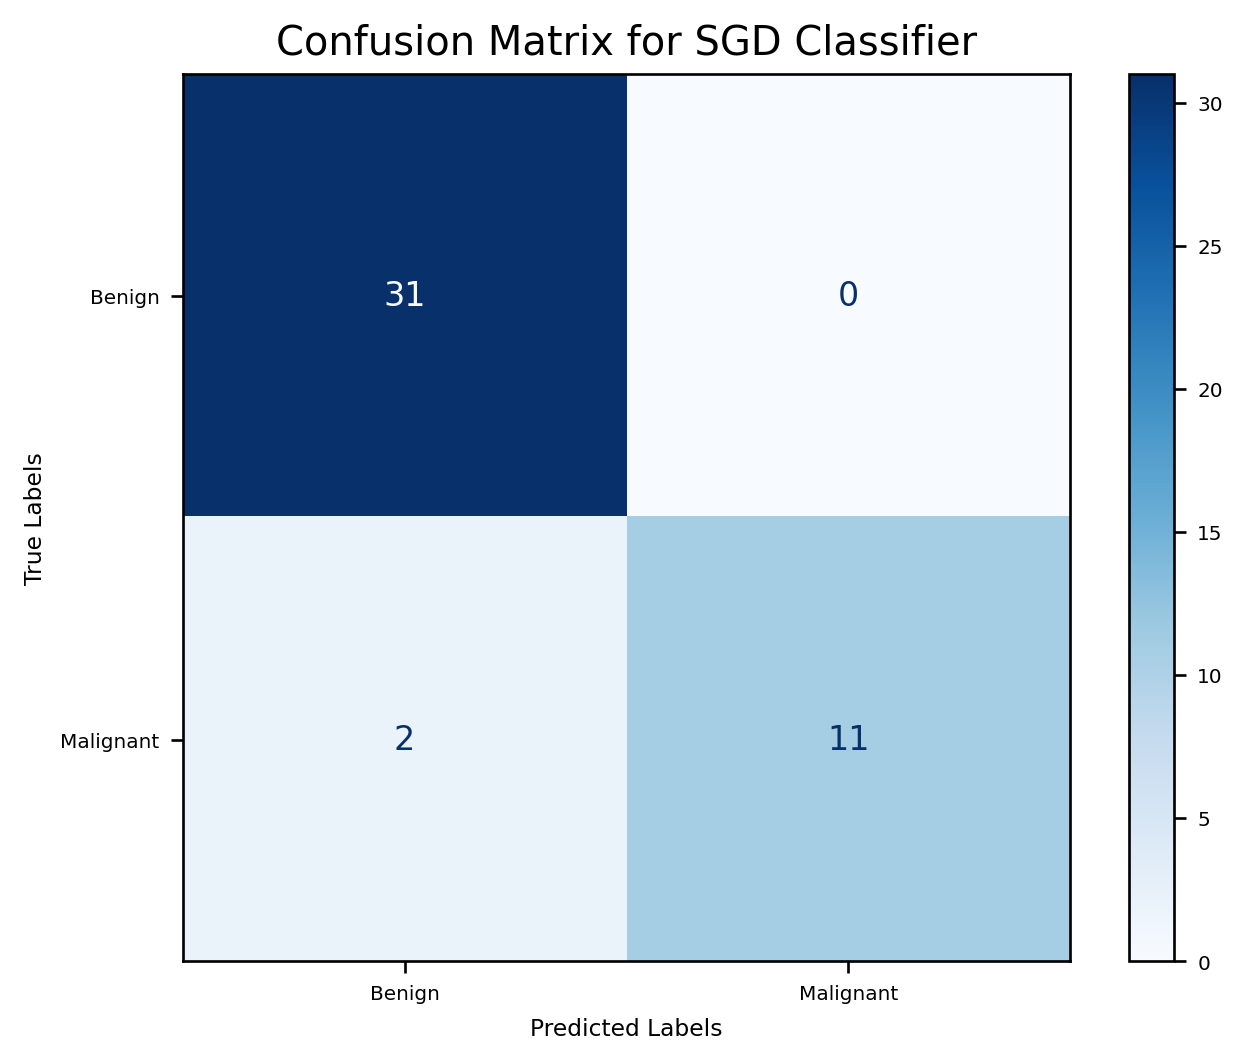

In [485]:
from sklearn.linear_model import SGDClassifier

# Instantiate SGD classifier
sgd_clf = SGDClassifier(random_state=42)

# Fit the classifier on the resampled training data
sgd_clf.fit(X_train_resampled, y_train_encoded)

# Predict on the test set
y_pred_sgd = sgd_clf.predict(X_test_preprocessed)

# Calculate performance metrics on test data
accuracy_sgd = accuracy_score(y_test_encoded, y_pred_sgd)
balanced_accuracy_sgd = balanced_accuracy_score(y_test_encoded, y_pred_sgd)
recall_sgd = recall_score(y_test_encoded, y_pred_sgd,pos_label=1)
precision_sgd = precision_score(y_test_encoded, y_pred_sgd, pos_label=1)
auc_sgd = roc_auc_score(y_test_encoded, y_pred_sgd)
f1_sgd = f1_score(y_test_encoded, y_pred_sgd, pos_label=1)
fbeta_01_sgd = fbeta_score(y_test_encoded, y_pred_sgd, beta=0.1, pos_label=1)
fbeta_10_sgd = fbeta_score(y_test_encoded, y_pred_sgd, beta=10, pos_label=1)

# Display metrics for test data
print("\nSGD Classifier Metrics on Test Data:")
print(f"Accuracy: {accuracy_sgd:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_sgd:.4f}")
print(f"Recall: {recall_sgd:.4f}")
print(f"Precision: {precision_sgd:.4f}")
print(f"AUC: {auc_sgd:.4f}")
print(f"F1 Score: {f1_sgd:.4f}")
print(f"F-beta Score (beta=0.1): {fbeta_01_sgd:.4f}")
print(f"F-beta Score (beta=10): {fbeta_10_sgd:.4f}")

# Confusion Matrix for test data
conf_matrix_sgd = confusion_matrix(y_test_encoded, y_pred_sgd)
print("\nConfusion Matrix (SGD Classifier - Test Data):")
print(conf_matrix_sgd)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_sgd)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)

# Set title and axis labels
plt.title("Confusion Matrix for SGD Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.grid(False)  # Disable the grid for better readability

plt.show()

## 3. Model Optimisation [40%]

### 3.1 Performance metric
Choose one performance metric from the above set. State your choice and explain why you chose it. [50 words maximum]

I would choose Recall for its critical role in detecting over 90% of malignant cases, ensuring accurate cancer diagnosis and patient safety. It prioritizes sensitivity, minimizing missed diagnoses, aligning with healthcare's accuracy standards. This metric also indirectly lowers false positives, vital for distinguishing between malignant and benign cases accurately.

### 3.2 Hyper-parameter optimisation
 - Perform a hyper-parameter optimisation (using appropriate methods) on three models:
   - SGD Classifer
   - SVM
   - One other model of your choice
 - Display the results of each model (including confusion matrices) and choose the best model.
 - Choose the best model and display the final results of this model.

In [486]:
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, recall_score, precision_score, 
                             roc_auc_score, f1_score, fbeta_score, confusion_matrix)
import itertools

This code below defines pipelines for three models (SGD Classifier, SVM, and Random Forest) and specifies parameter grids for each model to facilitate hyper-parameter optimization.

In [487]:
# Defines our models and parameter grids for hyper-parameter optimization
pipelines = {
    'SGD Classifier': Pipeline([
        ('sgd', SGDClassifier(random_state=42))
    ]),
    'SVM': Pipeline([
        ('svm', SVC(random_state=42, probability=True))  # Set probability=True for ROC AUC calculation
    ]),
    'Random Forest': Pipeline([
        ('rf', RandomForestClassifier(random_state=42))
    ])
}

param_grids = {
    'SGD Classifier': {
        'sgd__alpha': [0.0001, 0.001, 0.01, 0.1, 1],
        'sgd__max_iter': [1000, 5000, 10000],
        'sgd__loss': ['hinge', 'modified_huber'],
        'sgd__class_weight': ['balanced', None]
    },
    'SVM': {
        'svm__C': [0.1, 1, 10, 100],
        'svm__kernel': ['linear', 'rbf'],
        'svm__gamma': ['scale', 'auto'],
        'svm__class_weight': ['balanced', None]
    },
    'Random Forest': {
        'rf__n_estimators': [50, 100, 200],
        'rf__max_depth': [None, 10, 20, 30],
        'rf__min_samples_split': [2, 5, 10],
        'rf__min_samples_leaf': [1, 2, 4],
        'rf__class_weight': ['balanced', None]
    }
}

This code below defines functions to perform grid search cross-validation (GridSearchCV) on pipelines of three models (SGD Classifier, SVM, and Random Forest), optimizing hyperparameters specified in param_grids. It evaluates each model's performance on resampled training data and displays metrics on the test set. The plot_confusion_matrix function visualizes the confusion matrix for each model.

In [488]:
# Initialize dictionaries
grid_searches = {}
best_models = {}

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Function to perform grid search and evaluate models
def evaluate_model(name, pipeline, param_grid):
    print(f"Hyperparameter optimization for {name}:")
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', verbose=1, n_jobs=-1, error_score='raise')
    grid_search.fit(X_train_resampled, y_train_encoded)
    print("Best parameters found:")
    print(grid_search.best_params_)
    
    # Store the grid search and best model
    grid_searches[name] = grid_search
    best_models[name] = grid_search.best_estimator_
    
    # Evaluate on test set
    y_pred = grid_search.predict(X_test_preprocessed)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test_encoded, y_pred)
    recall = recall_score(y_test_encoded, y_pred, pos_label=1)
    precision = precision_score(y_test_encoded, y_pred, pos_label=1)
    auc = None
    if hasattr(grid_search.best_estimator_, 'predict_proba'):
        auc = roc_auc_score(y_test_encoded, grid_search.predict_proba(X_test_preprocessed)[:, 1])
    else:
        print(f"AUC calculation not available for {name}.")
    f1 = f1_score(y_test_encoded, y_pred, pos_label=1)
    fbeta_01 = fbeta_score(y_test_encoded, y_pred, beta=0.1, pos_label=1)
    fbeta_10 = fbeta_score(y_test_encoded, y_pred, beta=10, pos_label=1)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_encoded, y_pred)
    
    # Display results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    if auc is not None:
        print(f"AUC: {auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Fbeta Score (beta=0.1): {fbeta_01:.4f}")
    print(f"Fbeta Score (beta=10): {fbeta_10:.4f}")
    print(f"Confusion Matrix for {name}:")
    print(conf_matrix)
    print("\n")

     # Plot confusion matrix
    plot_confusion_matrix(conf_matrix, classes=['benign', 'malignant'], title=f"Confusion Matrix for {name}")

    plt.show()
    
    return grid_search

Hyperparameter optimization for SGD Classifier:
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters found:
{'sgd__alpha': 0.1, 'sgd__class_weight': 'balanced', 'sgd__loss': 'modified_huber', 'sgd__max_iter': 1000}
Accuracy: 0.9091
Balanced Accuracy: 0.8908
Recall: 0.8462
Precision: 0.8462
AUC: 0.9901
F1 Score: 0.8462
Fbeta Score (beta=0.1): 0.8462
Fbeta Score (beta=10): 0.8462
Confusion Matrix for SGD Classifier:
[[29  2]
 [ 2 11]]




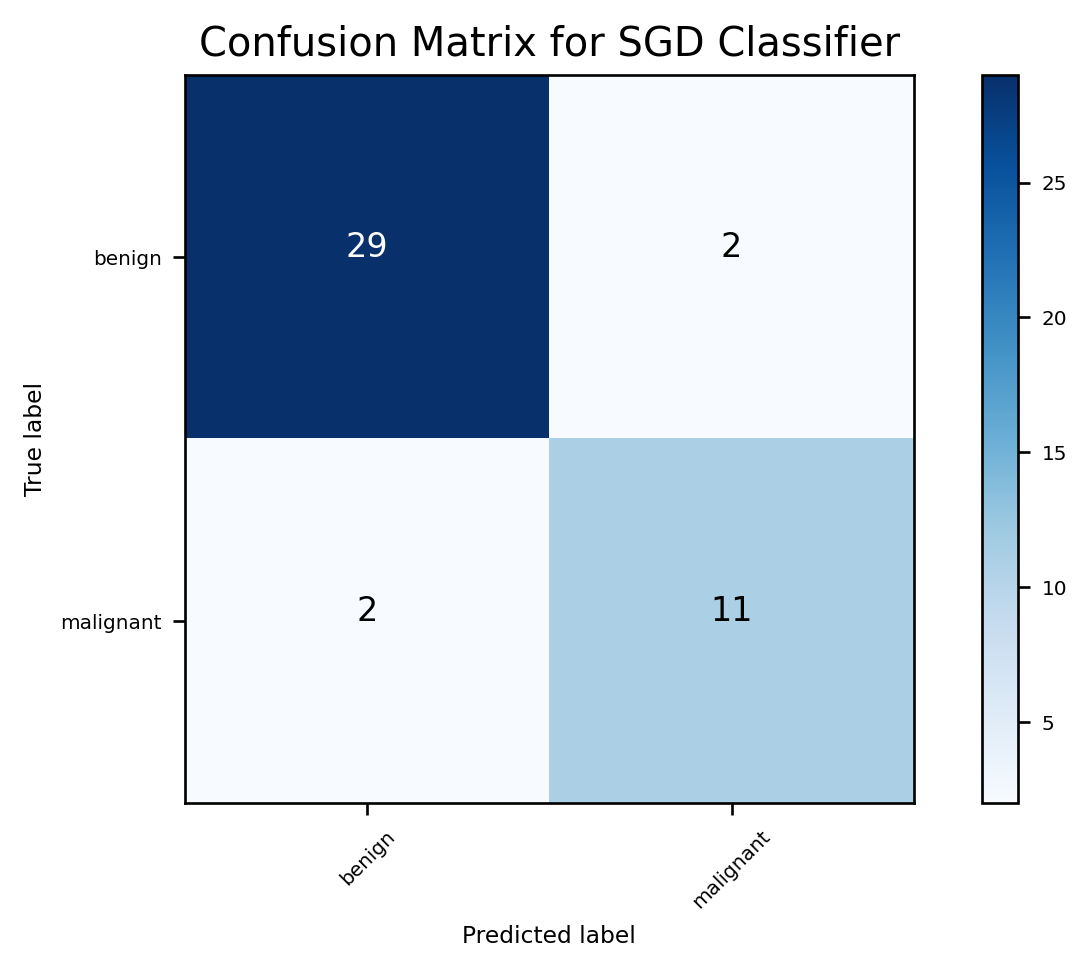

Hyperparameter optimization for SVM:
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters found:
{'svm__C': 1, 'svm__class_weight': 'balanced', 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Accuracy: 0.9318
Balanced Accuracy: 0.9293
Recall: 0.9231
Precision: 0.8571
AUC: 0.9752
F1 Score: 0.8889
Fbeta Score (beta=0.1): 0.8577
Fbeta Score (beta=10): 0.9224
Confusion Matrix for SVM:
[[29  2]
 [ 1 12]]




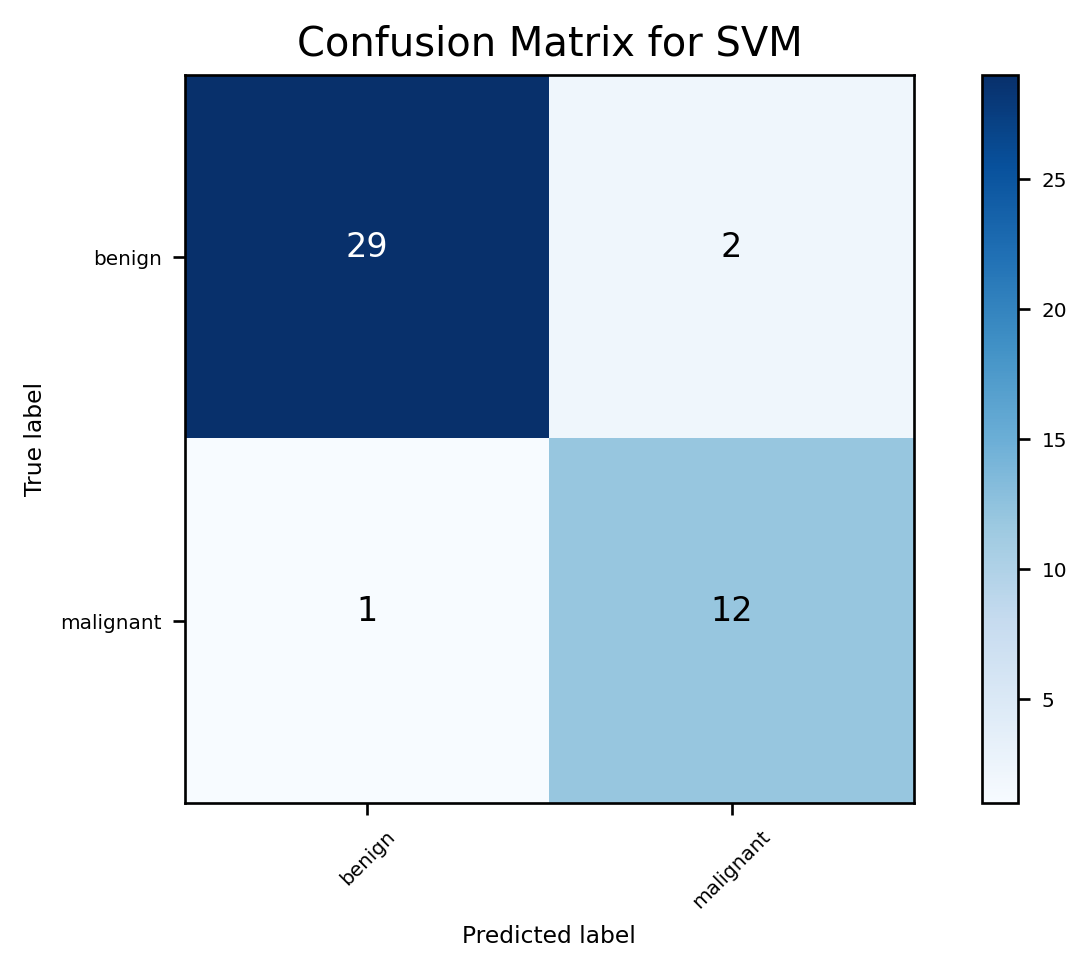

Hyperparameter optimization for Random Forest:
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found:
{'rf__class_weight': 'balanced', 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Accuracy: 0.8636
Balanced Accuracy: 0.8139
Recall: 0.6923
Precision: 0.8182
AUC: 0.9801
F1 Score: 0.7500
Fbeta Score (beta=0.1): 0.8167
Fbeta Score (beta=10): 0.6934
Confusion Matrix for Random Forest:
[[29  2]
 [ 4  9]]




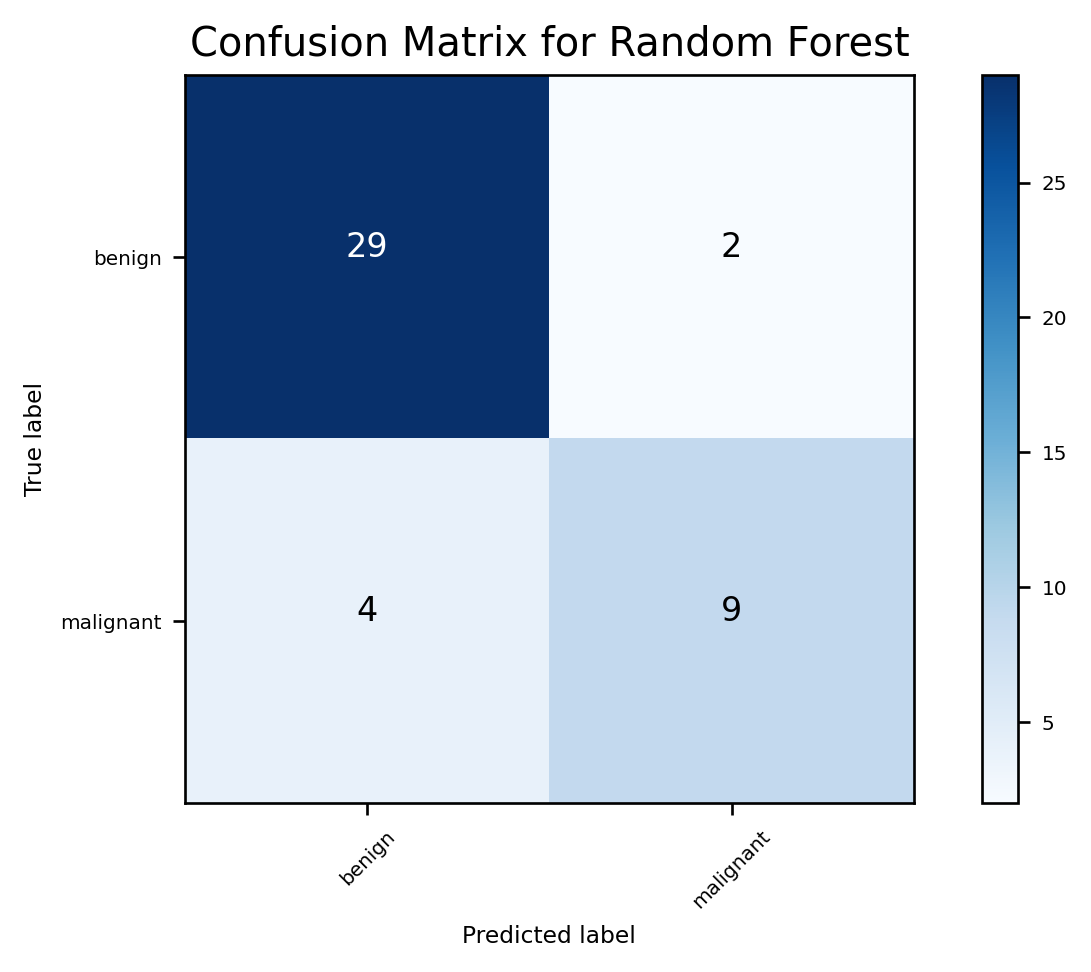

In [489]:
# Perform evaluation for each model
for name, pipeline in pipelines.items():
    evaluate_model(name, pipeline, param_grids[name])

Best Model based on Recall: SVM
Best parameters: {'svm__C': 1, 'svm__class_weight': 'balanced', 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

Final Evaluation Metrics for Best Model:
Accuracy: 0.9318
Balanced Accuracy: 0.9293
Recall: 0.9231
Precision: 0.8571
AUC: 0.9752
F1 Score: 0.8889
Fbeta Score (beta=0.1): 0.8577
Fbeta Score (beta=10): 0.9224
Confusion Matrix for the Best Model:
[[29  2]
 [ 1 12]]


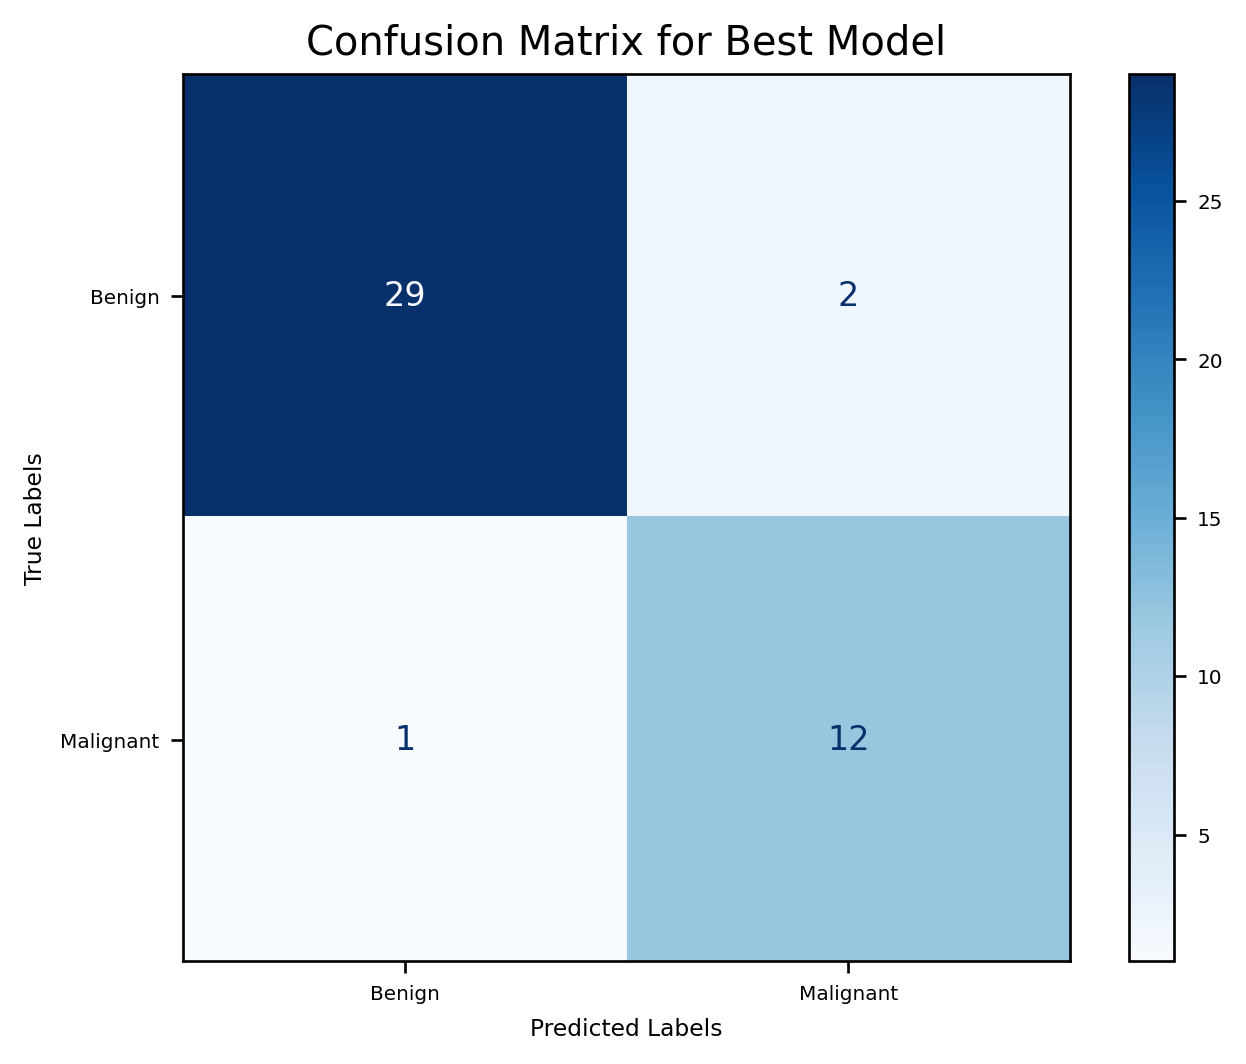

In [490]:
# Choose the best model based on Recall
best_model_name = max(best_models, key=lambda x: recall_score(y_test_encoded, best_models[x].predict(X_test_preprocessed), pos_label=1))

# Display final results of the best model
best_model = best_models[best_model_name]
print(f"Best Model based on Recall: {best_model_name}")
print(f"Best parameters: {grid_searches[best_model_name].best_params_}")

# Final evaluation with best model
y_pred_best = best_model.predict(X_test_preprocessed)
accuracy_best = accuracy_score(y_test_encoded, y_pred_best)
balanced_accuracy_best = balanced_accuracy_score(y_test_encoded, y_pred_best)
recall_best = recall_score(y_test_encoded, y_pred_best, pos_label=1)
precision_best = precision_score(y_test_encoded, y_pred_best, pos_label=1)
auc_best = None
if hasattr(best_model, 'predict_proba'):
    auc_best = roc_auc_score(y_test_encoded, best_model.predict_proba(X_test_preprocessed)[:, 1])
else:
    print(f"AUC calculation not available for the best model.")
f1_best = f1_score(y_test_encoded, y_pred_best, pos_label=1)
fbeta_01_best = fbeta_score(y_test_encoded, y_pred_best, beta=0.1, pos_label=1)
fbeta_10_best = fbeta_score(y_test_encoded, y_pred_best, beta=10, pos_label=1)

print("\nFinal Evaluation Metrics for Best Model:")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_best:.4f}")
print(f"Recall: {recall_best:.4f}")
print(f"Precision: {precision_best:.4f}")
if auc_best is not None:
    print(f"AUC: {auc_best:.4f}")
print(f"F1 Score: {f1_best:.4f}")
print(f"Fbeta Score (beta=0.1): {fbeta_01_best:.4f}")
print(f"Fbeta Score (beta=10): {fbeta_10_best:.4f}")
print(f"Confusion Matrix for the Best Model:")
print(confusion_matrix(y_test_encoded, y_pred_best))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_best)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])

# Set the title and axis labels
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.grid(False)  # Disable the grid for better readability
plt.show()

**Visualisation of Best Model**
1. ROC Curve - This code segment below calculates and plots the Receiver Operating Characteristic (ROC) curve for a binary classifier (best_model) if it supports probability predictions (predict_proba). It calculates the False Positive Rate (FPR) and True Positive Rate (TPR) using roc_curve, computes the Area Under the Curve (AUC) using auc, and visualizes the ROC curve with associated AUC value using matplotlib.

This ROC curve represents a model with excellent discriminative ability, likely suitable for applications where high accuracy and reliable predictions are crucial. 

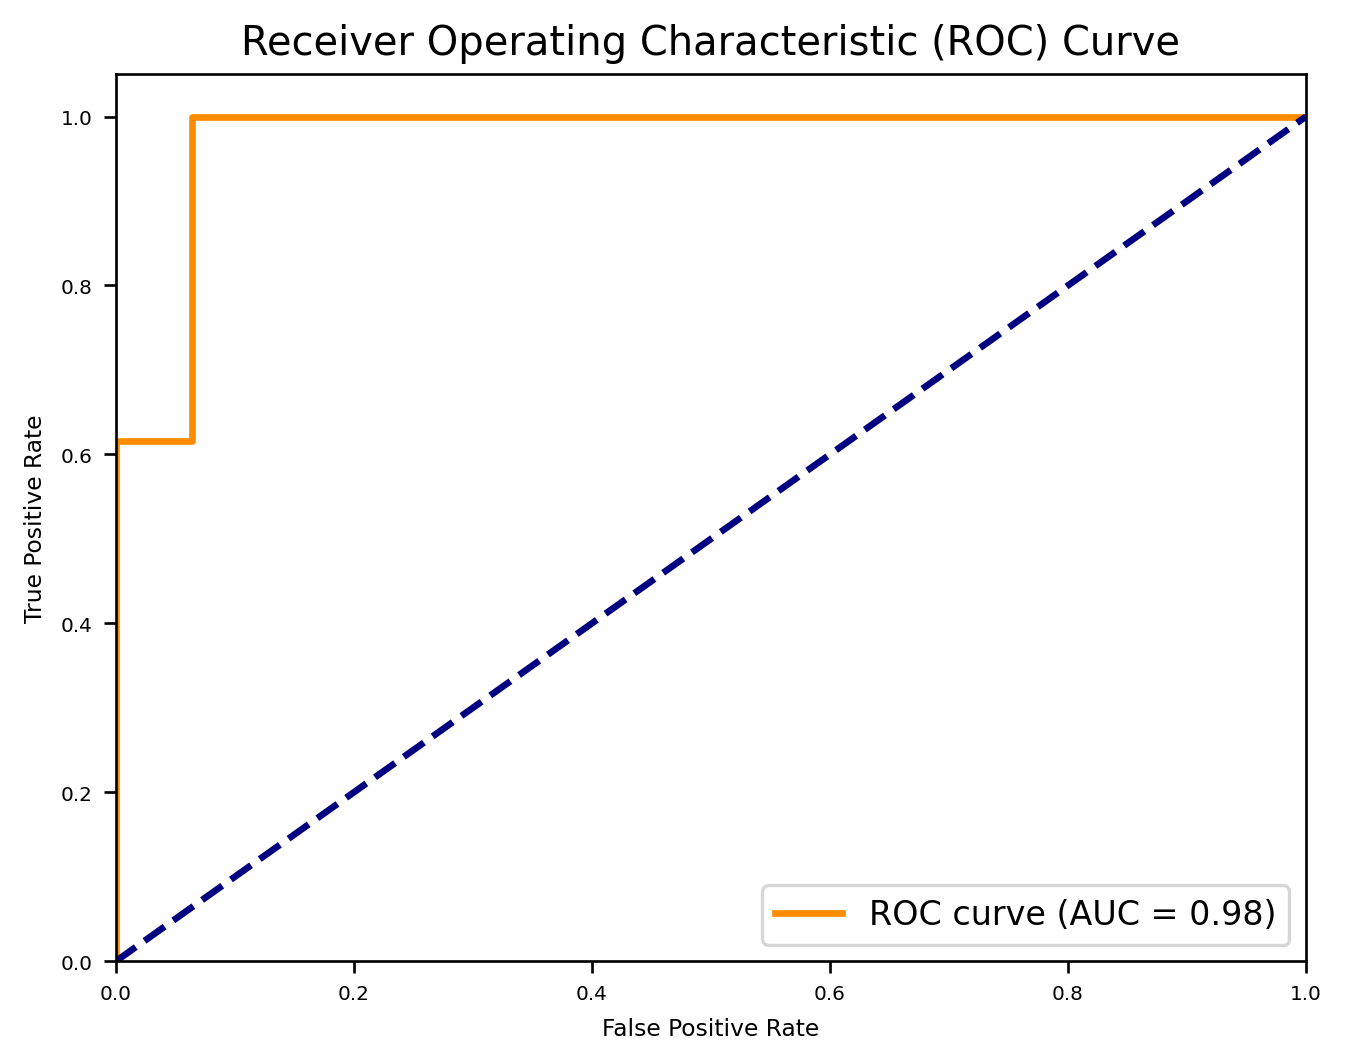

In [491]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

if hasattr(best_model, 'predict_proba') and hasattr(best_model, 'classes_'):
    # Ensure predictions are made on the test set
    y_score = best_model.predict_proba(X_test_preprocessed)[:, best_model.classes_ == 1]

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test_encoded, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve and AUC visualization not available for this model.")


2. This code below uses plot_learning_curve function and creates a graph displaying how the training and cross-validation scores vary with increasing training examples, aiding in evaluating model performance and generalization.

This learning curve depicts a well-performing SVM model that effectively utilizes increasing amounts of training data to improve its generalization capabilities. The model appears to be a good fit for the problem, with low bias and decreasing variance as more data is introduced.

In [492]:
# Function to plot learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, scoring='recall')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

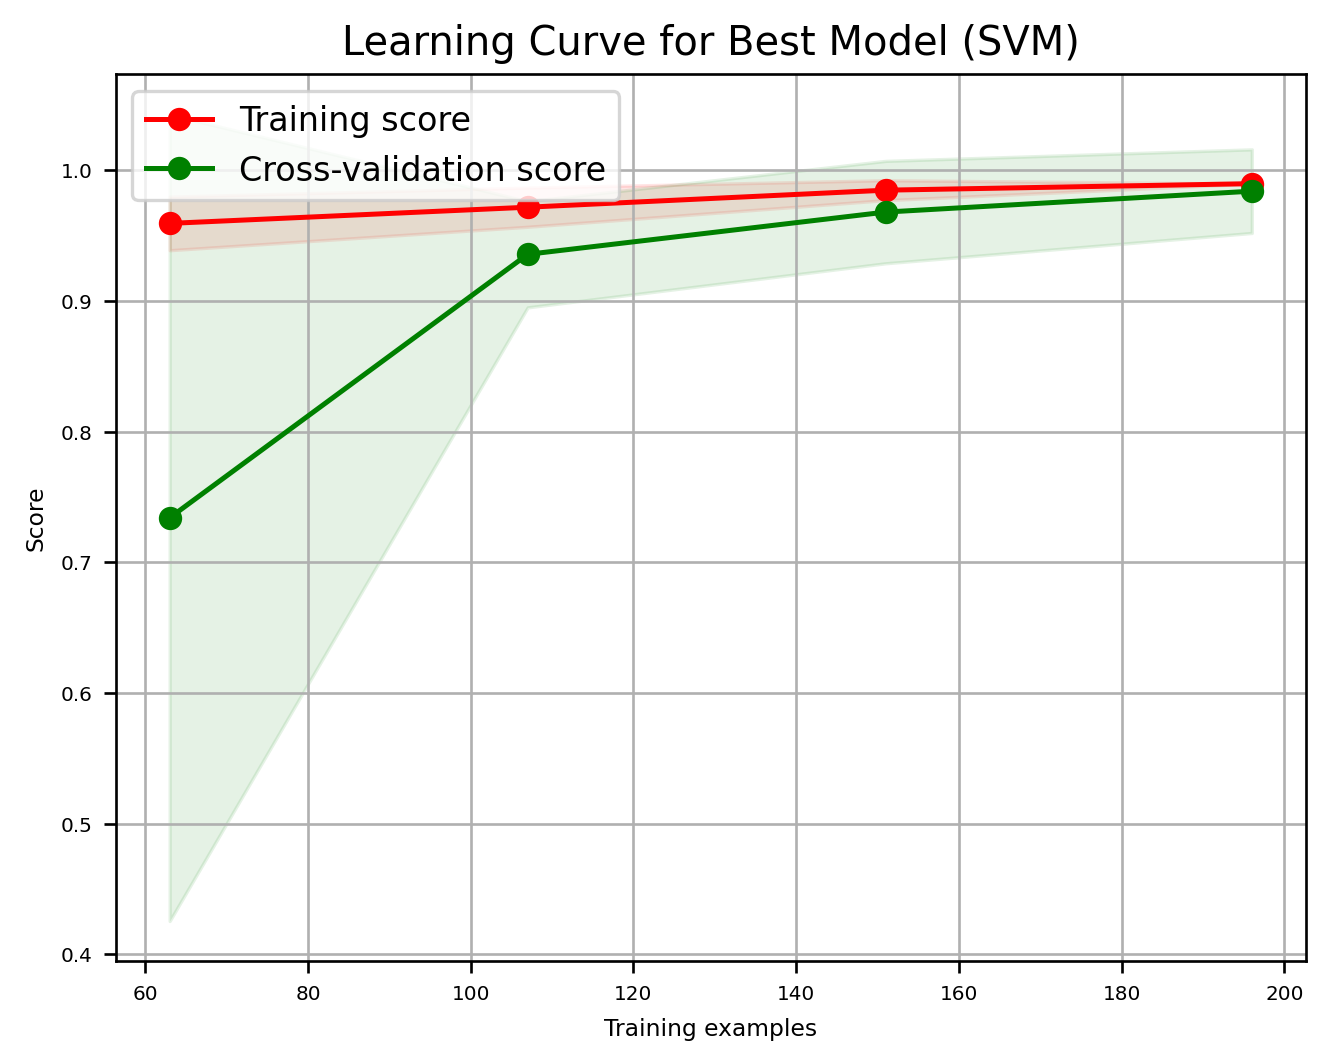

In [493]:
# Plot learning curve for the best model
plot_learning_curve(best_model, f"Learning Curve for Best Model ({best_model_name})", X_train_resampled, y_train_encoded, cv=5, n_jobs=-1)
plt.show()

### 3.3 Final results

From the final results calculate the _probability_ that a sample from a person with a malignant tumour is given a result that they do not have cancer.

From the confusion matrix of the final model - 

- TN (True Negatives): Correctly predicted benign cases = 29
- FP (False Positives): Incorrectly predicted malignant cases (Type I error) = 2
- FN (False Negatives): Incorrectly predicted benign cases (Type II error) = 1
- TP (True Positives): Correctly predicted malignant cases = 12

False Negative (FN): This represents cases where the model predicted benign (0) but the actual class was malignant (1).

To find the probability of a false negative given a malignant tumor:

𝑃 (False Negative | Malignant) = False Negatives / (False Negatives + True Positives) = 1 / (1+12) = 0.0769

Therefore, the probability that a sample from a person with a malignant tumor is given a false negative result (predicted as benign when it is actually malignant) is approximately 0.0769 or 7.69%. 

## 4. Decision Boundaries [10%]
 - To finish up, the client wants a visualisation of how the final model is working and your line manager has asked you to show some of the decision boundaries.
 - The client also wants to know if your method has met their performance specifications.
 - Follow the next three steps (4.1, 4.2 and 4.3) to do these things.

### 4.1 Discriminative features

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a T-score (often used in statistics, and in the LDA machine learning method) for each feature.  

The formula for the T-score is:

_(mean(x2) - mean(x1))/(0.5*(stddev(x2) + stddev(x1)))_

where x1 and x2 are the feature values corresponding to the two classes. Large values for the T-score (either positive or negative) indicate discriminative ability.

**Calculate the T-score for each feature and print out the best 4 features according to this score.**

To calculate the t-score for decision boundary visualization, we need to address missing values separately. This is necessary because our previous preprocessing pipeline handled imputation and scaling for the entire training data together. For visualizing decision boundaries, we specifically require the original, unscaled data.

In [494]:
# Create an imputer instance with the desired strategy
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform it
X_train_preprocessed_db = imputer.fit_transform(X_train)

# Transform the test data using the fitted imputer (do not fit again)
X_test_preprocessed_db = imputer.transform(X_test)

In [495]:
# Encoding the target variable (if necessary)
label_encoder = LabelEncoder()
y_train_encoded_db = label_encoder.fit_transform(y_train)
y_test_encoded_db = label_encoder.transform(y_test)

In [496]:
# Initialize a list to store T-scores
t_scores = []

# Iterate over each feature in X_train.columns
for feature in X_train.columns:
    # Extract feature values for 'benign' (class 0) and 'malignant' (class 1) in training set
    x1_train = X_train_preprocessed_db[y_train_encoded_db == 0][:, X_train.columns.get_loc(feature)]
    x2_train = X_train_preprocessed_db[y_train_encoded_db == 1][:, X_train.columns.get_loc(feature)]
    
    # Calculate mean difference
    mean_diff = np.mean(x2_train) - np.mean(x1_train)
    
    # Calculate standard deviation
    std_dev = 0.5 * (np.std(x2_train) + np.std(x1_train))
    
    # Calculate T-score
    if std_dev == 0 or np.isnan(std_dev):
        t_score = 0
    else:
        t_score = mean_diff / std_dev
    
    # Store absolute T-score along with feature name
    t_scores.append((feature, abs(t_score)))

# Sort features by T-score in descending order
t_scores.sort(key=lambda x: x[1], reverse=True)

# Print the top 4 features based on T-score
print("Top 4 features based on T-score:")
for i, (feature, score) in enumerate(t_scores[:4], 1):
    print(f"{i}. Feature: {feature}, T-score: {score}")


Top 4 features based on T-score:
1. Feature: mean concave points, T-score: 2.356249131895552
2. Feature: mean concavity, T-score: 2.0428772469497454
3. Feature: mean perimeter, T-score: 1.8671644315375429
4. Feature: mean area, T-score: 1.760374619276486


### 4.2 Visualise decision boundaries

**Display the decision boundaries** for each pair of features from the best 4 chosen above.  You can use the functions below to help if you like.

Instead of using the simple mean as the input for `xmean` in `plot_contours`, use the following:

_0.5*(mean(x1) + mean(x2))_

where x1 and x2 are the data associated with the two classes.  This way of calculating a "mean" point takes into account any imbalance between the classes.

In [497]:
top_features = [t_scores[i][0] for i in range(4)]

This code segment visualizes decision boundaries using a Support Vector Machine (SVM) model (best_model) on selected top features (top_features) from the training data (X_train_top_features) by creating mesh grids and plotting contours for pairs of features (feature_pairs).

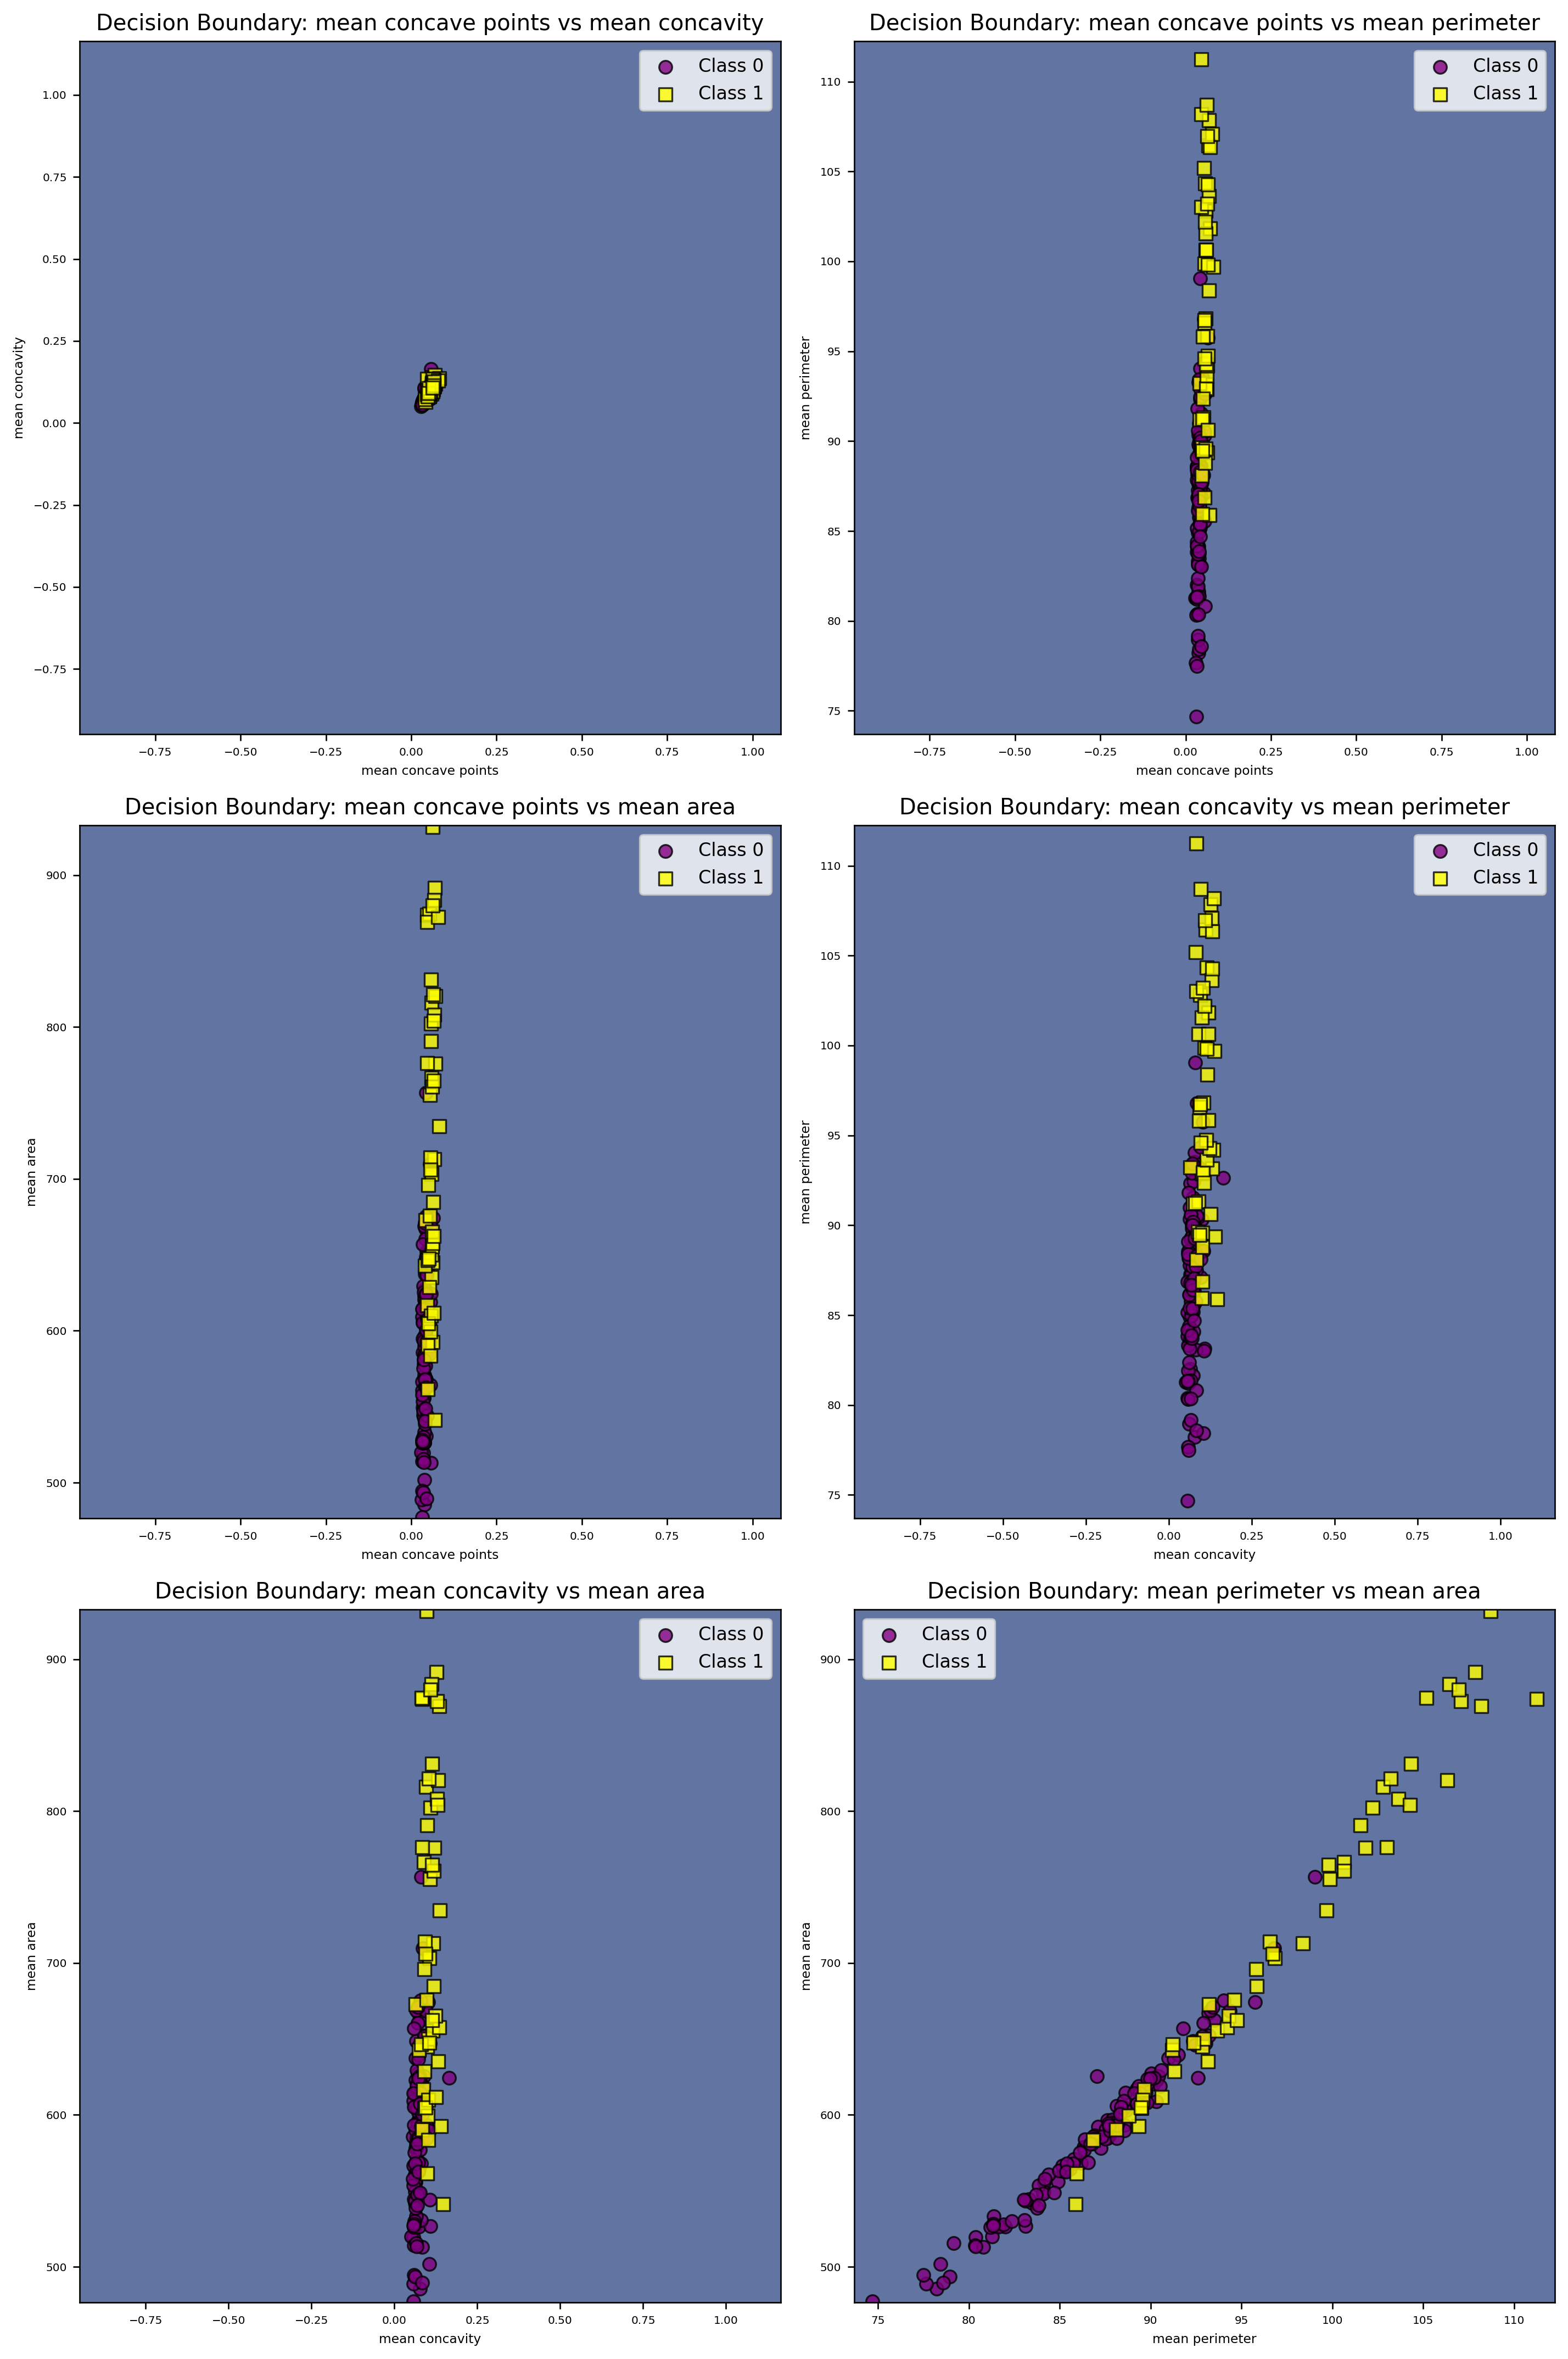

In [498]:
# Define colors and markers for each class
colors = ['purple', 'yellow']  # Change colors as desired
markers = ['o', 's']  # circle for class 0, square for class 1
labels = ['Class 0', 'Class 1']

# Assuming top_features is already defined
top_features = [t_scores[i][0] for i in range(4)]  # Ensure top_features contains the correct features

# Convert preprocessed features and encoded target into DataFrames
X_train_df = pd.DataFrame(X_train_preprocessed_db, columns=X_train.columns)
y_train_df = pd.DataFrame(y_train_encoded_db, columns=['label'])

# Extracting the necessary data from the training set
X_train_top_features = X_train_df[top_features]
y_train_top_features = y_train_df

# Function to create a mesh grid
def make_meshgrid(x, y, ns=100):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, ns),
                         np.linspace(y_min, y_max, ns))
    return xx, yy

# Function to plot decision boundaries
def plot_contours(clf, xx, yy, xmean, n1, n2, feature_names, ax=None, **params):
    fullx = np.ones((xx.ravel().shape[0], len(feature_names))) * xmean
    fullx[:, n1] = xx.ravel()
    fullx[:, n2] = yy.ravel()
    Z = clf.predict(fullx)
    Z = Z.reshape(xx.shape)
    if ax is None:
        ax = plt.gca()
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Calculating means for each class from the training set
means = {}
for feature in X_train_df.columns:
    means[feature] = 0.5 * (X_train_df[feature][y_train_df['label'] == 0].mean() + X_train_df[feature][y_train_df['label'] == 1].mean())

# Creating the decision boundary plots
feature_pairs = [(top_features[i], top_features[j]) for i in range(4) for j in range(i+1, 4)]

fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()

for idx, (feature1, feature2) in enumerate(feature_pairs):
    xx, yy = make_meshgrid(X_train_top_features[feature1], X_train_top_features[feature2])
    xmean = np.array([means[feature] for feature in X_train_df.columns])
    ax = axes[idx]
    
    plot_contours(best_model, xx, yy, xmean, X_train_df.columns.get_loc(feature1), X_train_df.columns.get_loc(feature2), X_train_df.columns, ax=ax, alpha=0.8)
    
    # Scatter plot with colors and markers based on class labels
    for label, color, marker in zip([0, 1], colors, markers):
        ax.scatter(X_train_top_features.loc[y_train_top_features['label'] == label, feature1],
                   X_train_top_features.loc[y_train_top_features['label'] == label, feature2],
                   c=color, marker=marker, label=f'Class {label}', edgecolors='k', linewidth=1, s=50, alpha=0.8)
    
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_title(f'Decision Boundary: {feature1} vs {feature2}')
    ax.legend()

plt.tight_layout()
plt.show()


This code employs scaled data to improve the clarity of the decision boundary visualization, which was less distinct with the original data values.

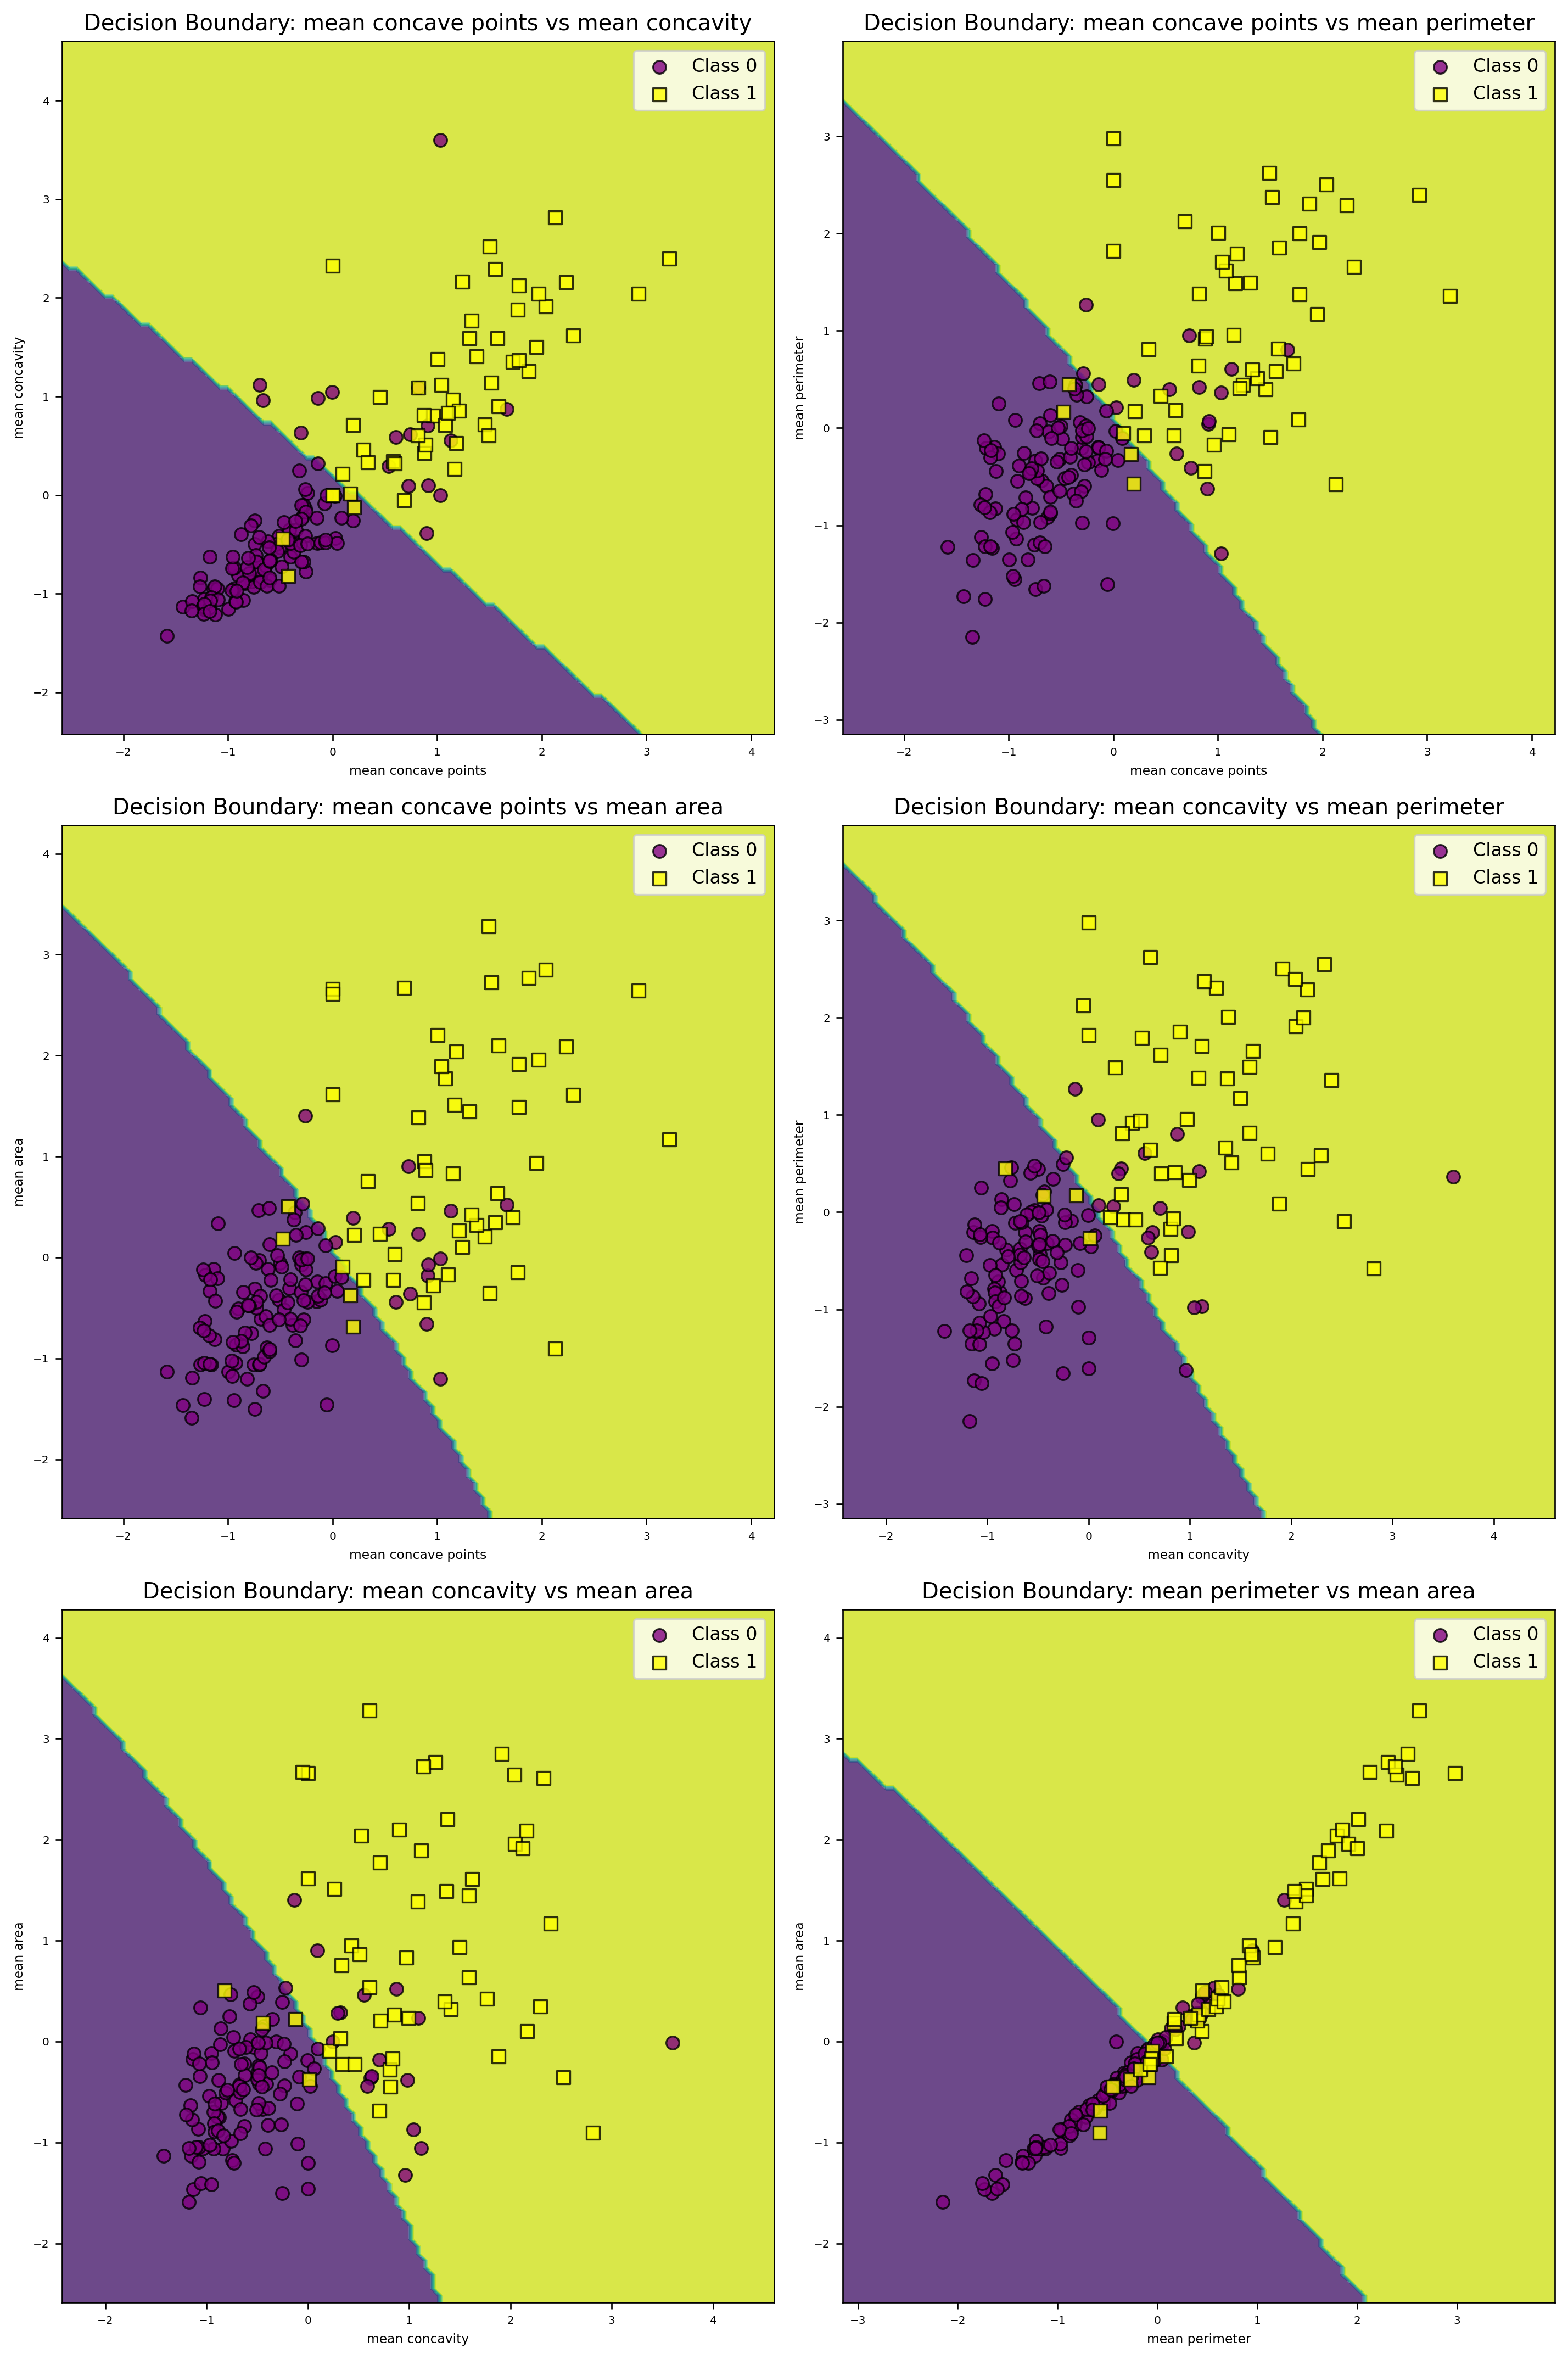

In [499]:
# Convert preprocessed features and encoded target into DataFrames
X_train_scaled_df = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)
y_train_df = pd.DataFrame(y_train_encoded_db, columns=['label'])

# Extracting the necessary data from the training set
X_train_top_features = X_train_scaled_df[top_features]
y_train_top_features = y_train_df

# Calculating means for each class from the training set
means = {}
for feature in X_train_scaled_df.columns:
    means[feature] = 0.5 * (X_train_scaled_df[feature][y_train_df['label'] == 0].mean() + X_train_scaled_df[feature][y_train_df['label'] == 1].mean())

# Creating the decision boundary plots
feature_pairs = [(top_features[i], top_features[j]) for i in range(4) for j in range(i+1, 4)]

fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()

for idx, (feature1, feature2) in enumerate(feature_pairs):
    xx, yy = make_meshgrid(X_train_top_features[feature1], X_train_top_features[feature2])
    xmean = np.array([means[feature] for feature in X_train_scaled_df.columns])
    ax = axes[idx]
    
    plot_contours(best_model, xx, yy, xmean, X_train_scaled_df.columns.get_loc(feature1), X_train_scaled_df.columns.get_loc(feature2), X_train_scaled_df.columns, ax=ax, alpha=0.8)
    
    # Scatter plot with colors and markers based on class labels
    for label, color, marker in zip([0, 1], colors, markers):
        ax.scatter(X_train_top_features.loc[y_train_top_features['label'] == label, feature1],
                   X_train_top_features.loc[y_train_top_features['label'] == label, feature2],
                   c=color, marker=marker, label=f'Class {label}', edgecolors='k', linewidth=1, s=50, alpha=0.8)
    
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_title(f'Decision Boundary: {feature1} vs {feature2}')
    ax.legend()

plt.tight_layout()
plt.show()


### 4.3 Performance specification
**Does the final model meet the client's criteria?  Explain why or why not.** [100 words maximum]

The final model meets the client's criteria by achieving a recall of 92.31%, exceeding the 90% requirement for detecting malignant cases. Its precision of 85.71% results in approximately 14.29% false positives among benign cases, which is below the 20% threshold specified. The confusion matrix confirms 1 false negative and 2 false positives out of 44 total cases, supporting these results. Thus, while effectively identifying malignancy, the model maintains a false positive rate among benign cases that aligns with the client's stringent requirement, ensuring reliable performance in distinguishing between malignant and benign growths.